In [2]:

import pandas as pd 
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklift.models import SoloModel, TwoModels, ClassTransformation, ClassTransformationReg
import matplotlib.pyplot as plt
import numpy as np
import swifter
from tqdm import tqdm
import gc
pd.options.display.max_columns = None



# Object For Preprocessing

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
class PrepocessingDataSetLetu():
    def __init__(self,  cat_vars = ['lftm_type','SEGMENT_N'
                                ,	'SUB_EMAIL'
                                , 'Тип карты'	
                                , 'Канал регистрации'
                                , 'NewComer'] 
                ,  for_norm = ['last_order_days',	'AMOUNT'
                                ,	'ORDERS'
                                ,	'AOV'	
                                ,'LTV_1M'
                                , 'AO_per_month'
                                , 'GET_Bonus'
                                ,	'USE_Bonus'
                                ,	'NON_SPEND_BONUS'
                                ,	'BASE_GET_Bonus'
                                ,	'BASE_USE_Bonus'
                                ,	'Express_GET_Bonus'
                                ,	'Express_USE_Bonus'
                                ,	'Camp_GET_Bonus'
                                ,	'REG_GET_Bonus'	
                                , 'Camp_BASE_GET_Bonus'
                                ,	'REG_BASE_GET_Bonus'
                                , 'AVG_USE_BONUS'
                                ,	'DISC_AMOUNT'
                                ,	'DISC_ORDERS'
                                , 'BASE_AVG_USE_BONUS'
                                ,	'BASE_DISC_AMOUNT'
                                ,	'BASE_DISC_ORDERS'
                                , 'Express_AVG_USE_BONUS',	'Express_DISC_AMOUNT',	'Express_DISC_ORDERS'
                                ,'min_days_between', 'max_days_between', 'avg_days_between']
                , age = 'AGE'
               
            ):
            self.cat_vars = cat_vars
            self.for_norm = for_norm
            self.age = age
            self.scaler = None#StandardScaler()
            self.ohe = None#OneHotEncoder()
            self.ohe_solomodel = None#OneHotEncoder()
            self.med = None


    def preprocessing_data(self, df):
                        Y_var = df[['target','treat']]
                        X_var = df.drop(['target','treat'], axis = 1)
                        dataset = pd.DataFrame()
                        
                        ## Categorical to Vec
                        if(self.ohe is None):
                            self.ohe = OneHotEncoder()
                            res = self.ohe.fit_transform(X_var[self.cat_vars].values).toarray()
                        else:
                            res = self.ohe.transform(X_var[self.cat_vars].values).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.cat_vars, axis =1)                    
                       #dataset.head()

                        ## Numeric preprocessing
                        if(self.med is None):
                            self.med = X_var[self.age].median()

                        res =  X_var[self.age].apply(lambda x: x if((x >= 16) and (x <= 90)) else self.med).fillna(self.med)
                        res = (res / 100).values                                            
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)                                            
                        X_var = X_var.drop([self.age], axis =1).fillna(0)                  

                        if(self.scaler is None):
                            self.scaler = StandardScaler()
                            res = self.scaler.fit_transform(X_var[self.for_norm].values)
                        else:
                            res = self.scaler.transform(X_var[self.for_norm].values)

                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.for_norm, axis =1)      
                        dataset = pd.concat([dataset
                                        , pd.DataFrame(X_var.values)] , axis = 1)
                        del X_var   
                        gc.collect()
                        cols = ['var_'+str(i) for i in range(dataset.shape[1])]
                        dataset.columns = cols
                        dataset.index = df.index
                        return dataset, Y_var  


    
    def preprocessing_data_solomodel(self, df):
                        Y_var = df[['target','treat']]
                        X_var = df.drop(['target','treat'], axis = 1)
                        dataset = pd.DataFrame()
                        
                        ## Categorical to Vec
                        if(self.ohe is None):
                            self.ohe = OneHotEncoder()
                            res = self.ohe.fit_transform(X_var[self.cat_vars].values).toarray()
                        else:
                            res = self.ohe.transform(X_var[self.cat_vars].values).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.cat_vars, axis =1)                    
                       #dataset.head()

                        ## Numeric preprocessing
                        if(self.med is None):
                            self.med = X_var[self.age].median()

                        res =  X_var[self.age].apply(lambda x: x if((x >= 16) and (x <= 90)) else self.med).fillna(self.med)
                        res = (res / 100).values    
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)                                            
                        X_var = X_var.drop([self.age], axis =1).fillna(0)                  

                        if(self.scaler is None):
                            self.scaler = StandardScaler()
                            res = self.scaler.fit_transform(X_var[self.for_norm].values)
                        else:
                            res = self.scaler.transform(X_var[self.for_norm].values)

                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.for_norm, axis =1)      
                        dataset = pd.concat([dataset
                                        , pd.DataFrame(X_var.values)] , axis = 1)
                        del X_var   
                        gc.collect()


                        if(self.ohe_solomodel is None):
                            self.ohe_solomodel = OneHotEncoder()
                            res = self.ohe_solomodel.fit_transform(Y_var.treat.values.reshape(-1, 1)).toarray()
                        else:
                            res = self.ohe_solomodel.transform(Y_var.treat.values.reshape(-1, 1)).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)

                        cols = ['var_'+str(i) for i in range(dataset.shape[1])]
                        dataset.columns = cols
                        dataset.index = df.index
                        return dataset, Y_var

# Routines

In [4]:



# def preprocessing_LETU(df):
#     Y_var = df[['target','treat']]
#     X_var = df.drop(['target','treat'], axis = 1)
#     dataset = pd.DataFrame()
#     cat_vars = ['lftm_type','SEGMENT_N'
#                 ,	'SUB_EMAIL'
#                 , 'Тип карты'	
#                 , 'Канал регистрации'
#                 , 'NewComer'] 
#     ## Categorical to Vec
#     dataset = pd.concat([dataset
#                     , pd.get_dummies(X_var[cat_vars]
#                                     )
#                     ], axis = 1)
#     X_var = X_var.drop(cat_vars, axis =1)                    
#     # dataset.head()

#     ## Numeric preprocessing
#     med = X_var['AGE'].median()
#     dataset = pd.concat([dataset
#                         , X_var['AGE'].apply(lambda x: x if((x >= 16) and (x <= 90)) else med).fillna(med)
#                         ], axis=1)
#     X_var = X_var.drop(['AGE'], axis =1)                     
    
#     for_norm = ['last_order_days',	'AMOUNT'
#             ,	'ORDERS'
#             ,	'AOV'	
#             ,'LTV_1M'
#             , 'AO_per_month'
#             , 'GET_Bonus'
#             ,	'USE_Bonus'
#             ,	'NON_SPEND_BONUS'
#             ,	'BASE_GET_Bonus'
#             ,	'BASE_USE_Bonus'
#             ,	'Express_GET_Bonus'
#             ,	'Express_USE_Bonus'
#             ,	'Camp_GET_Bonus'
#             ,	'REG_GET_Bonus'	
#             , 'Camp_BASE_GET_Bonus'
#             ,	'REG_BASE_GET_Bonus'
#             , 'AVG_USE_BONUS'
#             ,	'DISC_AMOUNT'
#             ,	'DISC_ORDERS'
#             , 'BASE_AVG_USE_BONUS'
#             ,	'BASE_DISC_AMOUNT'
#             ,	'BASE_DISC_ORDERS'
#             , 'Express_AVG_USE_BONUS',	'Express_DISC_AMOUNT',	'Express_DISC_ORDERS'
#              ,'min_days_between', 'max_days_between', 'avg_days_between']

#     x_means = X_var[for_norm].mean()
#     x_std = X_var[for_norm].std()  
#     x_v = X_var[for_norm].astype(float).copy() 
#     dataset = pd.concat([dataset
#                     , (x_v - x_means).fillna(0) / x_std
#                     ], axis = 1)
#     X_var = X_var.drop(for_norm, axis =1)      

#     dataset = pd.concat([dataset
#                     , X_var.fillna(0)] , axis = 1)
#     del X_var   
#     gc.collect()
#     return dataset, Y_var  



In [5]:
# def preprocessing_LETU_without_norm(df):
#         Y_var = df[['target','treat']]
#         X_var = df.drop(['target','treat'], axis = 1)
#         dataset = pd.DataFrame()
#         cat_vars = ['lftm_type','SEGMENT_N'
#                         ,	'SUB_EMAIL'
#                         , 'Тип карты'	
#                         , 'Канал регистрации'
#                         , 'NewComer'] 
#         # Categorical to Vec
#         dataset = pd.concat([dataset
#                         , pd.get_dummies(X_var[cat_vars])
#                         ], axis = 1)
#         X_var = X_var.drop(cat_vars, axis =1)                    
#         dataset.head()

#         # Numeric preprocessing
#         med = X_var['AGE'].median()
#         dataset = pd.concat([dataset
#                                 , X_var['AGE'].apply(lambda x: x if((x >= 16) and (x <= 90)) else med).fillna(med)
#                                 ], axis=1)
#         X_var = X_var.drop(['AGE'], axis =1)                     

#         for_norm = ['last_order_days',	'AMOUNT'
#                 ,	'ORDERS'
#                 ,	'AOV'	
#                 ,'LTV_1M'
#                 , 'AO_per_month'
#                 , 'GET_Bonus'
#                 ,	'USE_Bonus'
#                 ,	'NON_SPEND_BONUS'
#                 ,	'BASE_GET_Bonus'
#                 ,	'BASE_USE_Bonus'
#                 ,	'Express_GET_Bonus'
#                 ,	'Express_USE_Bonus'
#                 ,	'Camp_GET_Bonus'
#                 ,	'REG_GET_Bonus'	
#                 , 'Camp_BASE_GET_Bonus'
#                 ,	'REG_BASE_GET_Bonus'
#                 , 'AVG_USE_BONUS'
#                 ,	'DISC_AMOUNT'
#                 ,	'DISC_ORDERS'
#                 , 'BASE_AVG_USE_BONUS'
#                 ,	'BASE_DISC_AMOUNT'
#                 ,	'BASE_DISC_ORDERS'
#                 , 'Express_AVG_USE_BONUS',	'Express_DISC_AMOUNT',	'Express_DISC_ORDERS'
#                 ,'min_days_between', 'max_days_between', 'avg_days_between']

        
#         x_v = X_var[for_norm].astype(float).copy() 
#         med = x_v.median()
#         dataset = pd.concat([dataset
#                         , x_v.fillna(med)
#                         ], axis = 1)
#         X_var = X_var.drop(for_norm, axis =1)      

#         med = X_var.median()
#         dataset = pd.concat([dataset
#                         , X_var.astype(float).fillna(med)] , axis = 1)
#         del X_var   
#         gc.collect()
#         return dataset.astype(float).fillna(pd.NA), Y_var.astype(float)  



# Базовая модель

In [6]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
display(df.head())
proc_data = PrepocessingDataSetLetu()
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 


SEGMENT_N SUB_EMAIL  target  treat lftm_type  NewComer  \
7727314307         3        Да       0      0  NewComer         1   
7721696179         2       Нет       0      0  NewComer         0   
7727261180        -1        Да       0      0  NewComer         1   
7725642339         1       Нет       0      1  NewComer         0   
7720389215         1       Нет       0      1  NewComer         0   

                                   Тип карты Канал регистрации   AGE  AMOUNT  \
7727314307  Как карточное платежное средство           Розница   NaN  3403.4   
7721696179            Без возможности оплаты             Ecomm  51.0     NaN   
7727261180  Как карточное платежное средство             Ecomm  32.0     NaN   
7725642339  Как карточное платежное средство             Ecomm   NaN   959.2   
7720389215            Без возможности оплаты           Розница   NaN  1603.0   

            ORDERS     AOV  last_order_days  LTV_1M  AO_per_month  GET_Bonus  \
7727314307     2.0  1701.7             50.0  850.85          0.50      536.0   
7721696179     0.0     NaN              NaN     NaN          0.00     1300.0   
7727261180     4.0     NaN              8.0     NaN          1.00     4000.0   
7725642339     1.0   959.2             68.0  239.80          0.25      510.0   
7720389215     1.0  1603.0            105.0  400.75          0.25      517.0   

            USE_Bonus  NON_SPEND_BONUS  BASE_GET_Bonus  BASE_USE_Bonus  \
7727314307      502.0             34.0            36.0             2.0   
7721696179        NaN              NaN             NaN             NaN   
7727261180     2500.0           1500.0             NaN             NaN   
7725642339        NaN              NaN            10.0             NaN   
7720389215        NaN              NaN            17.0             NaN   

            Express_GET_Bonus  Express_USE_Bonus  Camp_GET_Bonus  \
7727314307              500.0              500.0             NaN   
7721696179             1300.0                NaN             NaN   
7727261180             4000.0             2500.0             NaN   
7725642339              500.0                NaN             NaN   
7720389215              500.0                NaN             NaN   

            REG_GET_Bonus  Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus   AVG_DIS  \
7727314307           36.0                  NaN                36.0  0.133248   
7721696179            NaN                  NaN                 NaN       NaN   
7727261180            NaN                  NaN                 NaN  0.999200   
7725642339           10.0                  NaN                10.0       NaN   
7720389215           17.0                  NaN                17.0       NaN   

            AVG_USE_BONUS  DISC_AMOUNT  DISC_ORDERS  BASE_AVG_DIS  \
7727314307          502.0       3265.4          1.0      0.000612   
7721696179            NaN          NaN          NaN           NaN   
7727261180         1250.0          NaN          2.0           NaN   
7725642339            NaN          NaN          NaN           NaN   
7720389215            NaN          NaN          NaN           NaN   

            BASE_AVG_USE_BONUS  BASE_DISC_AMOUNT  BASE_DISC_ORDERS  \
7727314307                 2.0            3265.4               1.0   
7721696179                 NaN               NaN               NaN   
7727261180                 NaN               NaN               NaN   
7725642339                 NaN               NaN               NaN   
7720389215                 NaN               NaN               NaN   

            Express_AVG_DIS  Express_AVG_USE_BONUS  Express_DISC_AMOUNT  \
7727314307         0.132788                  500.0               3265.4   
7721696179              NaN                    NaN                  NaN   
7727261180         0.999200                 1250.0                  NaN   
7725642339              NaN                    NaN                  NaN   
7720389215              NaN                    NaN                  NaN   

            

var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

WAU = 0.008652738854483531; UpLift at 30%  0.008226945024051358; 0.008134716218376262


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


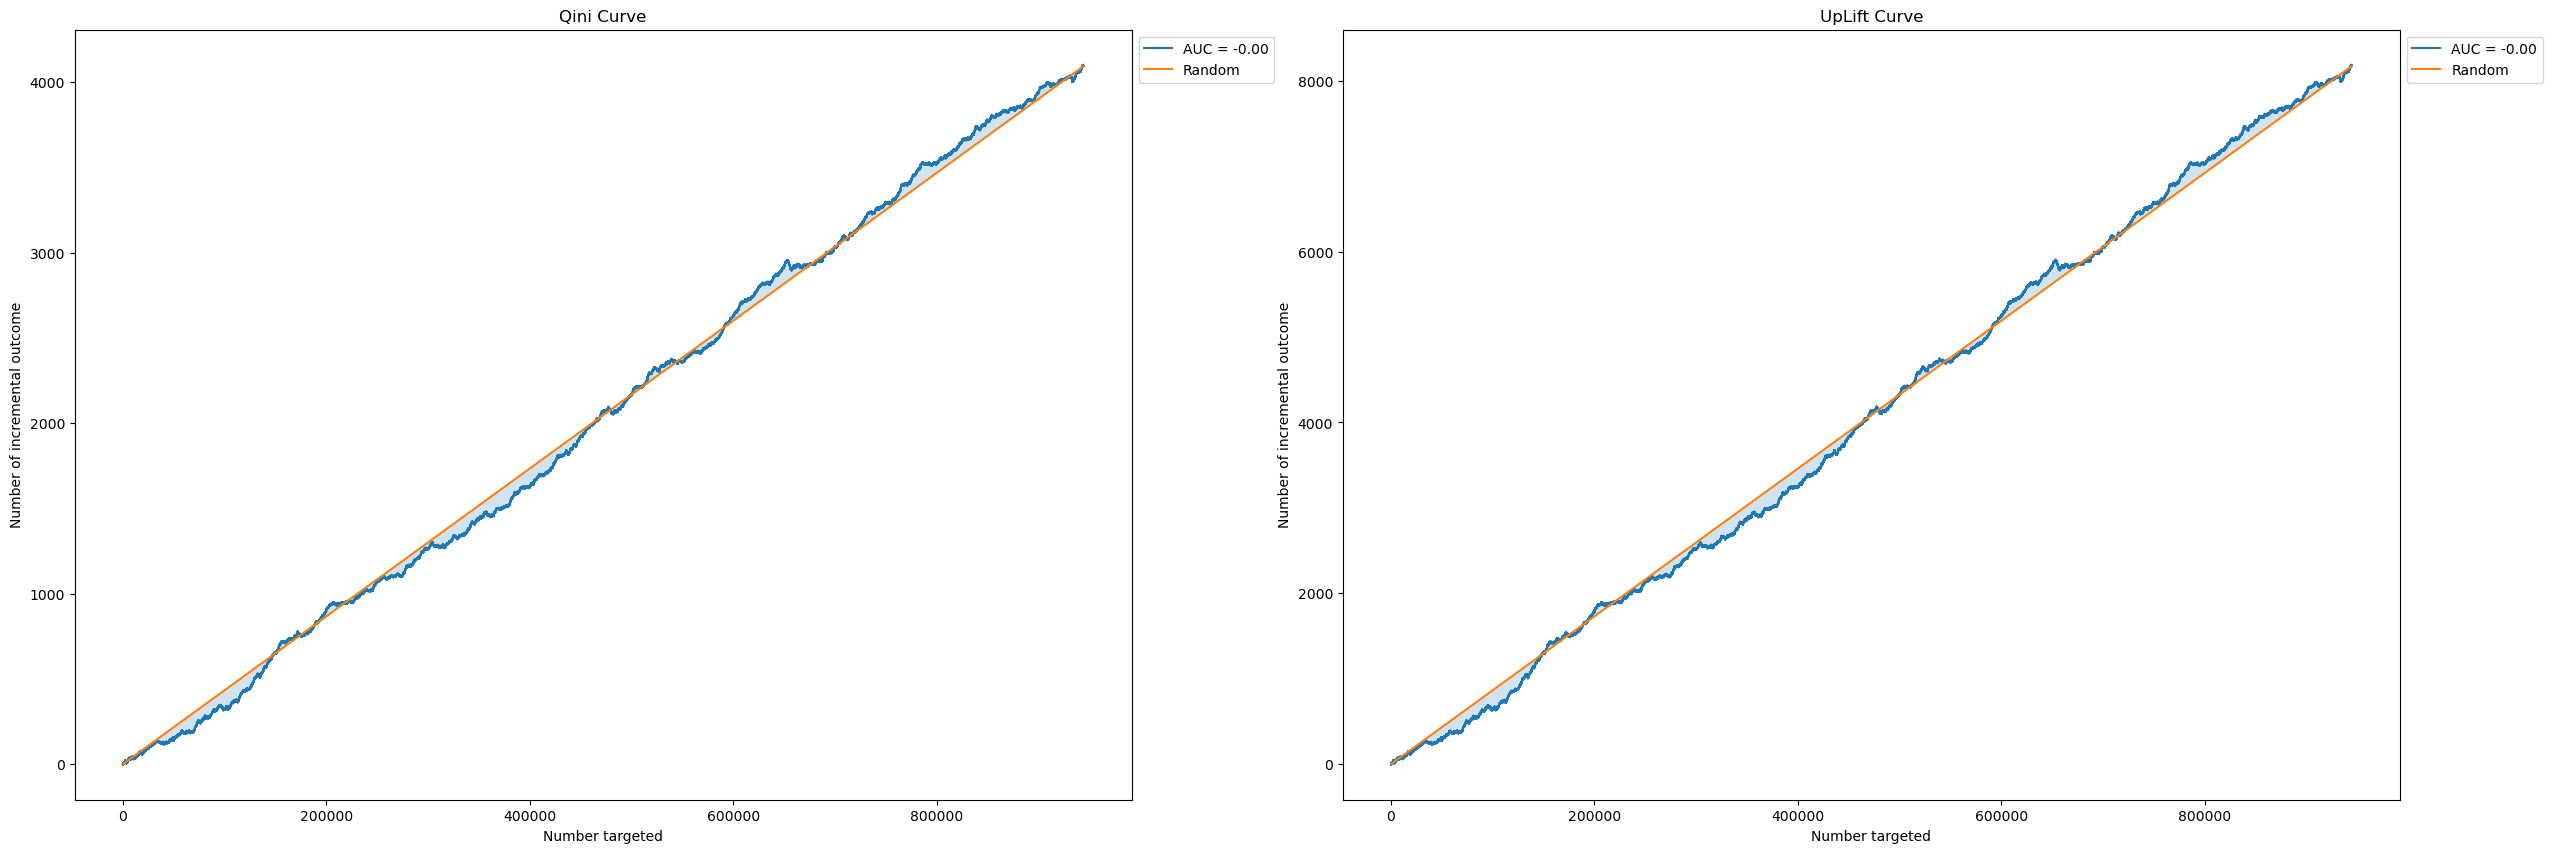

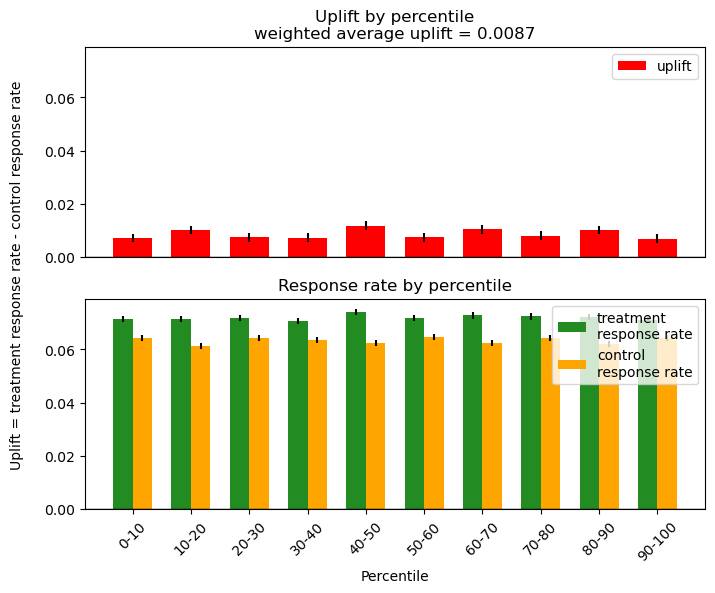

In [7]:
treat = Y_data.treat.values
y = Y_data.target.values

from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


y_pred = np.random.uniform(-1, 1, len(treat)).tolist()
gc.collect()
wau = weighted_average_uplift(y_true=y , uplift=y_pred,
                        treatment=treat)
uplift_overall = uplift_at_k(y_true=y , uplift=y_pred,
                        treatment=treat, strategy='overall', k=0.3)
uplift_group = uplift_at_k(y_true=y , uplift=y_pred,
                        treatment=treat, strategy='by_group', k=0.3)                        

print(f'WAU = {wau}; UpLift at 30%  {uplift_overall}; {uplift_group}')
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax[0].set_title('Qini Curve')
ax[1].set_title('UpLift Curve')
plot_qini_curve(y_true=y , uplift=y_pred,
                        treatment=treat, ax = ax[0], perfect=False)
gc.collect()
plot_uplift_curve(y_true=y , uplift=y_pred,
                        treatment=treat, ax = ax[1], perfect=False)
gc.collect()
gc.collect()
gc.collect()
plt.savefig(f"Plots/Base model Split.png")

plot_uplift_by_percentile(y_true=y , uplift=y_pred,
                        treatment=treat, kind='bar')
plt.savefig(f"Plots/Base model Procentile.png")






In [8]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

8068

# Метод одной модели

In [9]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
#X_data = pd.concat([X_data, pd.get_dummies(Y_data.treat)], axis= 1)
treat = Y_data.treat.values
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()

var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

0

In [10]:
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt



Split 1; WAU = 0.006677464840038331; UpLift at 30% 0.013390150105059534; 0.014668176930698718


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.008993157503015844; UpLift at 30% 0.017239006637998752; 0.01823522279605133


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.008728601225615331; UpLift at 30% 0.01747573142158522; 0.018319283040627923


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.009007243975576316; UpLift at 30% 0.016237170915185492; 0.016848227607851124


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.007085153938647753; UpLift at 30% 0.014694938577407446; 0.015951261712919676


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0081; Mean UpLift 30% =  0.0158; 0.0168


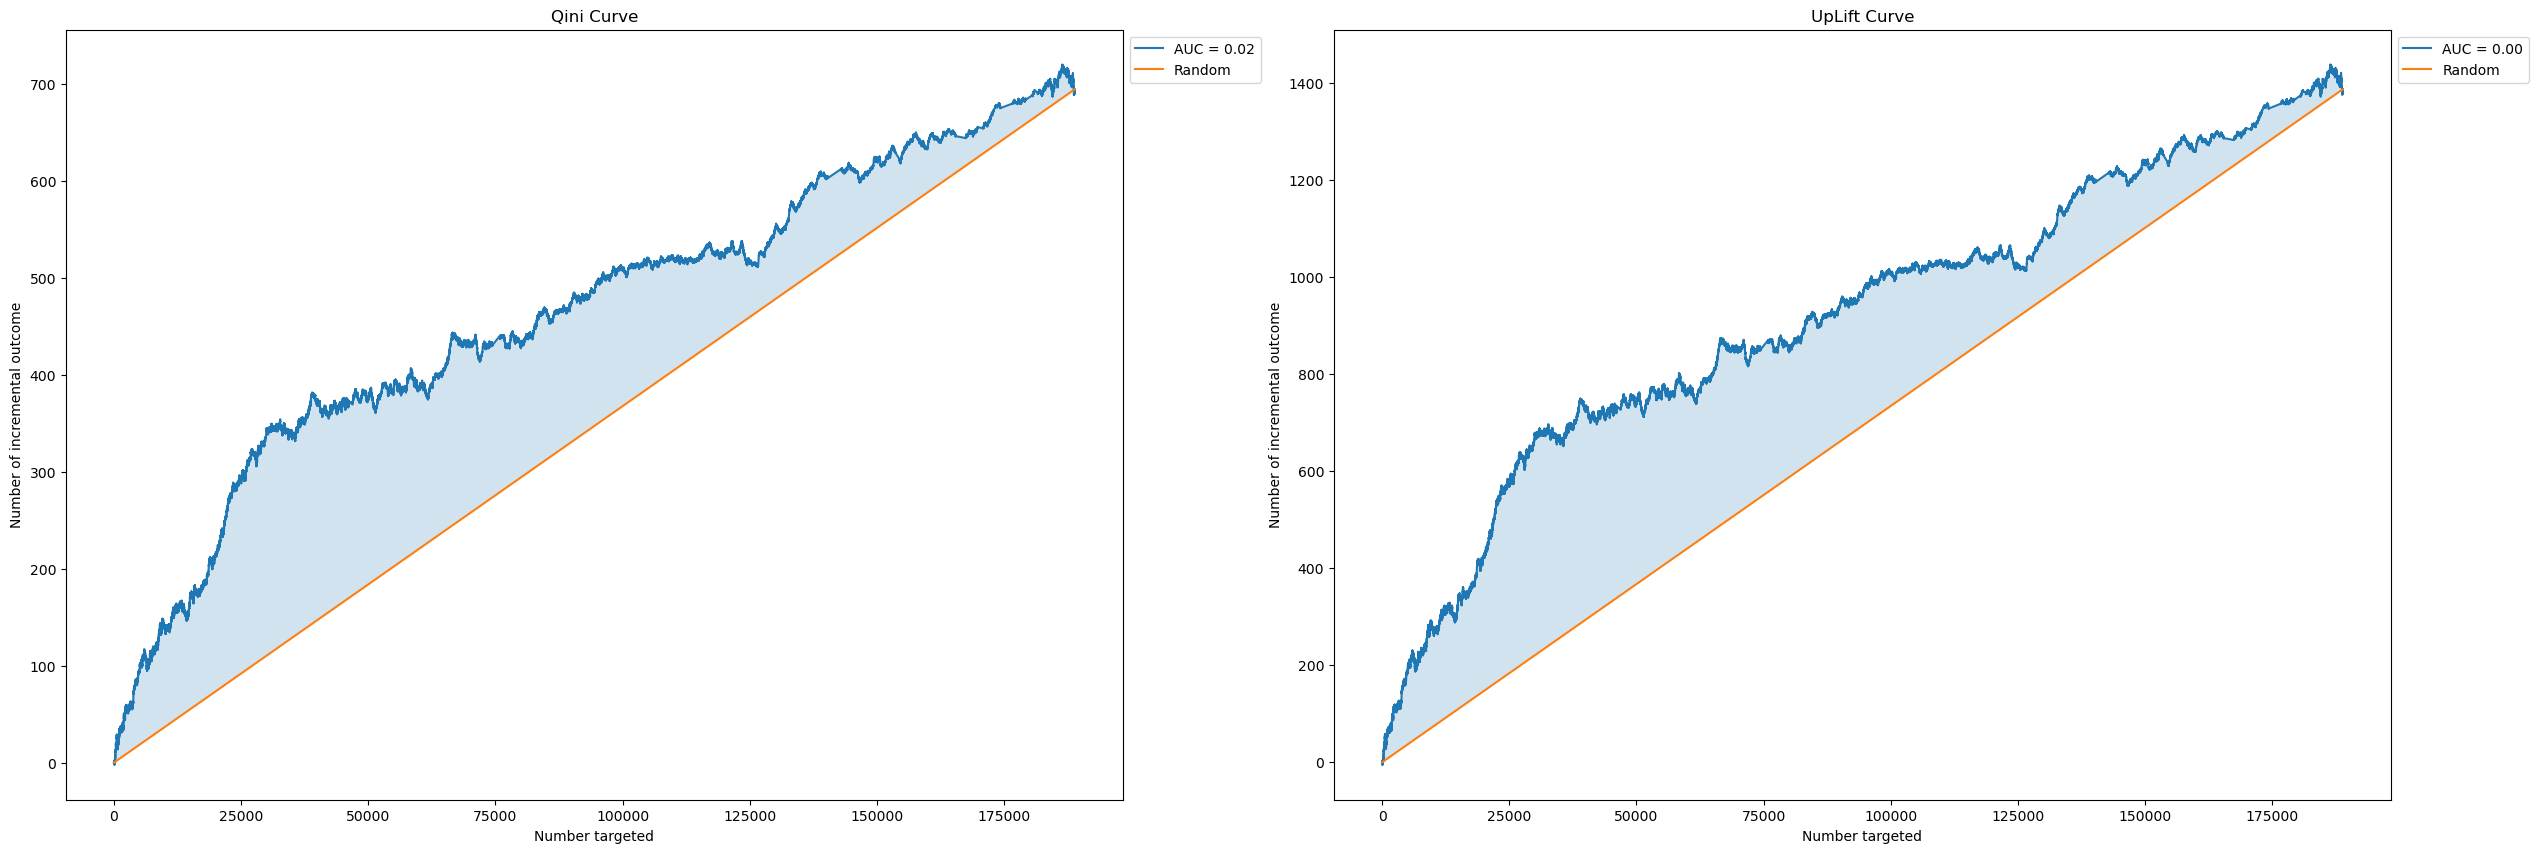

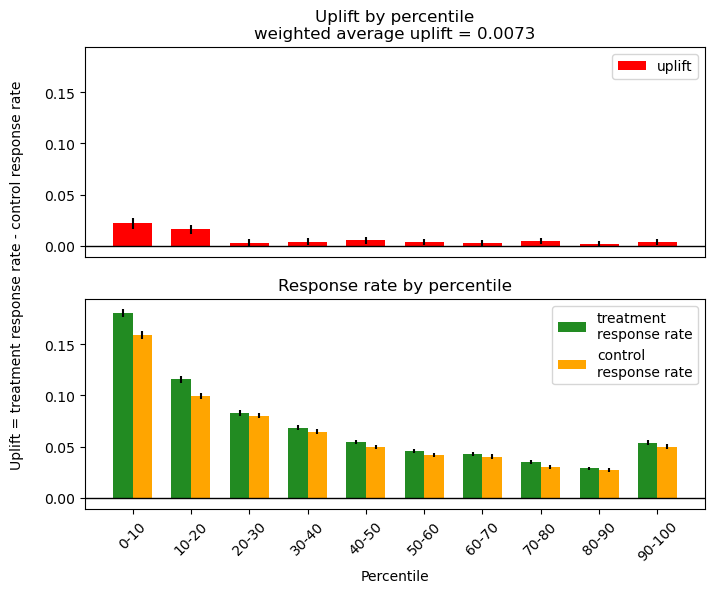

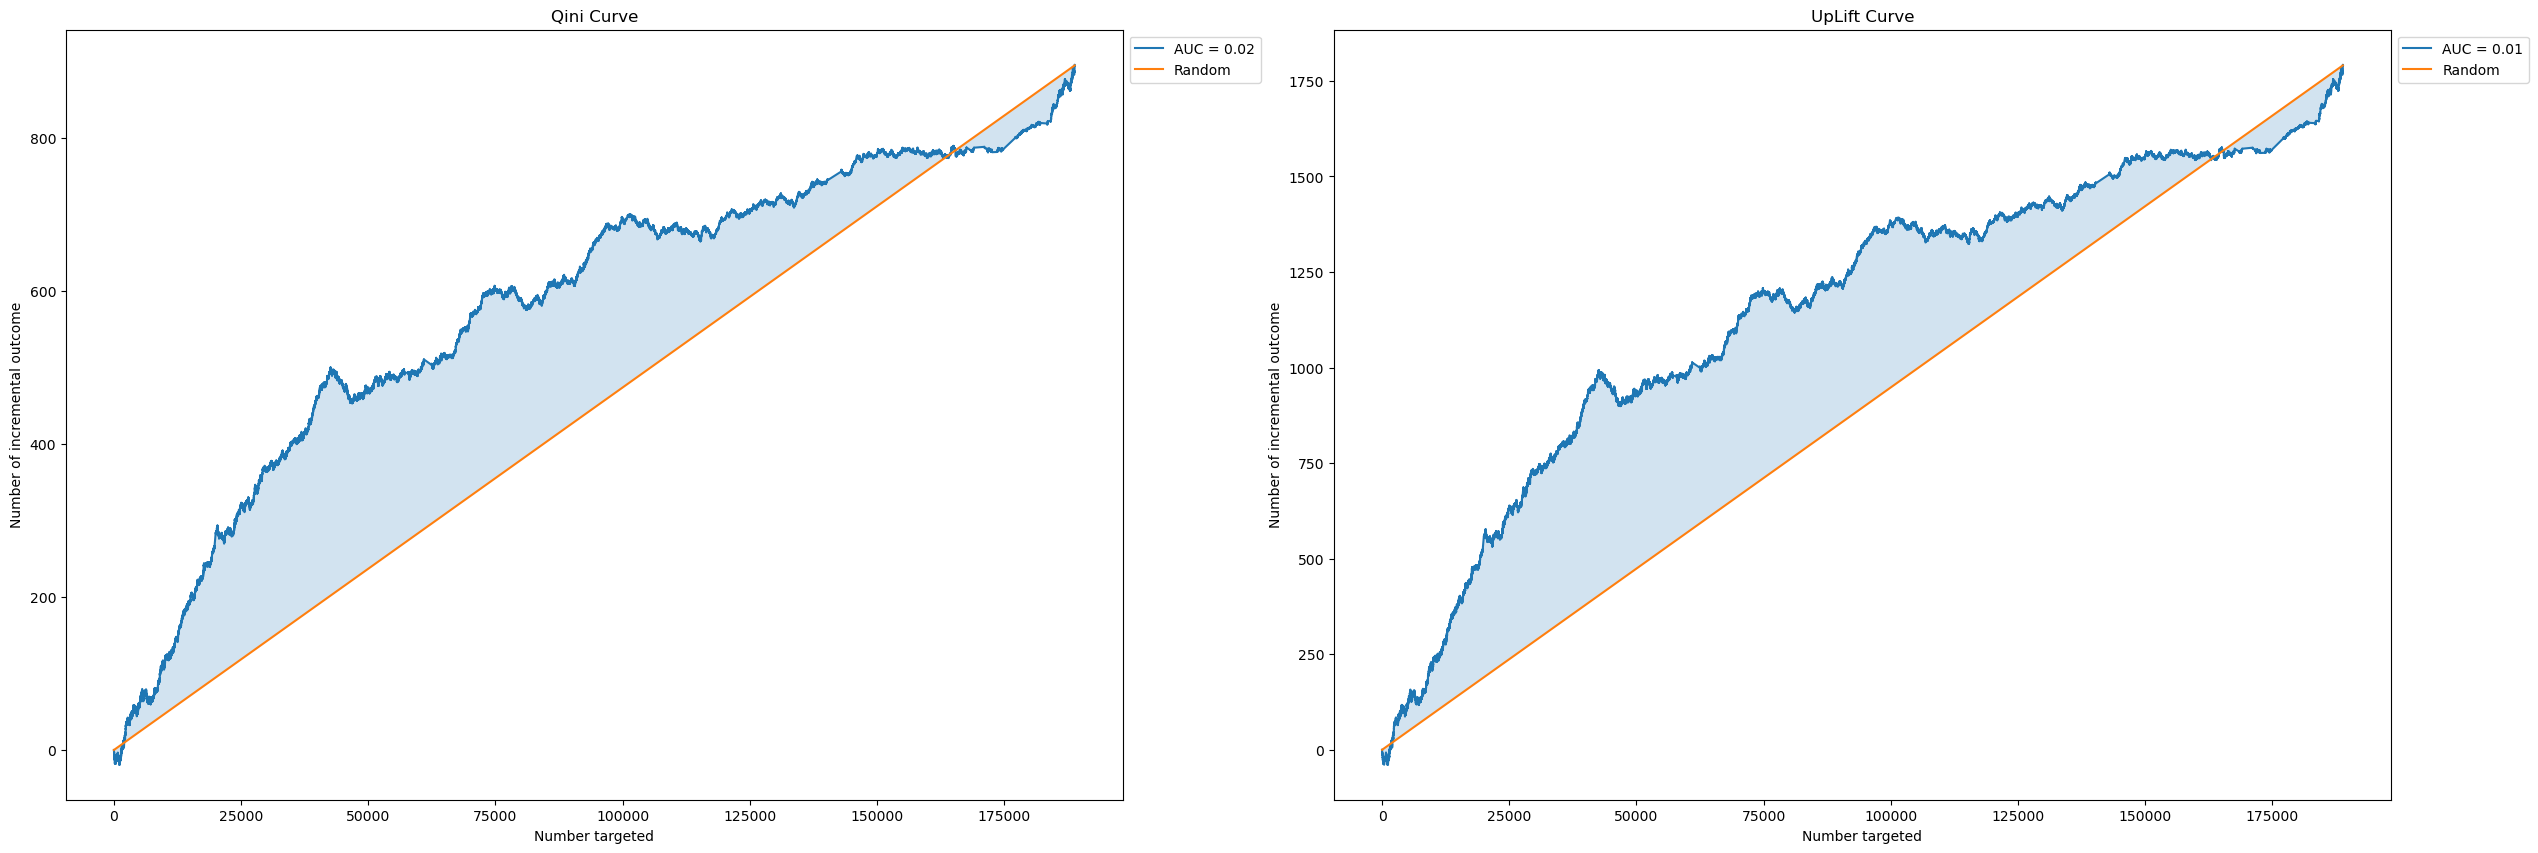

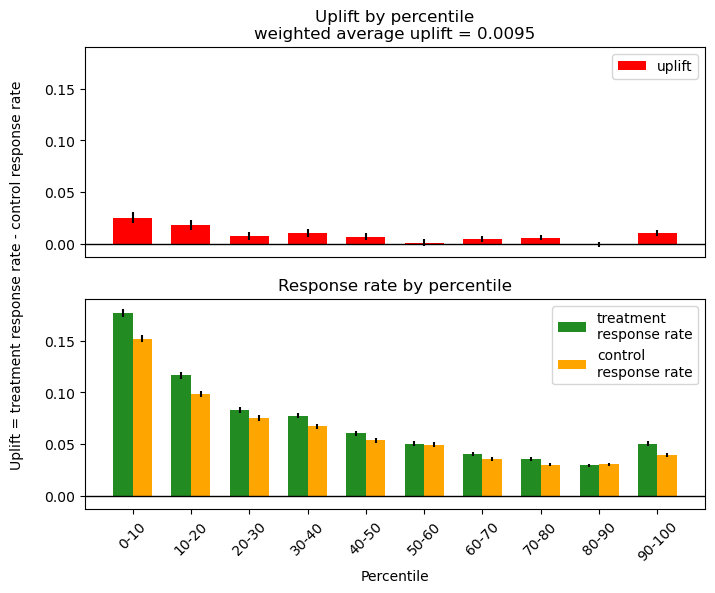

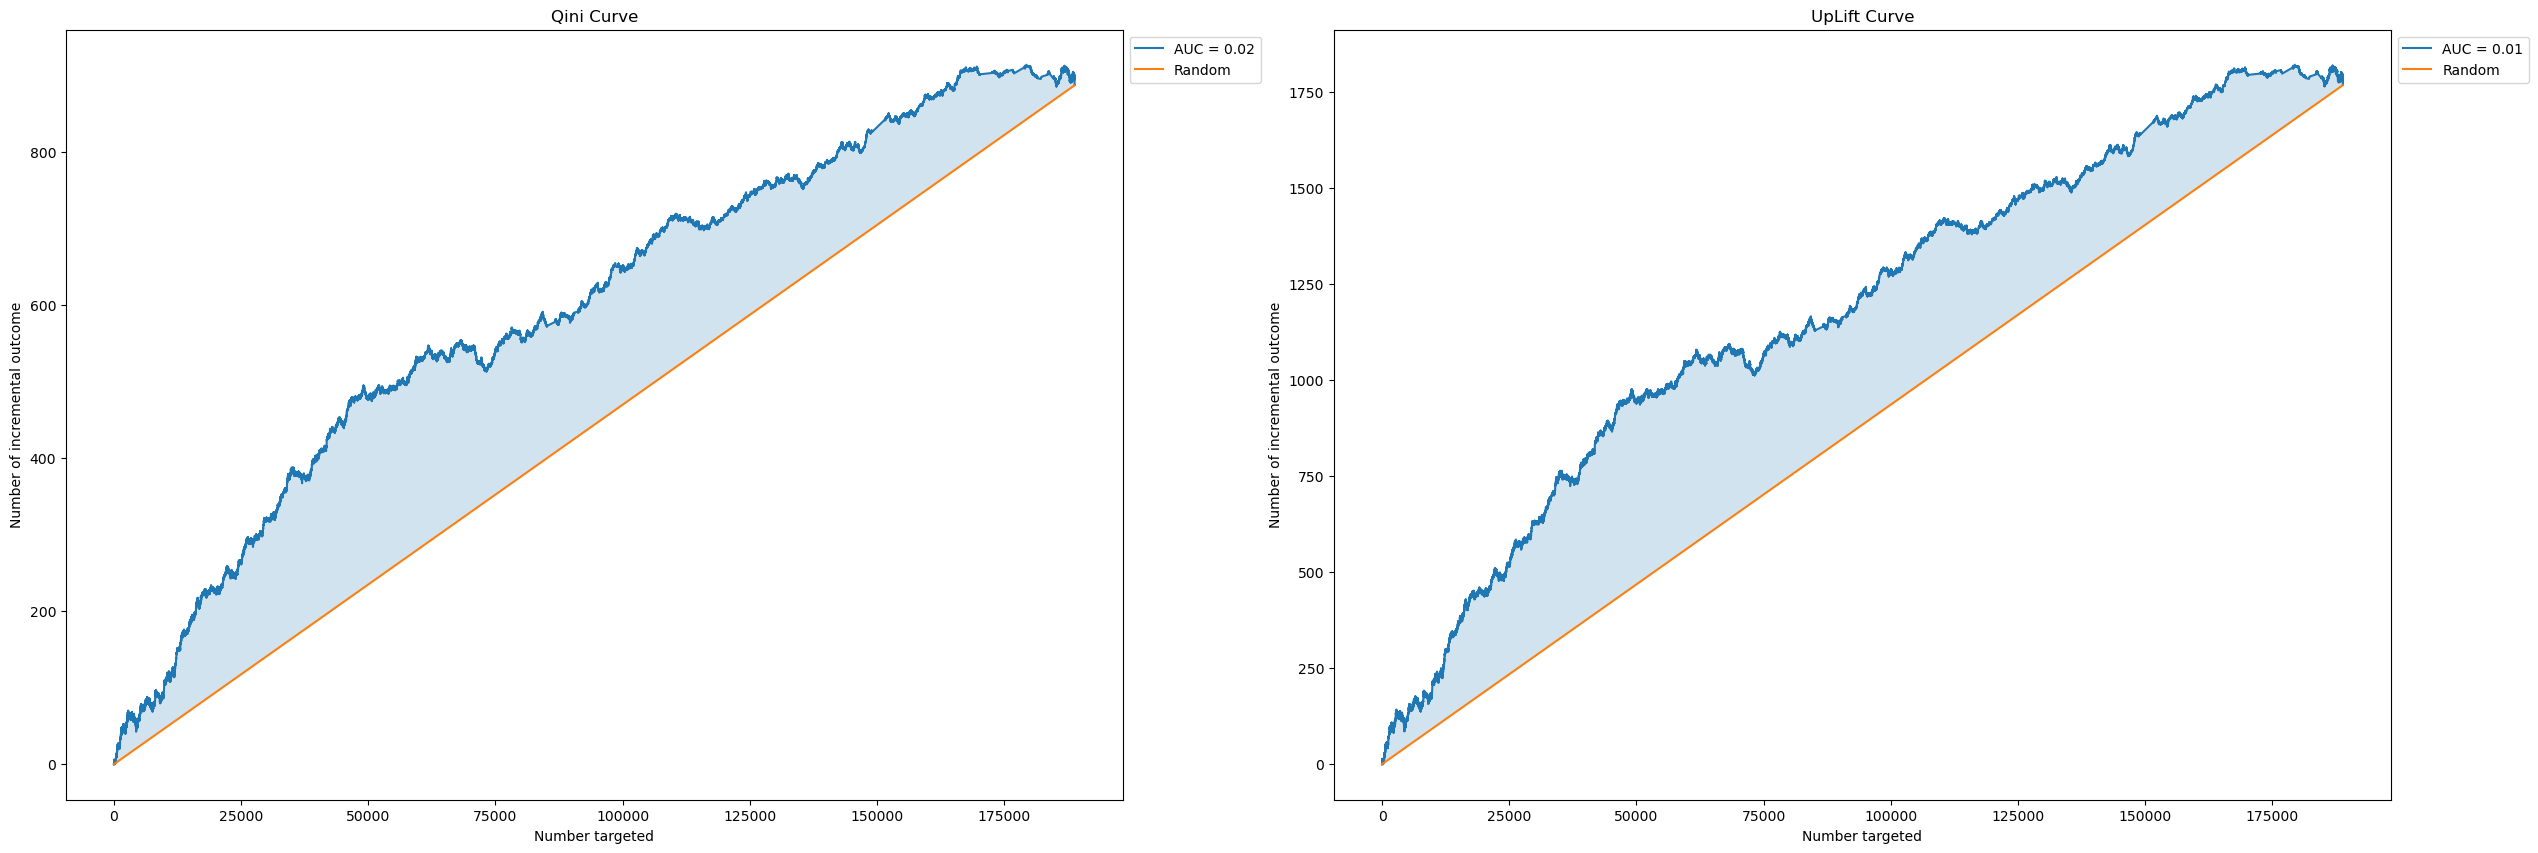

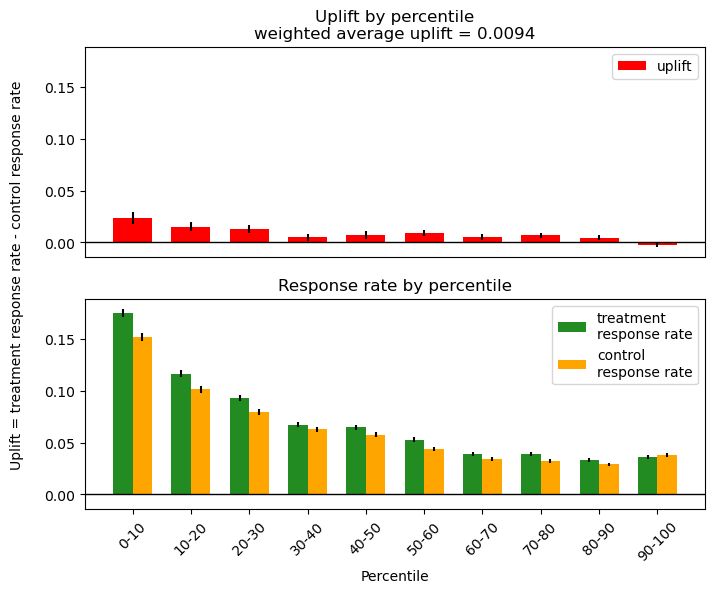

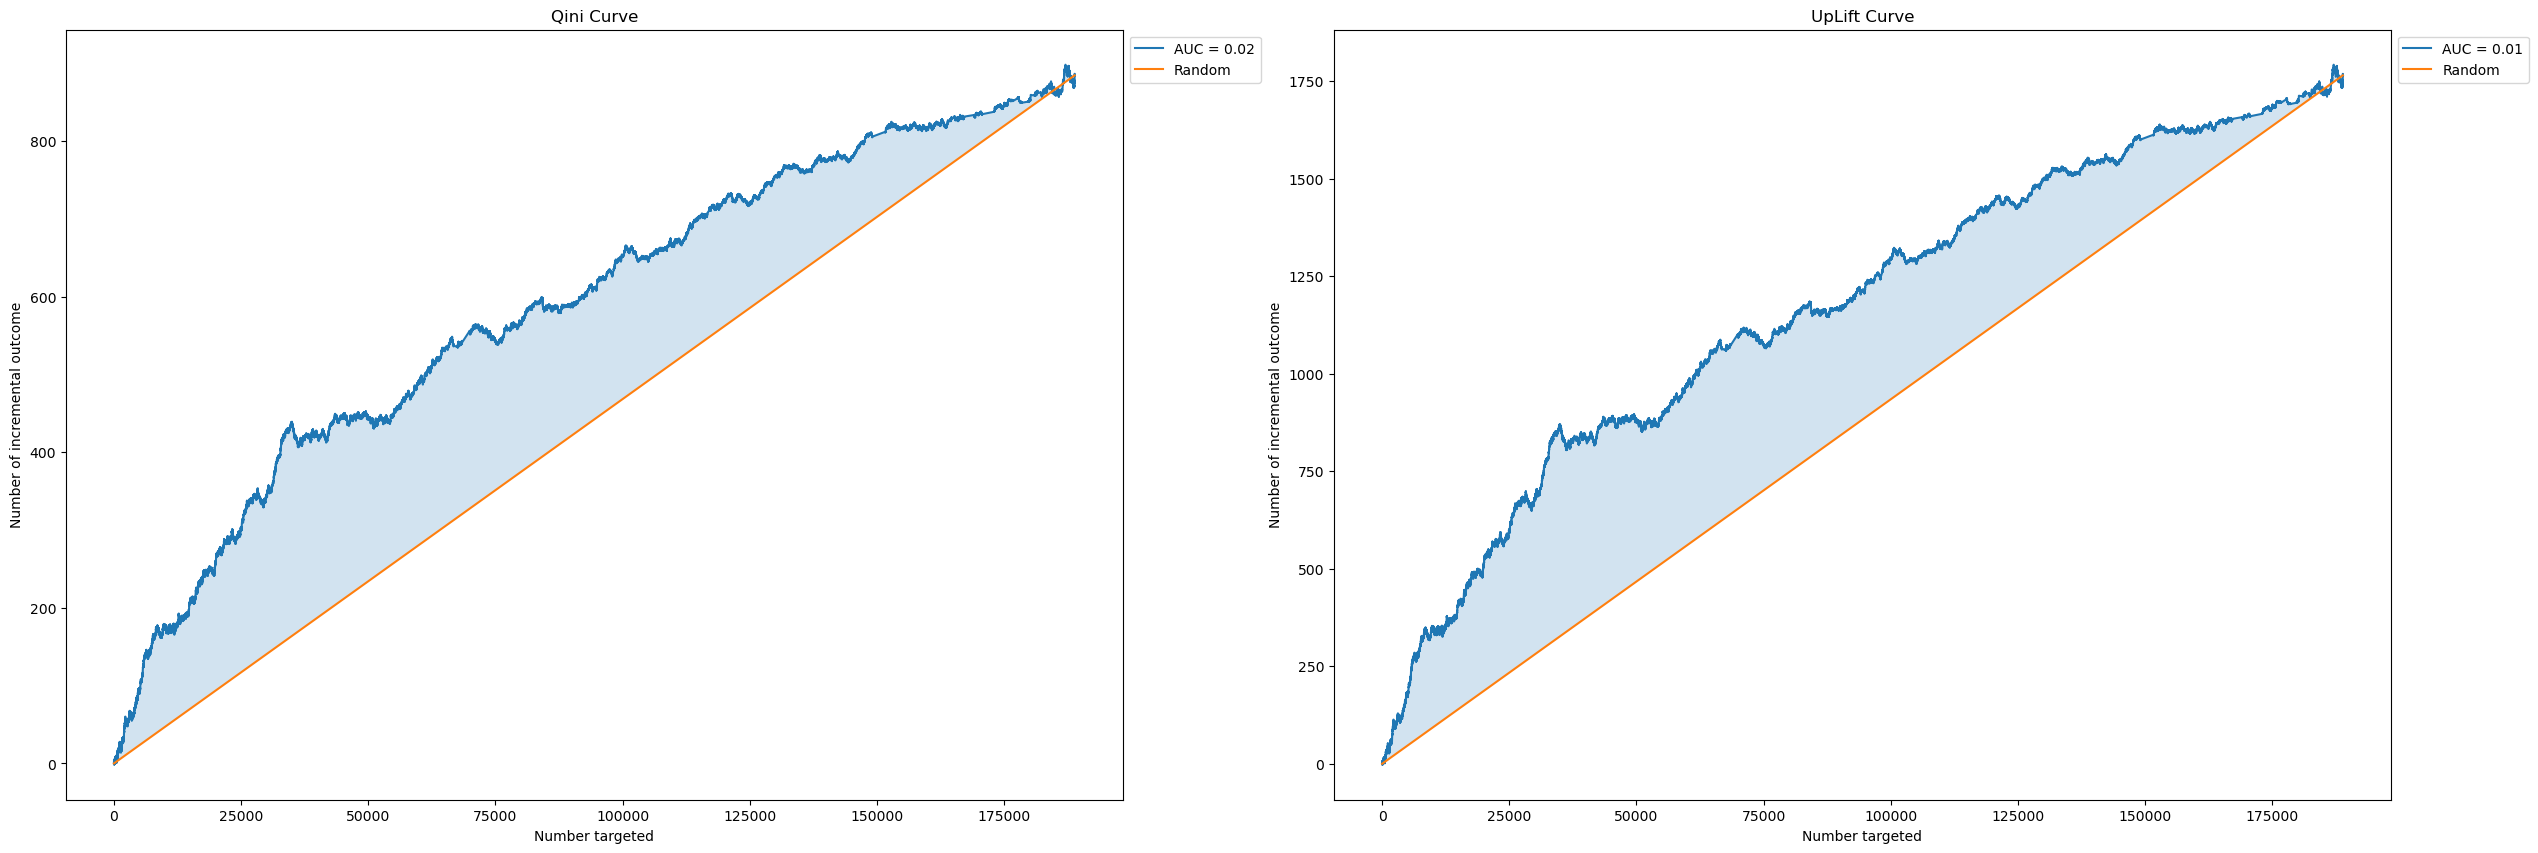

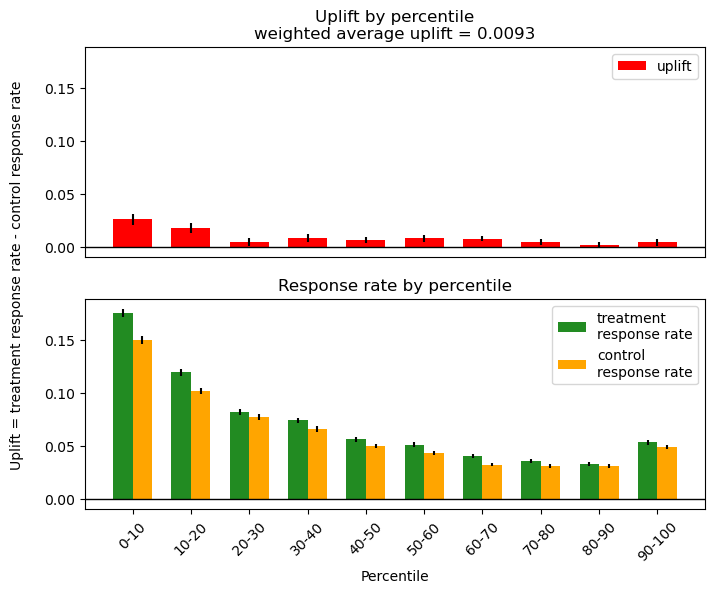

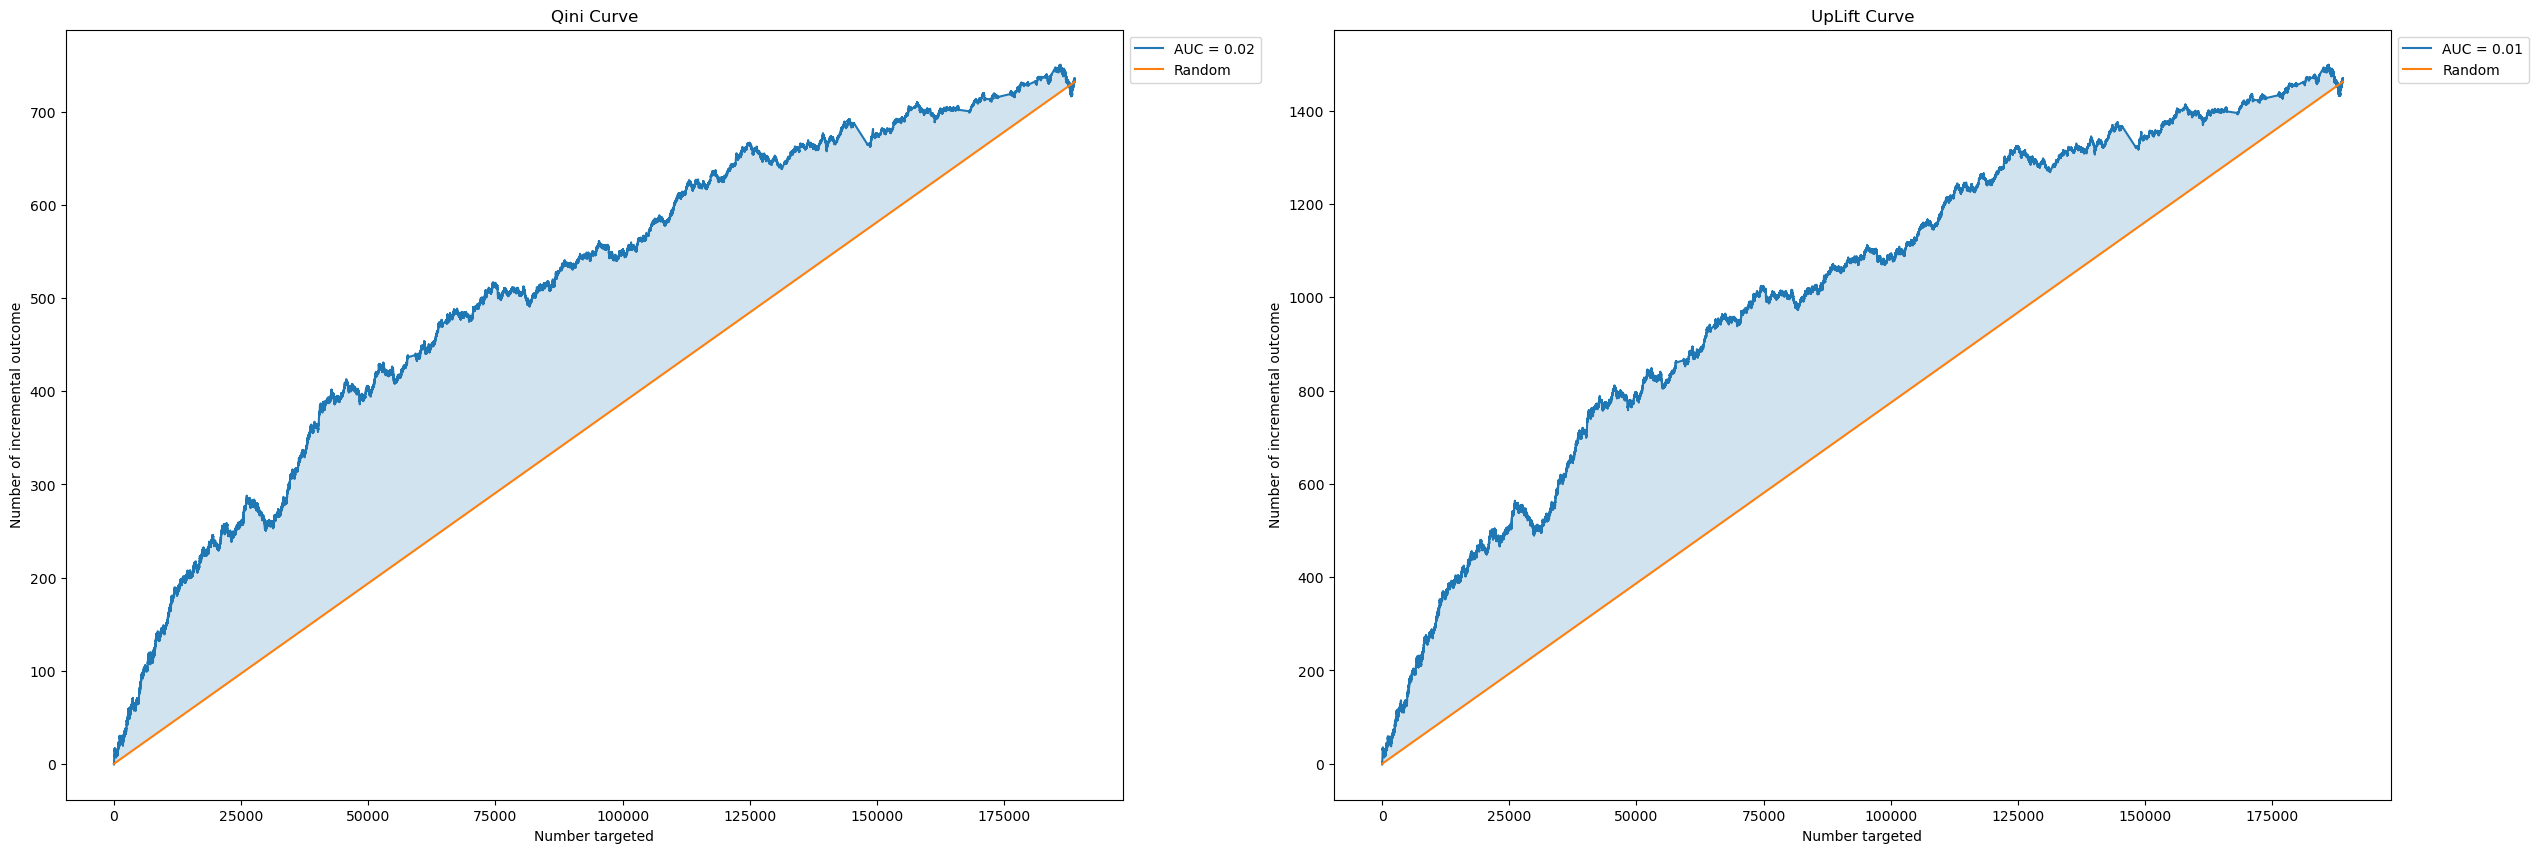

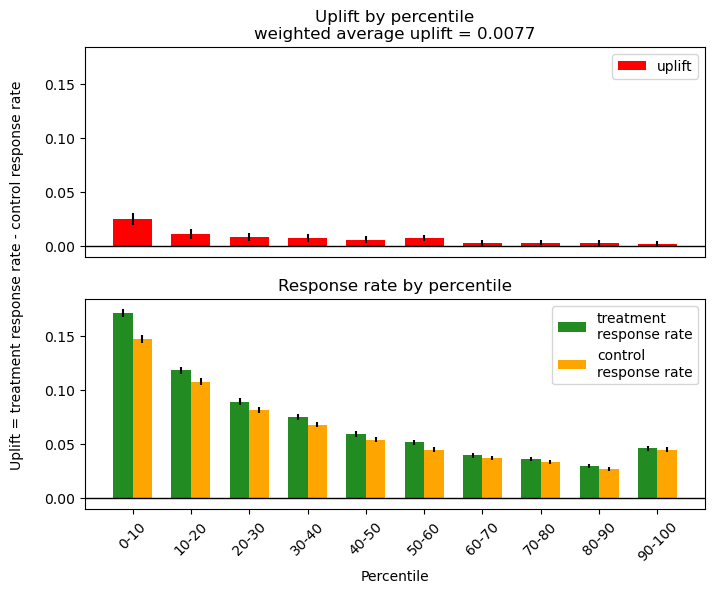

In [11]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k_group':[],  'uplift_k_overall':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_clf = CatBoostClassifier(verbose = 0)
      clf = SoloModel(estimator=catboost_clf)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_group = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='overall', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift at 30% {uplift_overall}; {uplift_group}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/One model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/One model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% =  {uplift_overall}; {uplift_group}')

In [12]:
wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% =  {uplift_overall}; {uplift_group}')

Mean WAU = 0.0081; Mean UpLift 30% =  0.0158; 0.0168


In [13]:
gc.collect()

69447

In [14]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

0

# Метод двух моделей

In [15]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt







var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

Split 1; WAU = 0.007043510924795389; UpLift at 30% 0.012468704704792763; 0.013625083593917925


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.00945753647112595; UpLift at 30% 0.01292360573562136; 0.012510068257881576


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.009042852462453682; UpLift at 30% 0.018023789636994247; 0.01818739719610045


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.009132226872171285; UpLift at 30% 0.0146722873899581; 0.014602033962274219


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.00701526753891339; UpLift at 30% 0.013963648552765814; 0.01489044839572587


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0083; Mean UpLift 30% =  0.0144; 0.0148


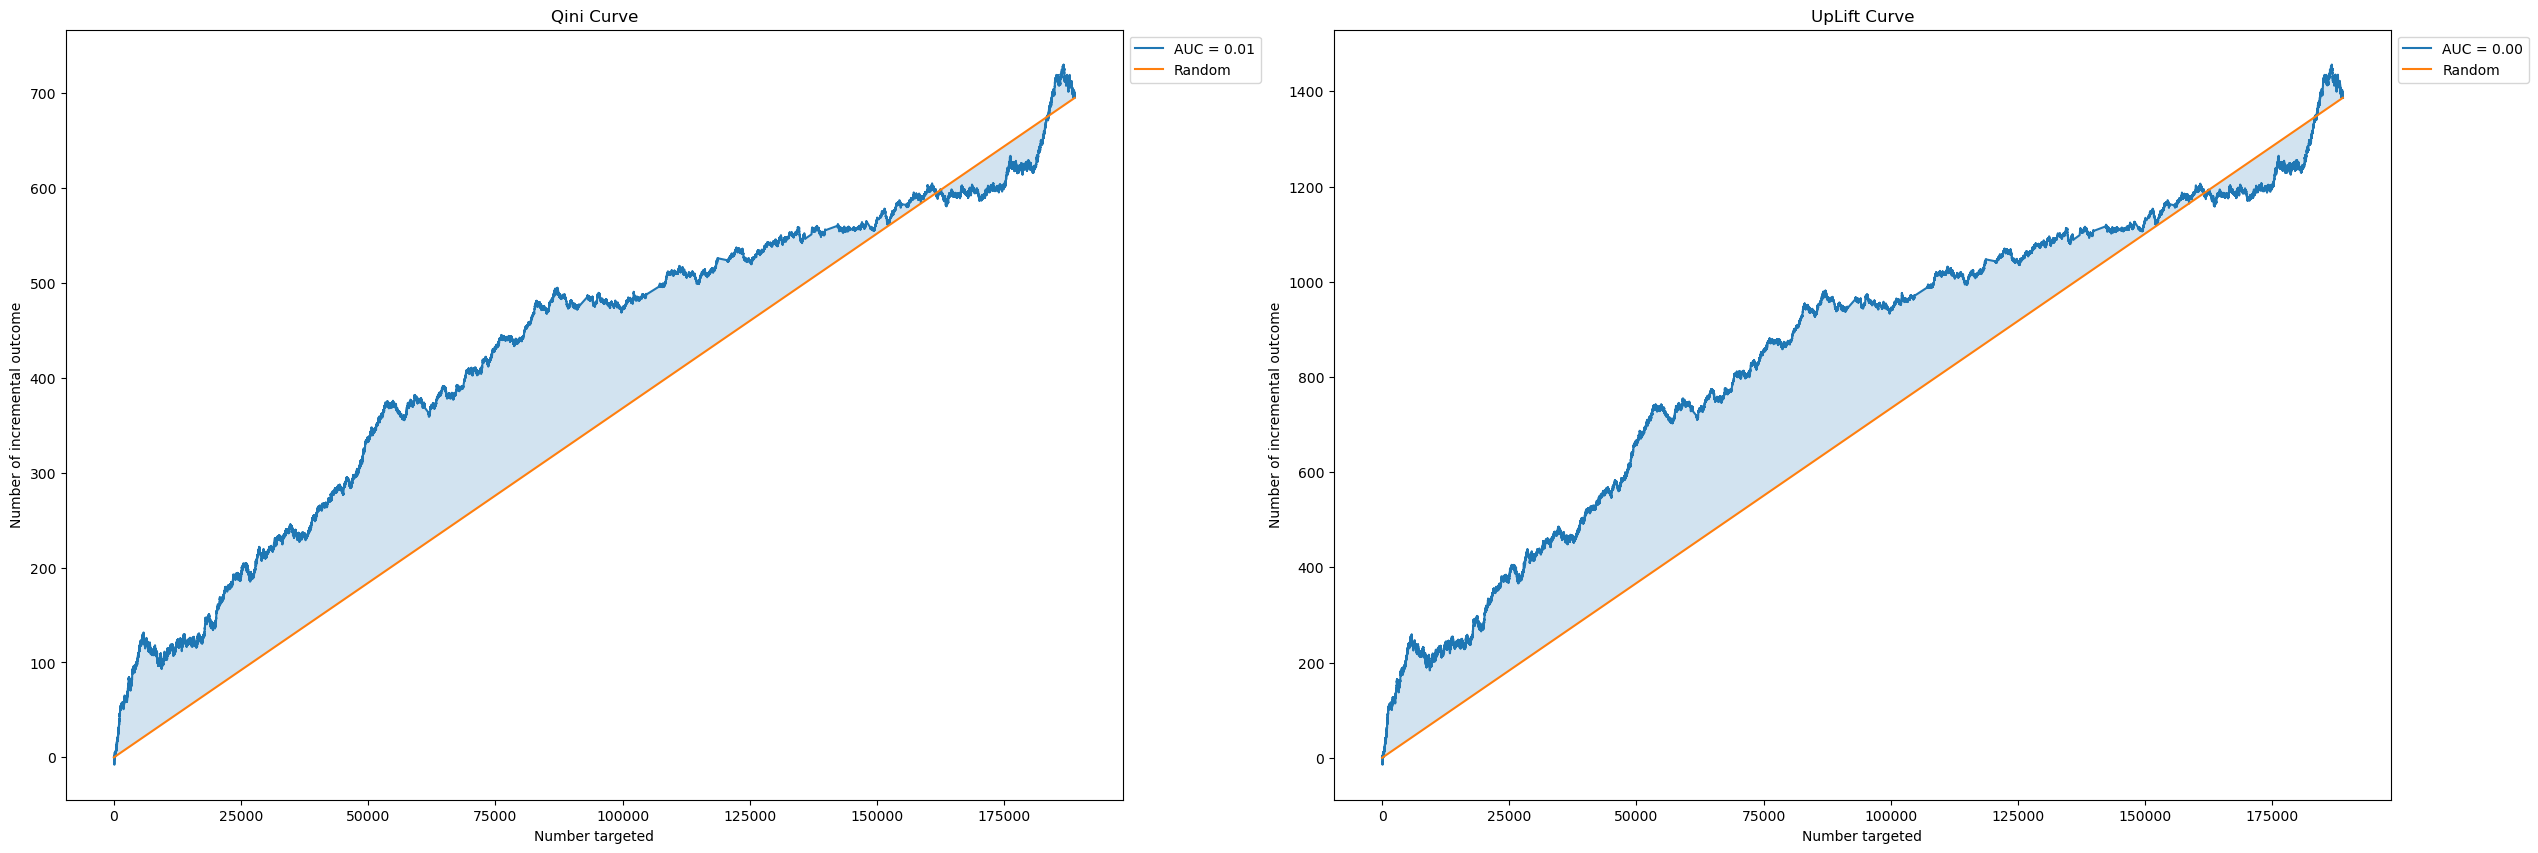

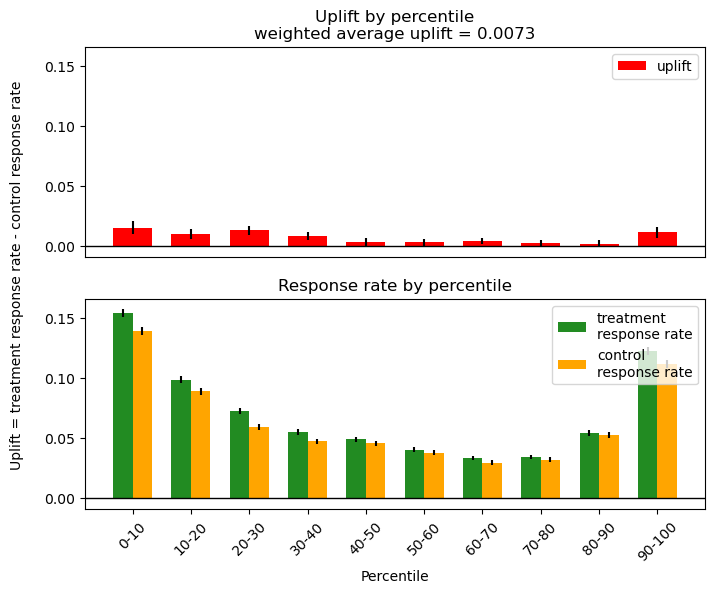

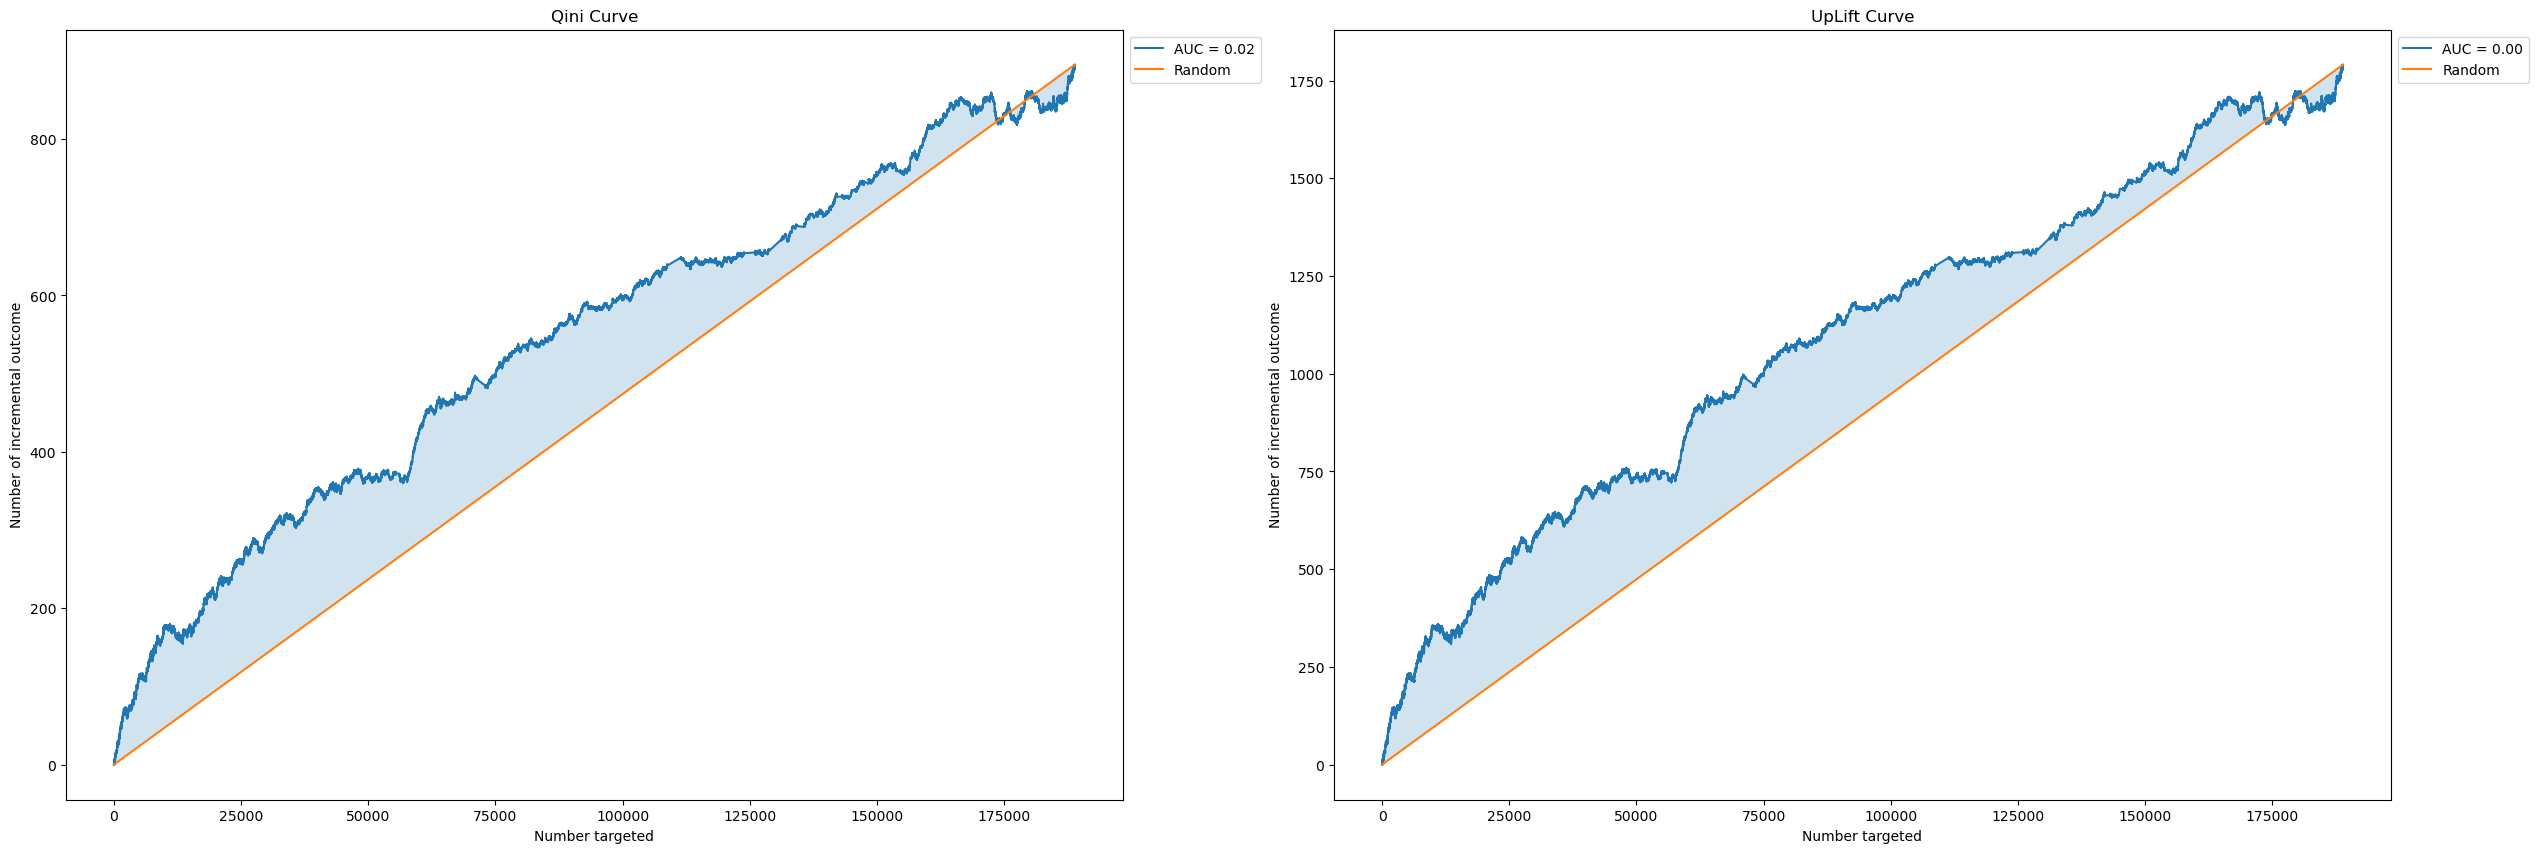

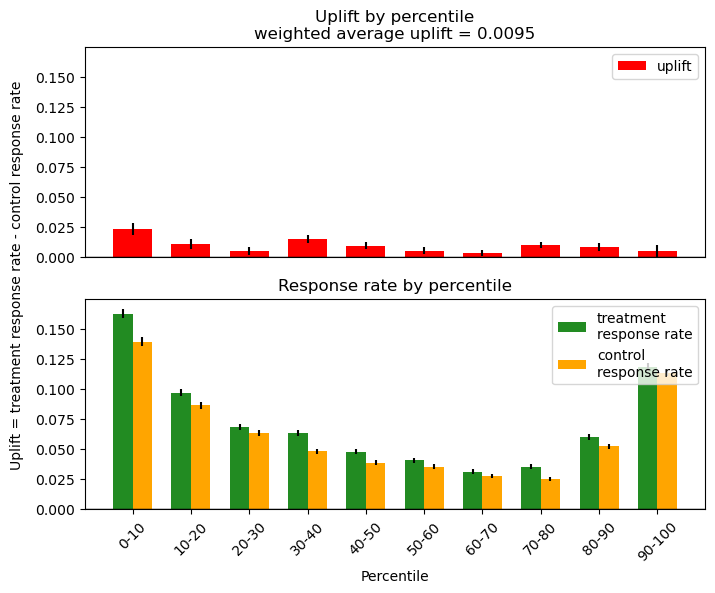

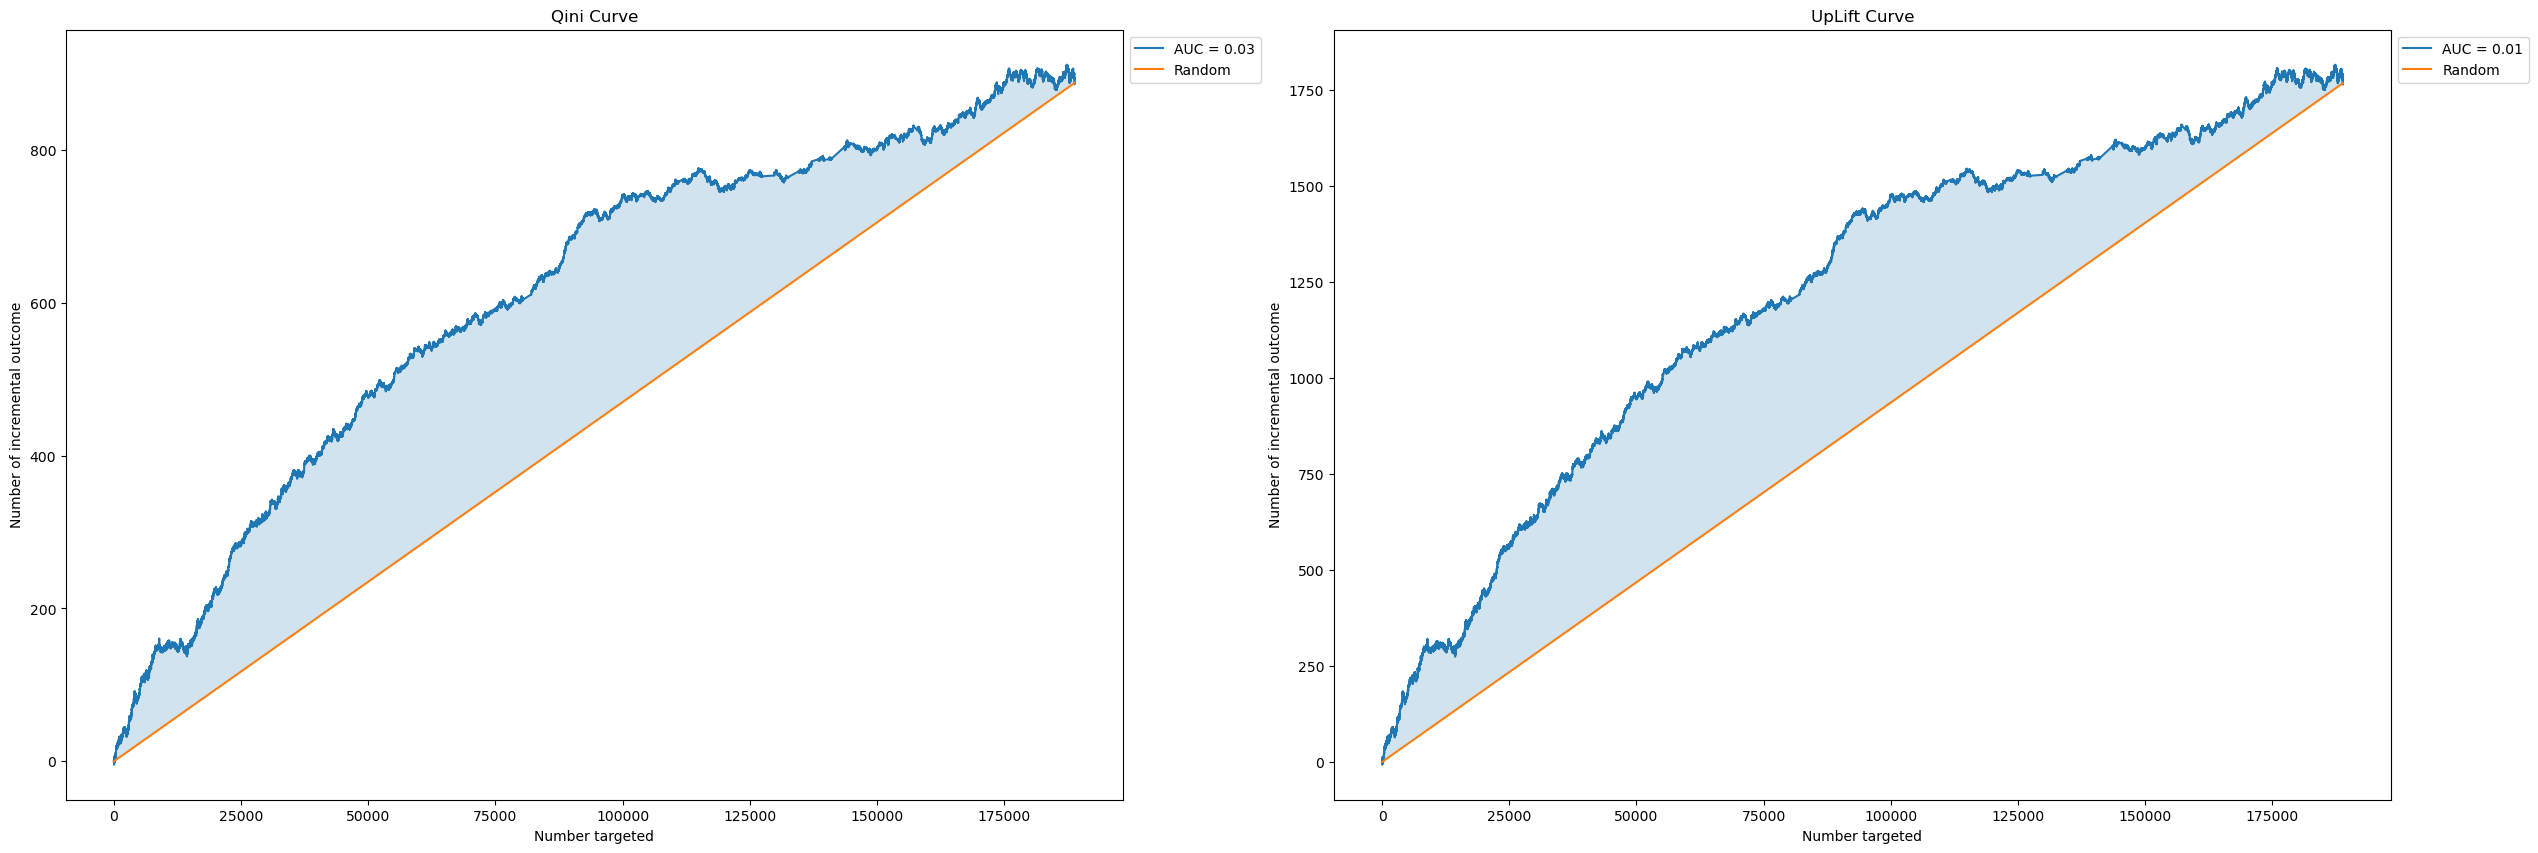

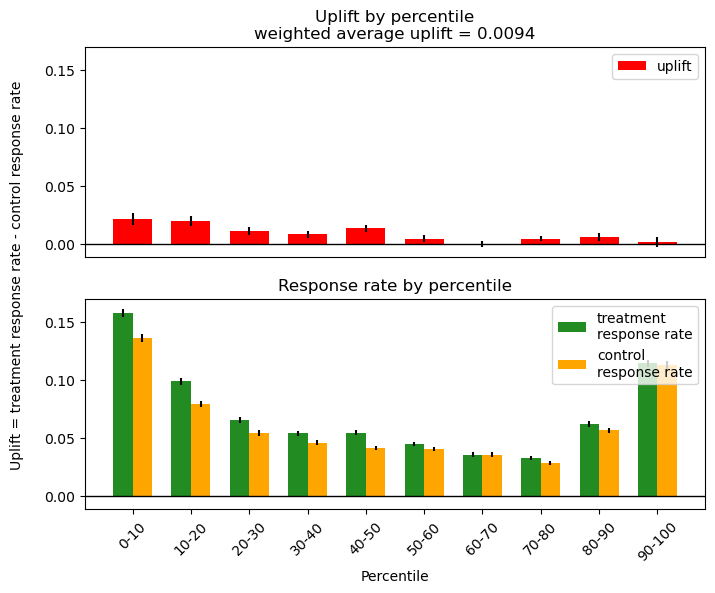

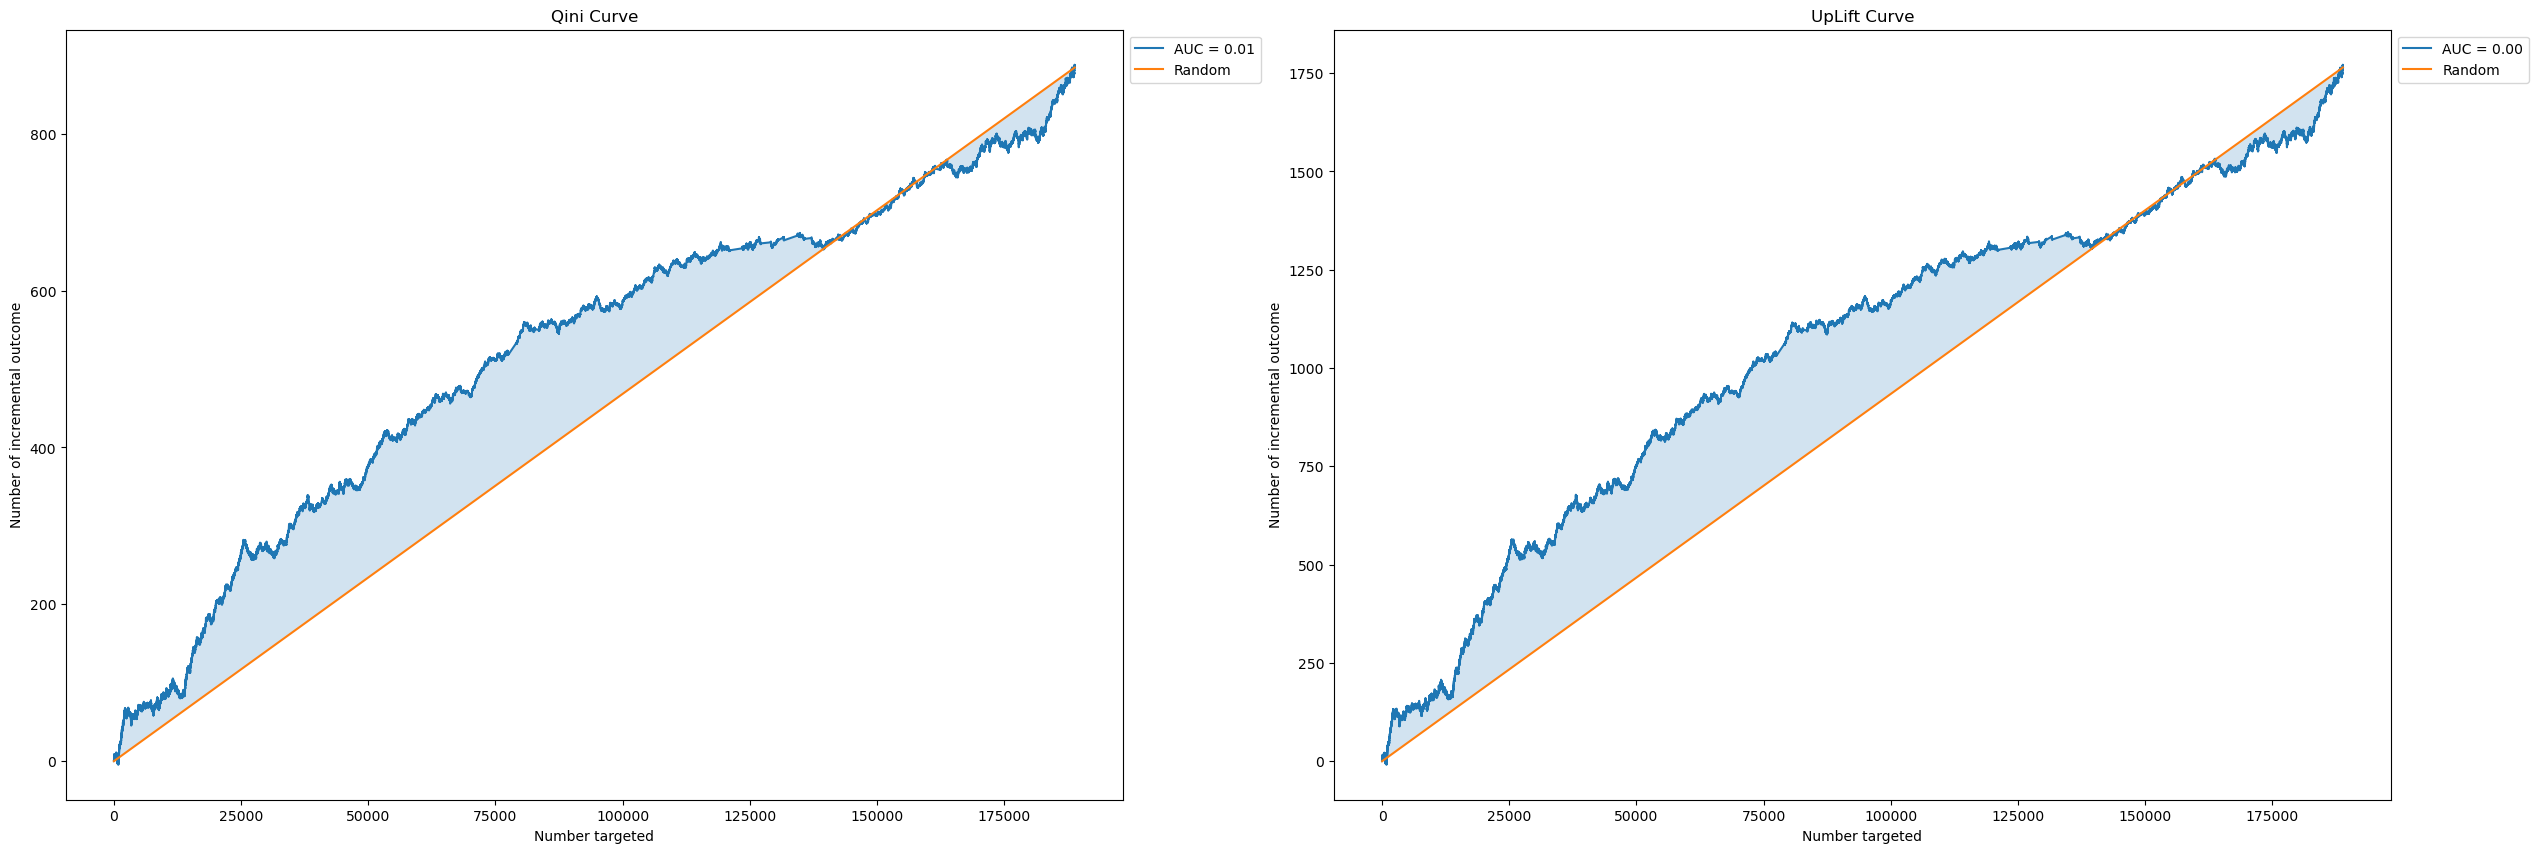

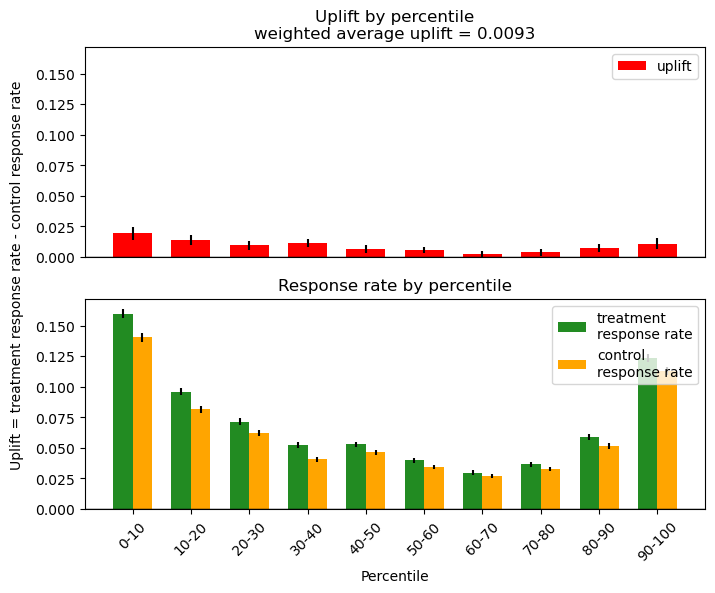

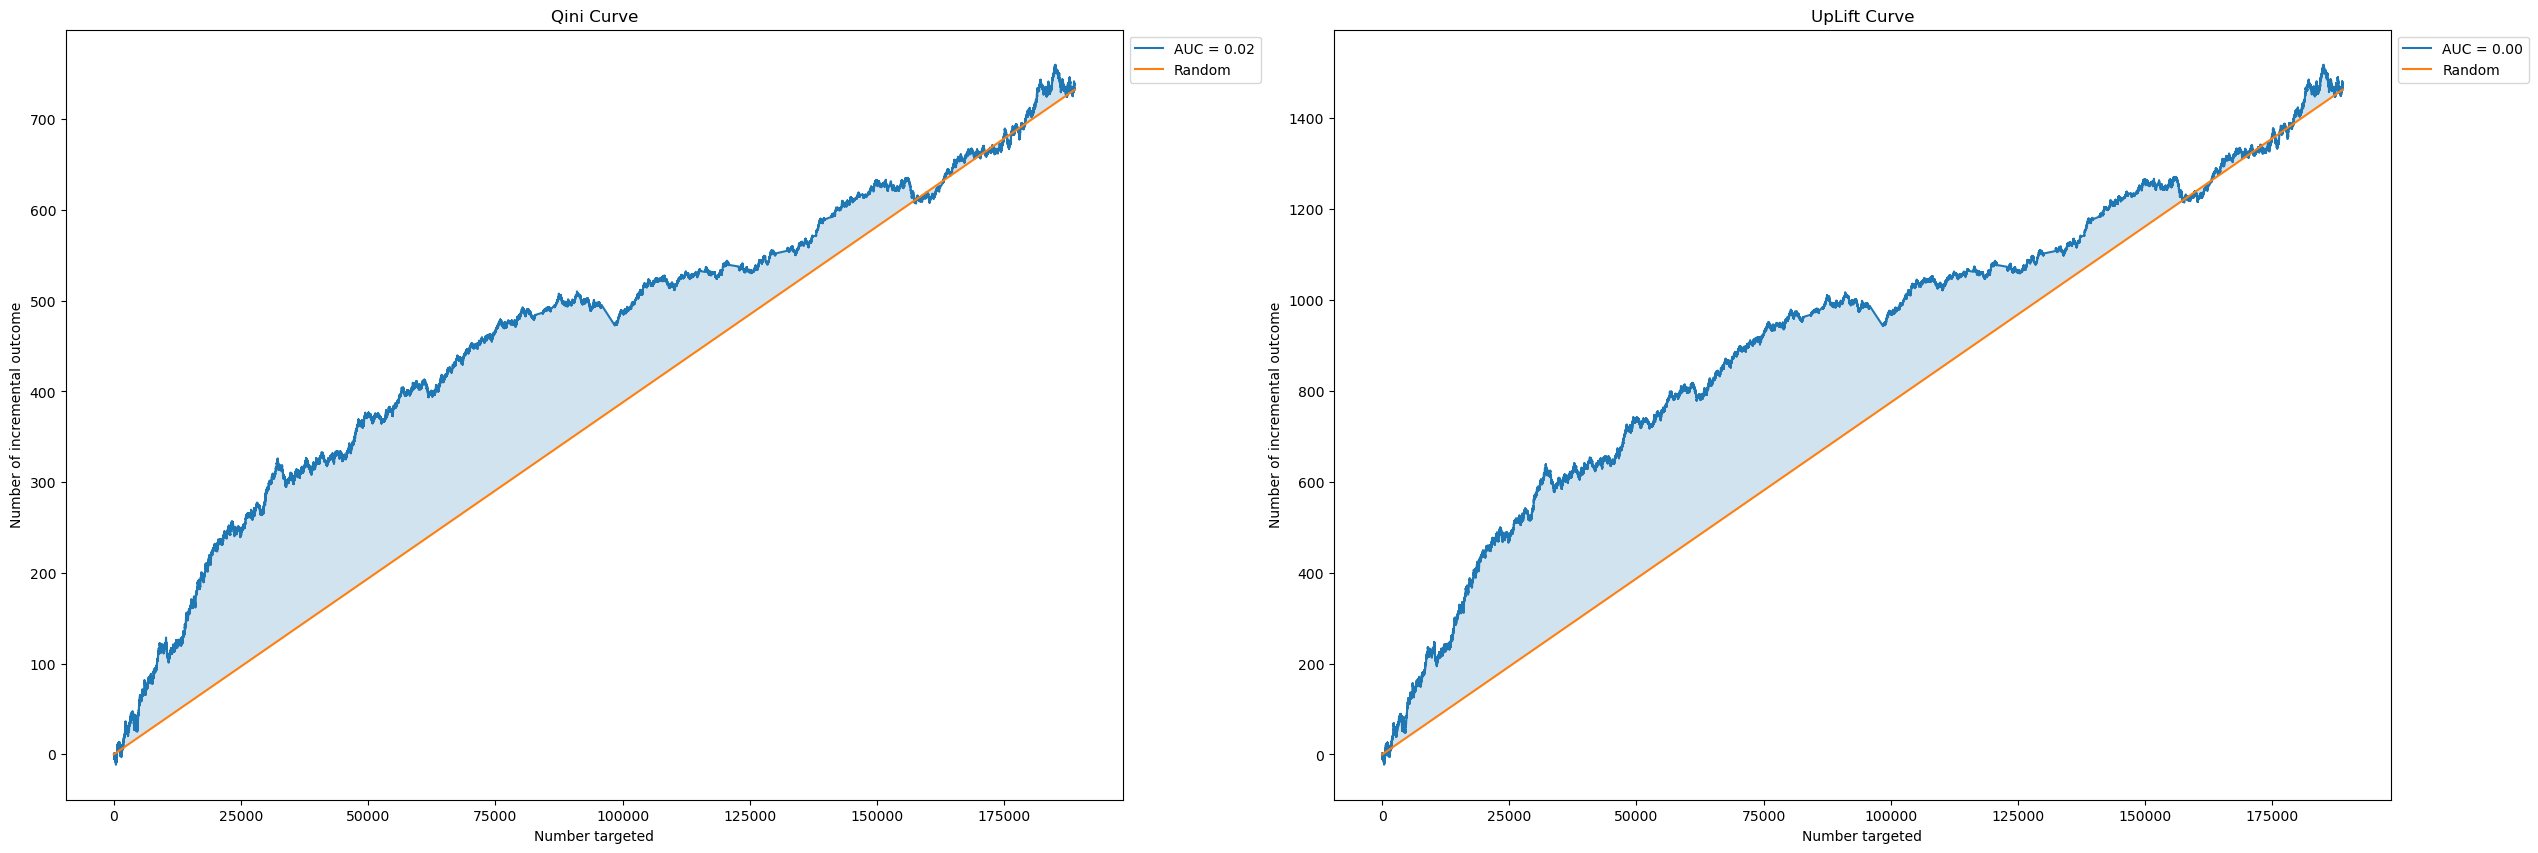

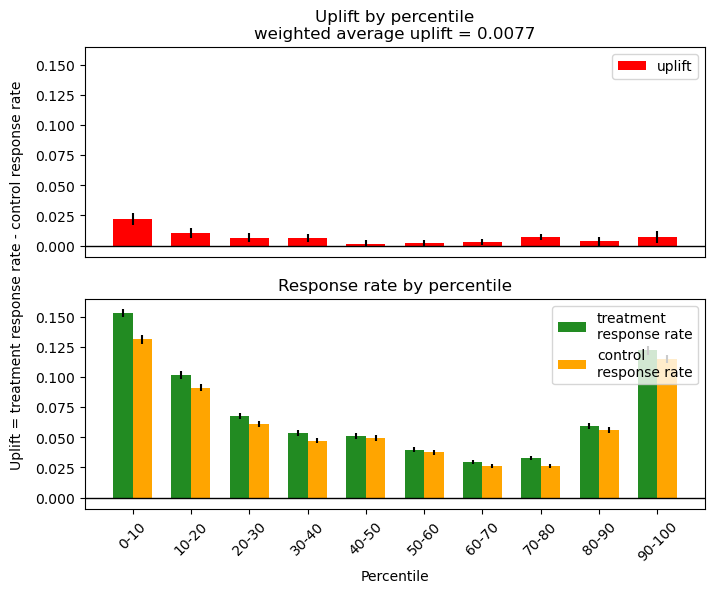

In [16]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k_group':[],  'uplift_k_overall':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_clf0 = CatBoostClassifier(verbose = 0)
      catboost_clf1 = CatBoostClassifier(verbose = 0)
      clf = TwoModels(estimator_ctrl= catboost_clf0, estimator_trmnt=catboost_clf1)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del catboost_clf0
      del catboost_clf1
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_group = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='overall', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift at 30% {uplift_overall}; {uplift_group}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Two models Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Two models Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% =  {uplift_overall}; {uplift_group}')

In [17]:
wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% =  {uplift_overall}; {uplift_group}')

Mean WAU = 0.0083; Mean UpLift 30% =  0.0144; 0.0148


In [18]:
del X_data
del Y_data
del treat
del y
gc.collect()

70561

# Метод трансформации класса (Классификация)

In [19]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X)
print(y)
print(p)






var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

[[1.00000e+00 0.00000e+00 0.00000e+00 ... 1.33248e-01 6.12000e-04
  1.32788e-01]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 9.99200e-01 0.00000e+00
  9.99200e-01]
 ...
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
[0 0 0 ... 0 0 0]
0.5011176183452472


Split 1; WAU = 0.007507541414978178; UpLift at 30% 0.011930076629939765; 0.010220476713081211


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.009622736303050427; UpLift at 30% 0.012346094741998367; 0.012142756433916477


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.009598869589441152; UpLift at 30% 0.012176717007646568; 0.011830617344092478


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.009619247291717228; UpLift at 30% 0.01444006839798212; 0.013625234009494044


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.008035274522083472; UpLift at 30% 0.01125084770946469; 0.010328821818096773


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0089; Mean UpLift 30% =  0.0124; 0.0116


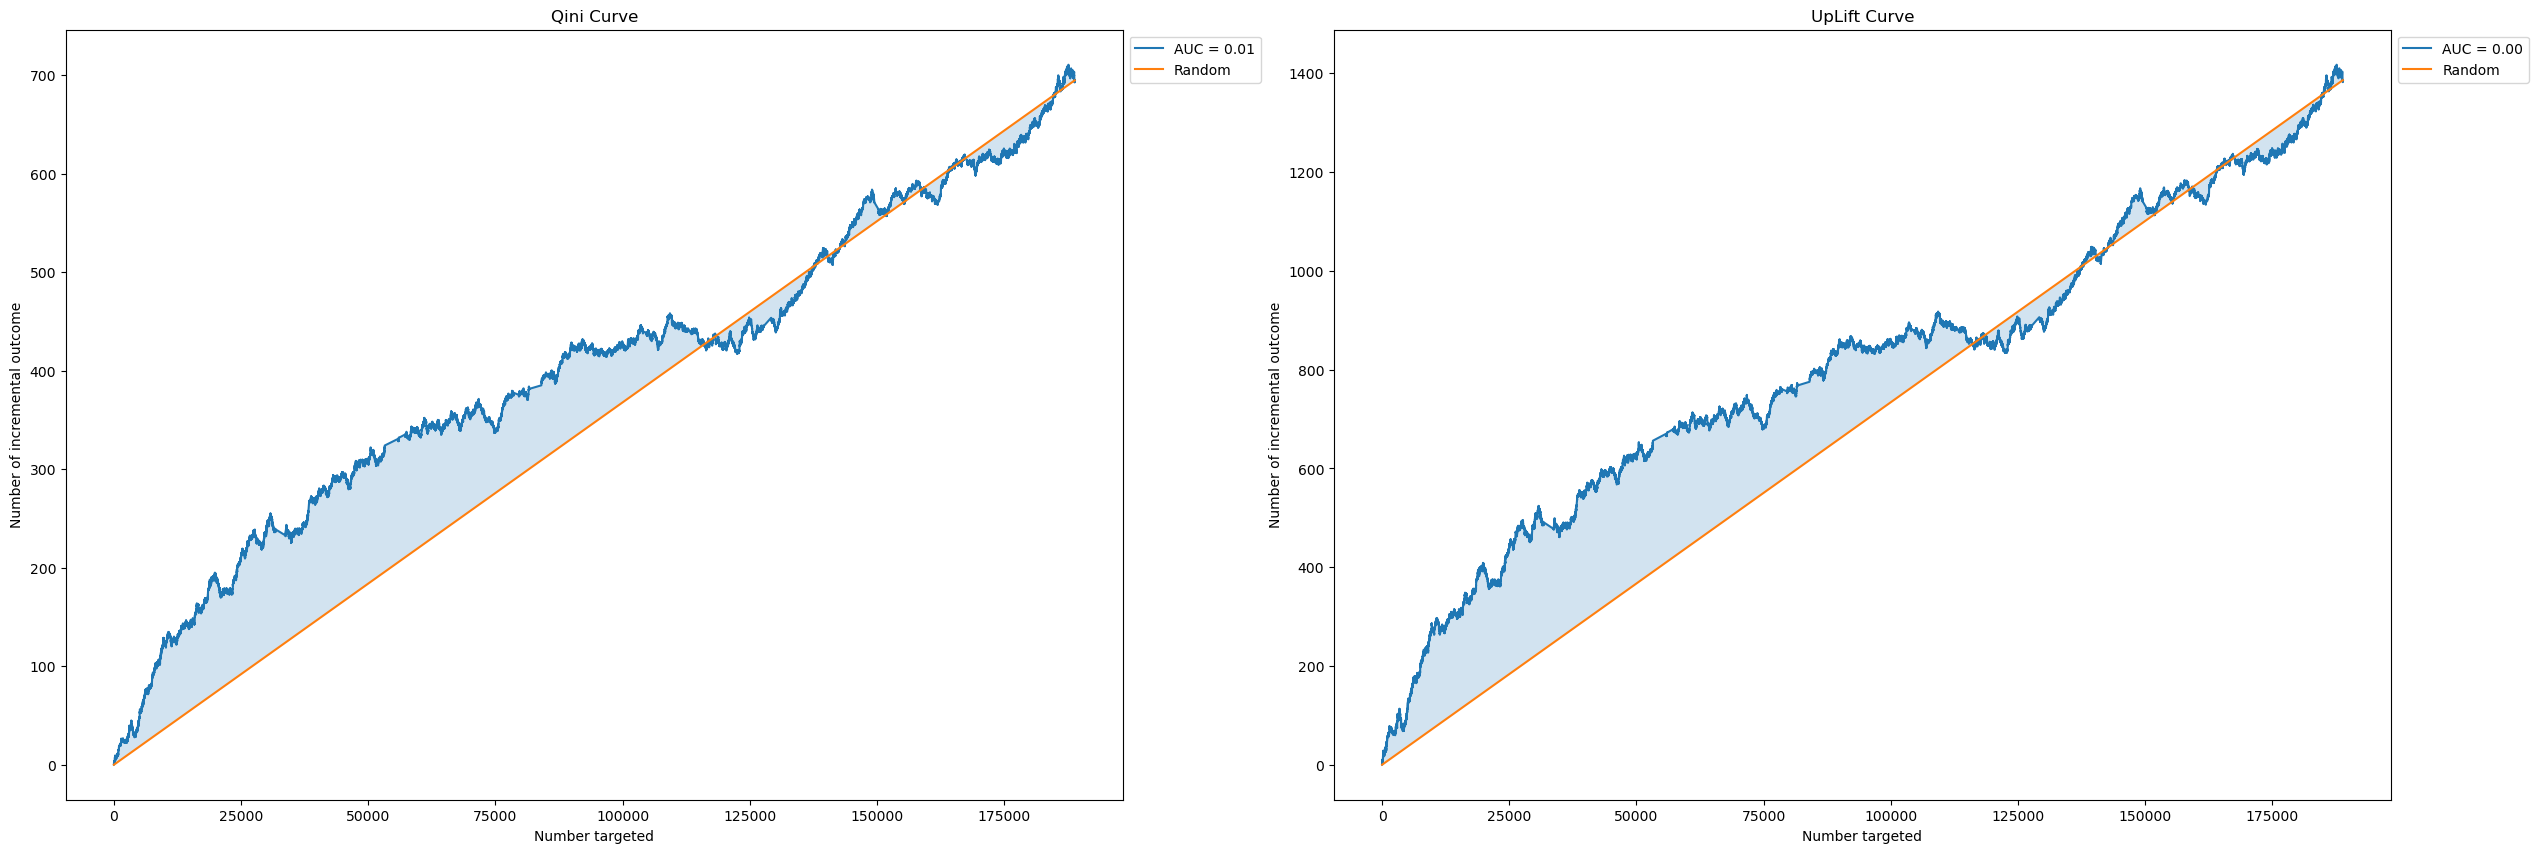

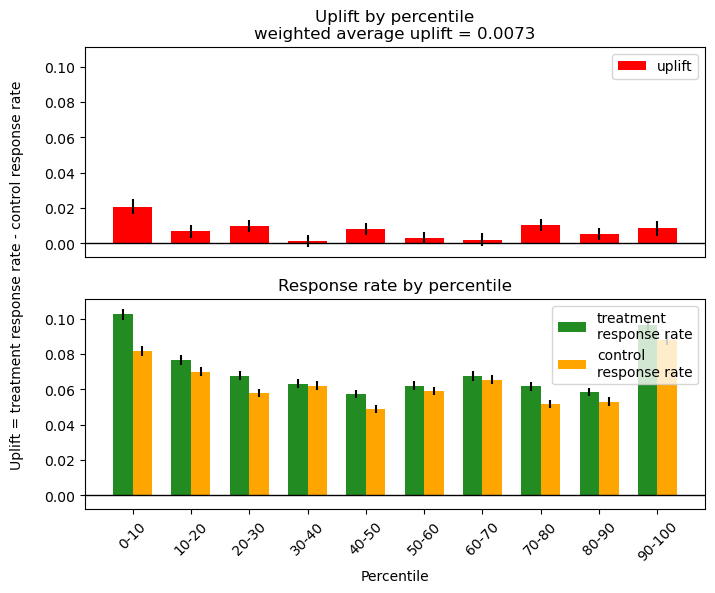

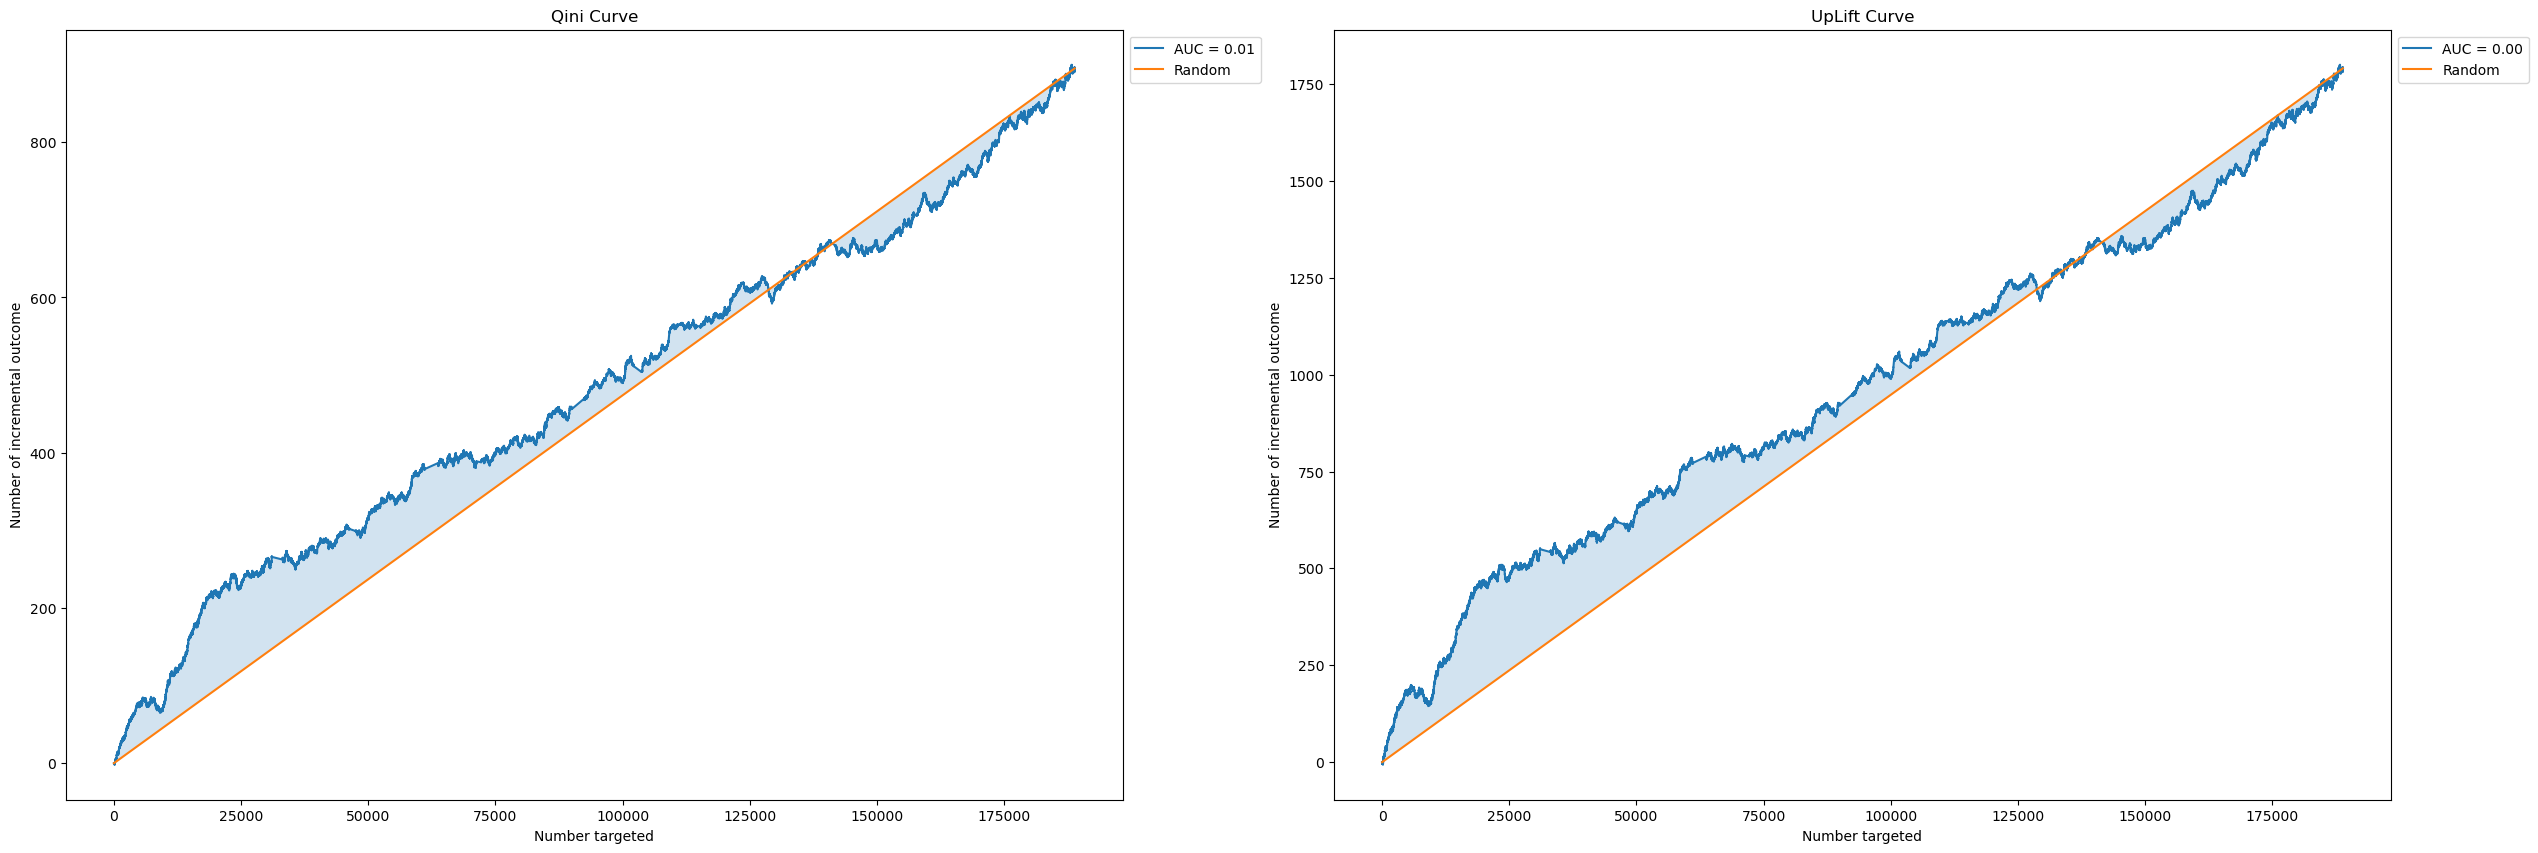

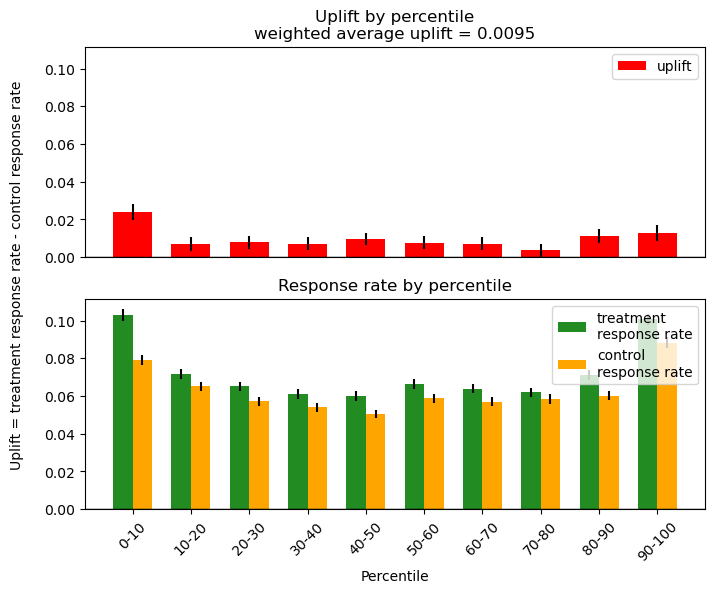

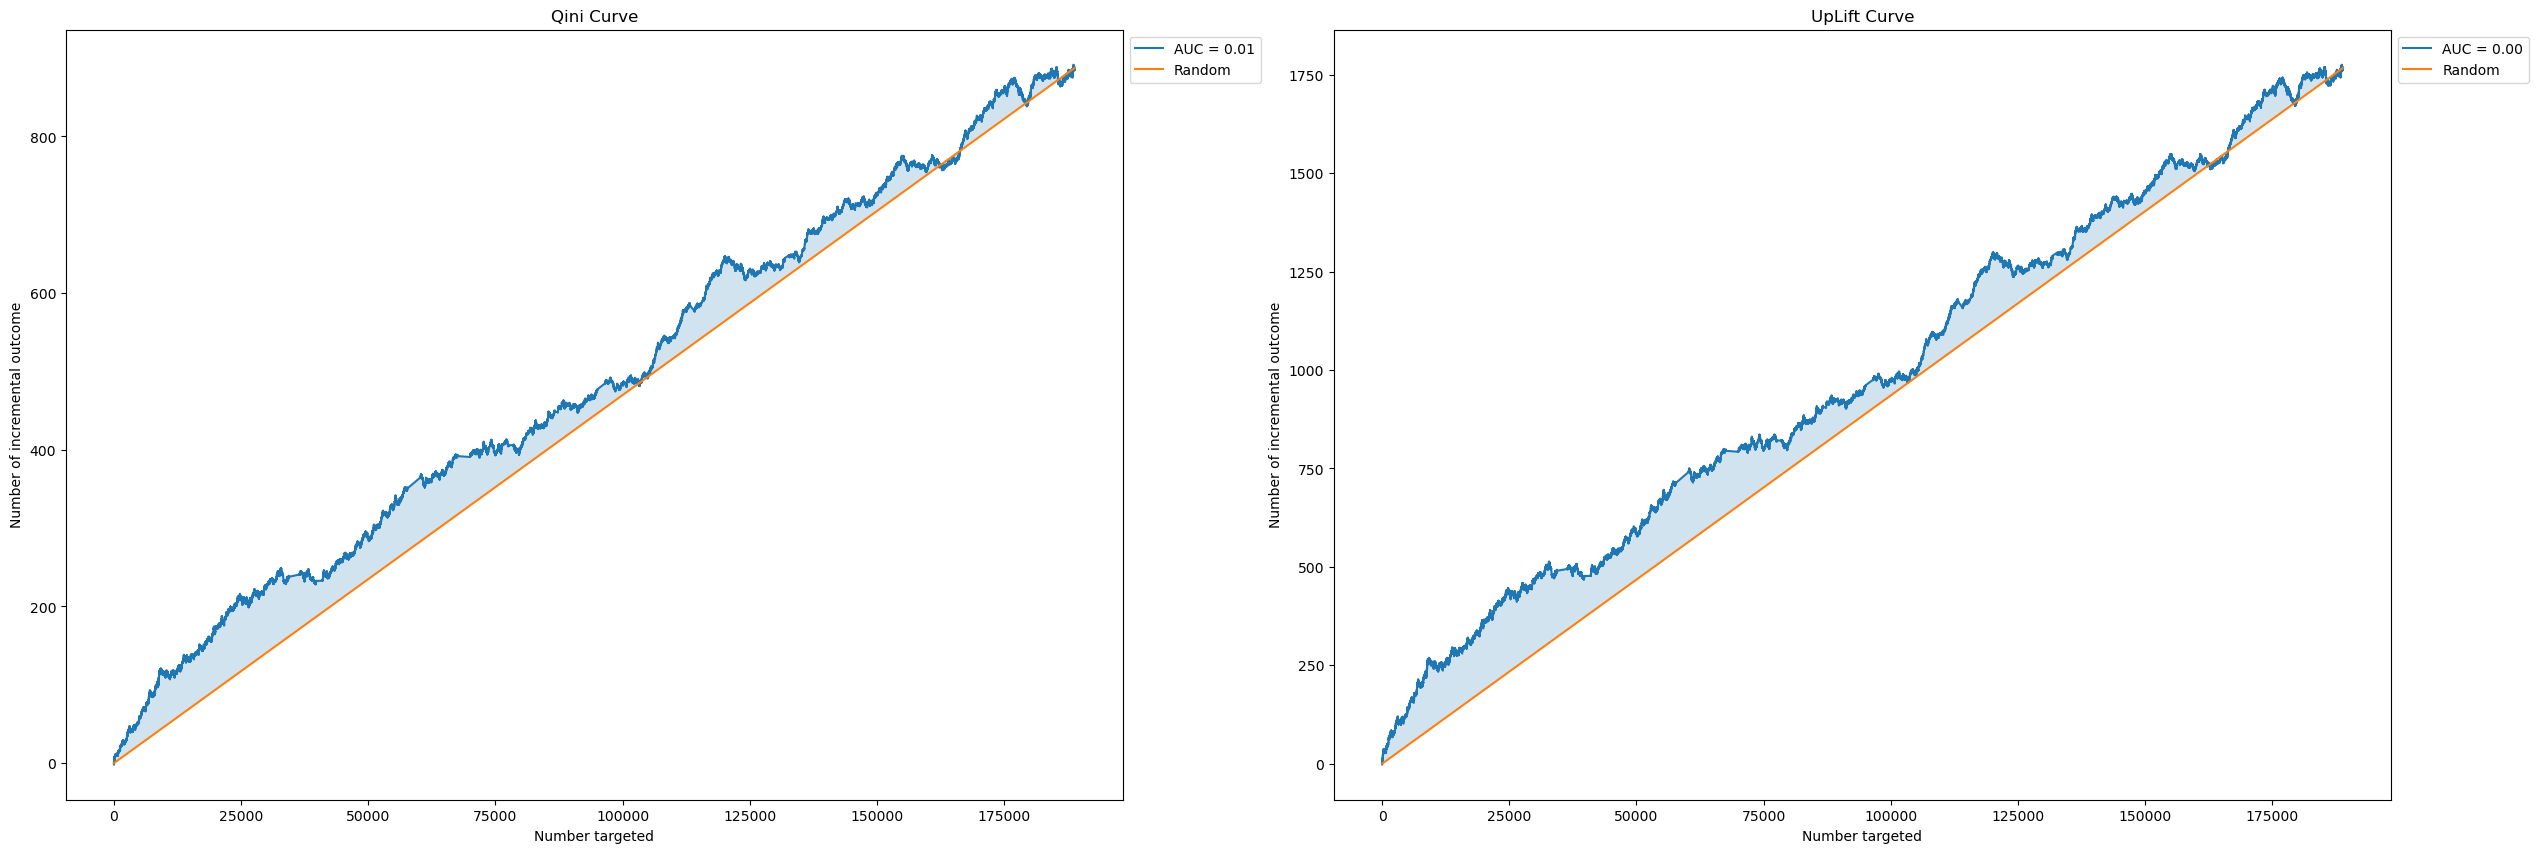

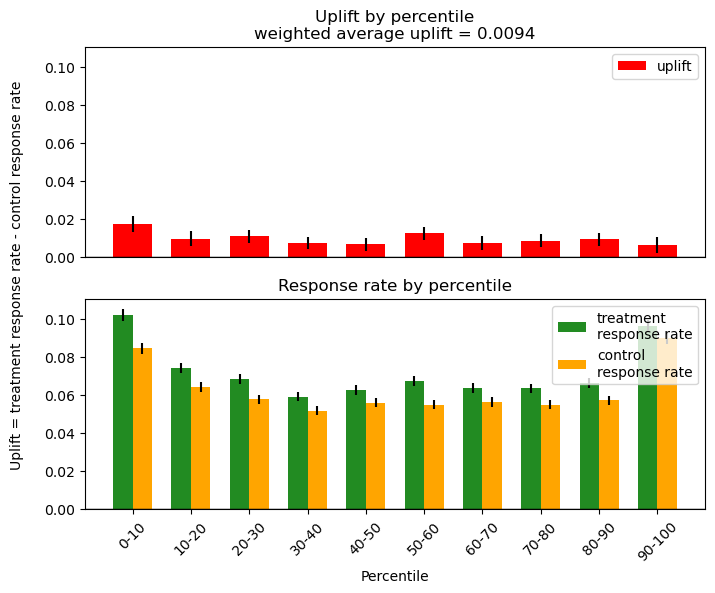

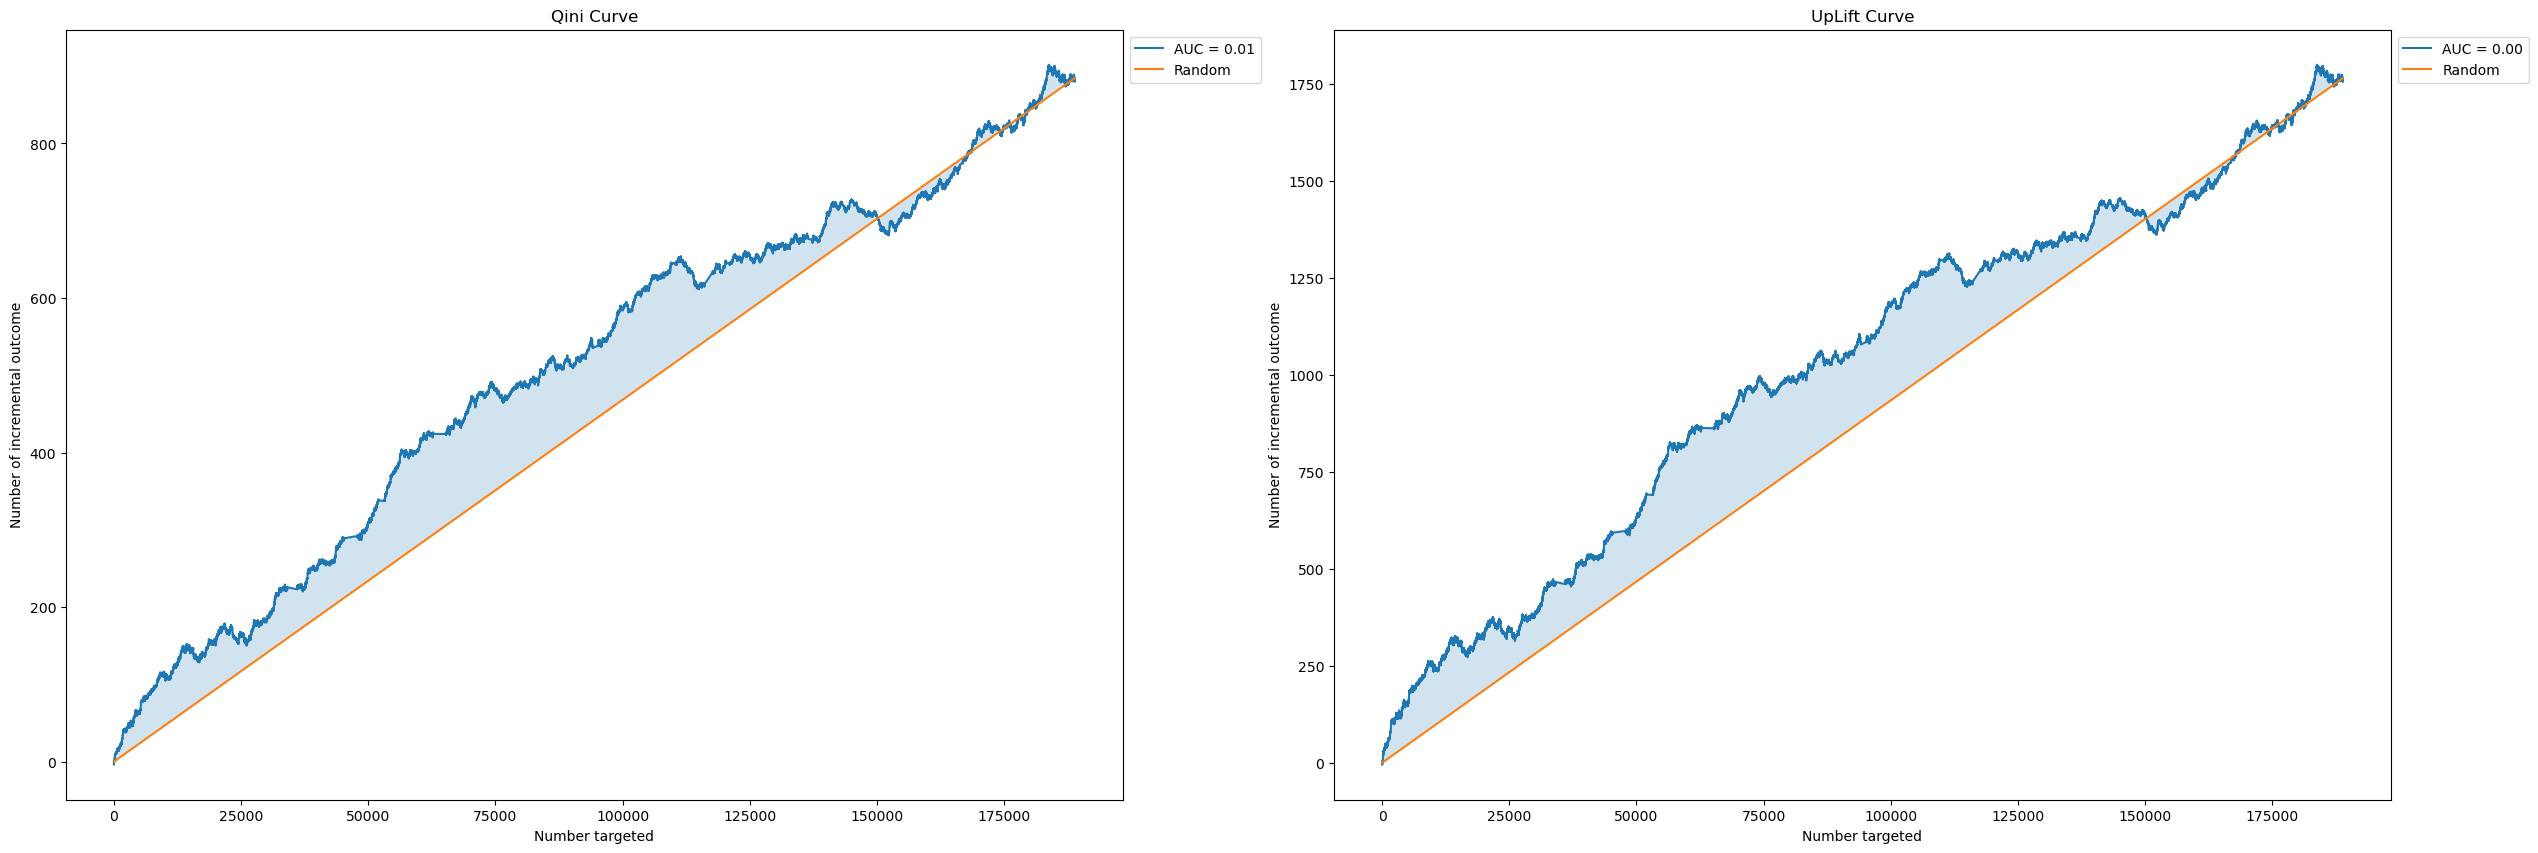

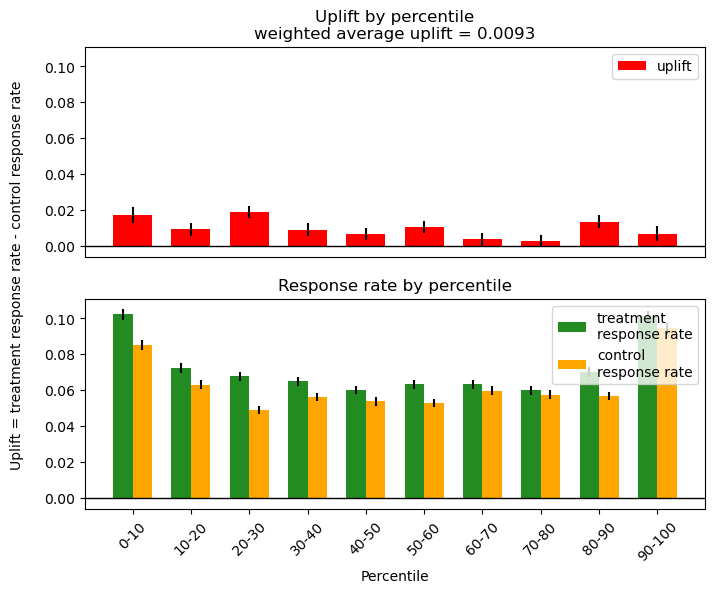

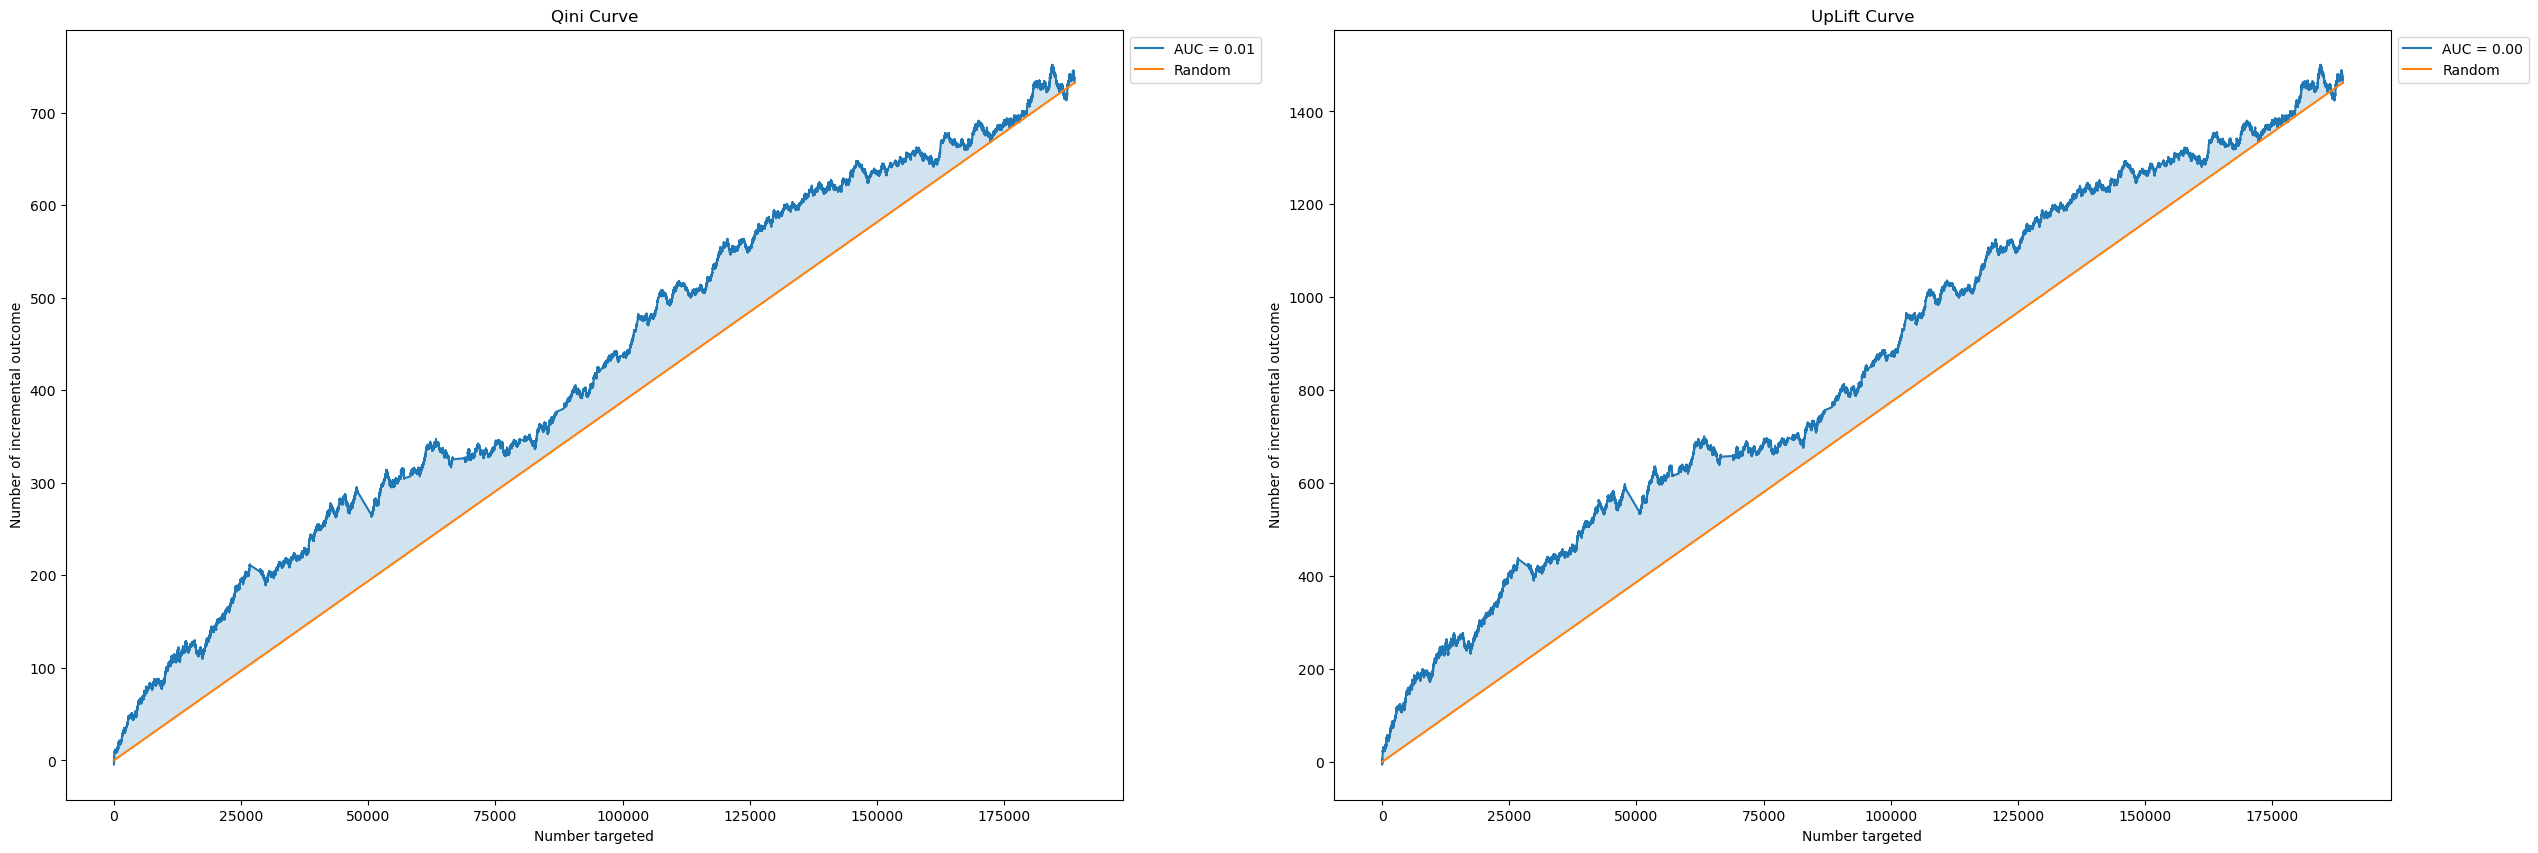

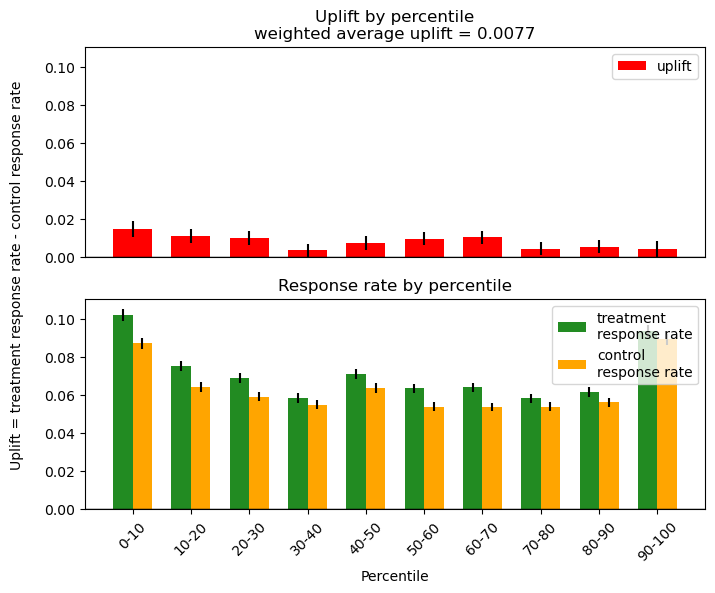

In [20]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k_group':[],  'uplift_k_overall':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_clf = CatBoostClassifier(verbose = 0)
      clf = ClassTransformation(estimator=catboost_clf)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_group = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='overall', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift at 30% {uplift_overall}; {uplift_group}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Trasnform Class model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Trasnform Class model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% =  {uplift_overall}; {uplift_group}')

In [21]:
wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% =  {uplift_overall}; {uplift_group}')

Mean WAU = 0.0089; Mean UpLift 30% =  0.0124; 0.0116


In [22]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

70579

# Метод трансформации класса (Регрессия)

In [23]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X)
print(y)
print(p)






var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

[[1.00000e+00 0.00000e+00 0.00000e+00 ... 1.33248e-01 6.12000e-04
  1.32788e-01]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 9.99200e-01 0.00000e+00
  9.99200e-01]
 ...
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
[0 0 0 ... 0 0 0]
0.5011176183452472


Split 1; WAU = 0.007264190505855881; UpLift at 30% 0.0114671498604806; 0.012776629556812191


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.009578784818518411; UpLift at 30% 0.015657232570330165; 0.01589848065379916


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.009288883214940629; UpLift at 30% 0.01481192459968883; 0.015136951352043196


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.009148512945444736; UpLift at 30% 0.01428418798759773; 0.014917549189715704


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.007359932562952453; UpLift at 30% 0.01291250410445452; 0.013369914923759635


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0085; Mean UpLift 30% =  0.0138; 0.0144


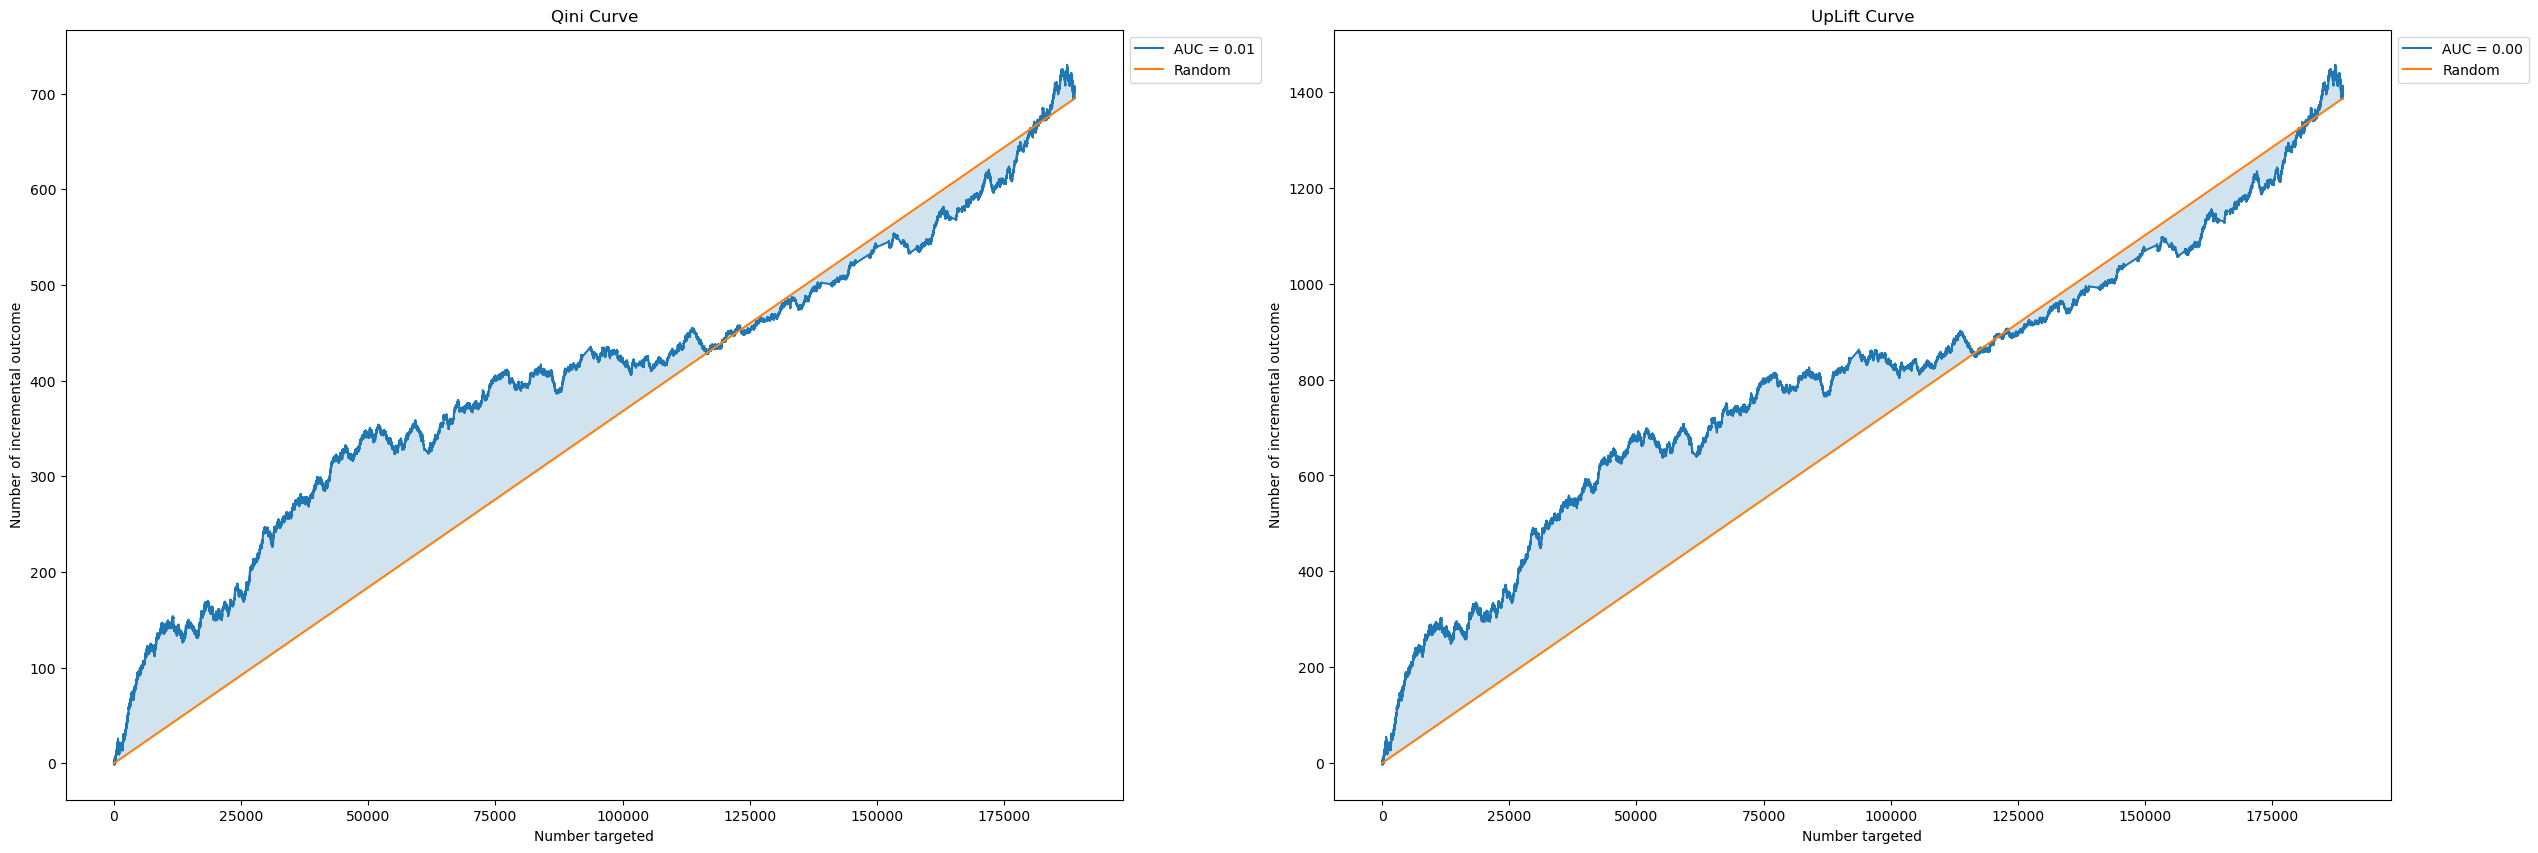

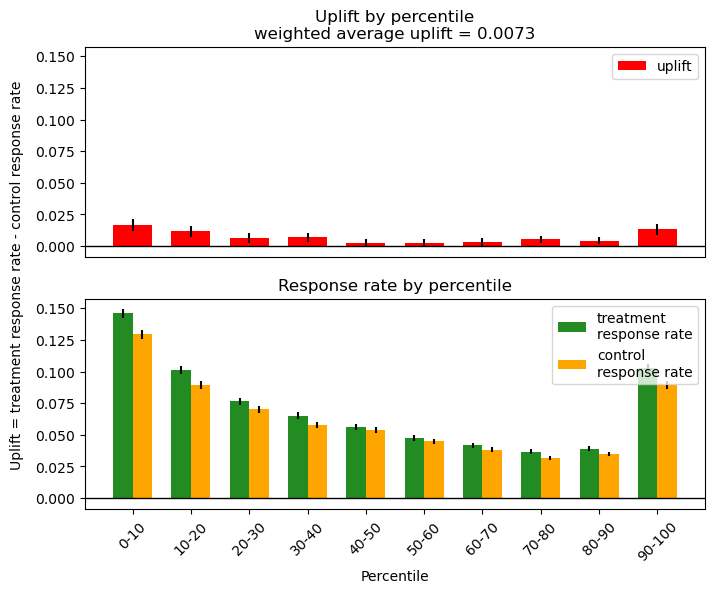

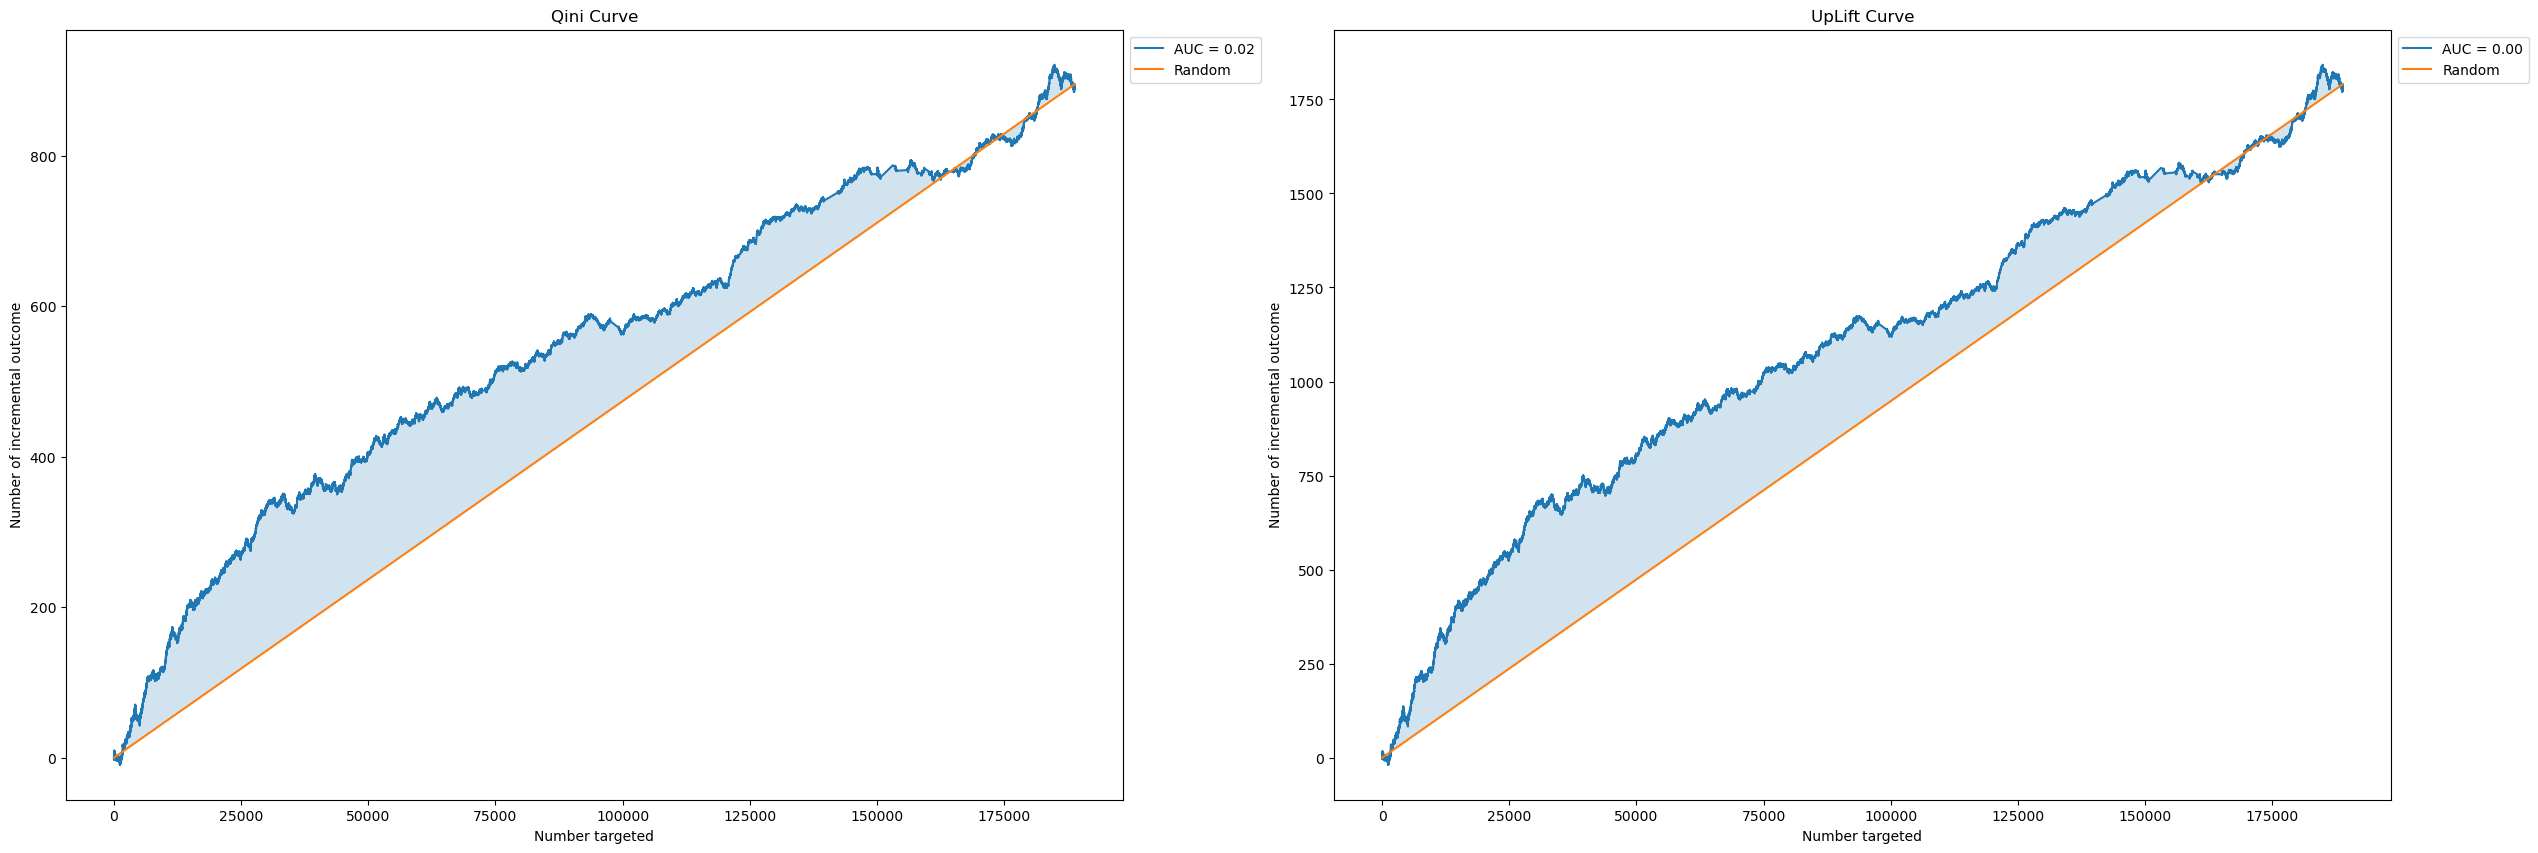

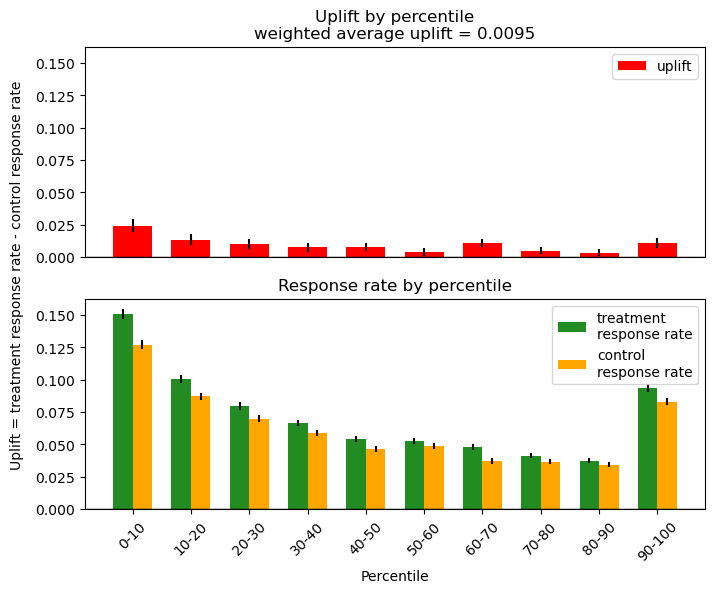

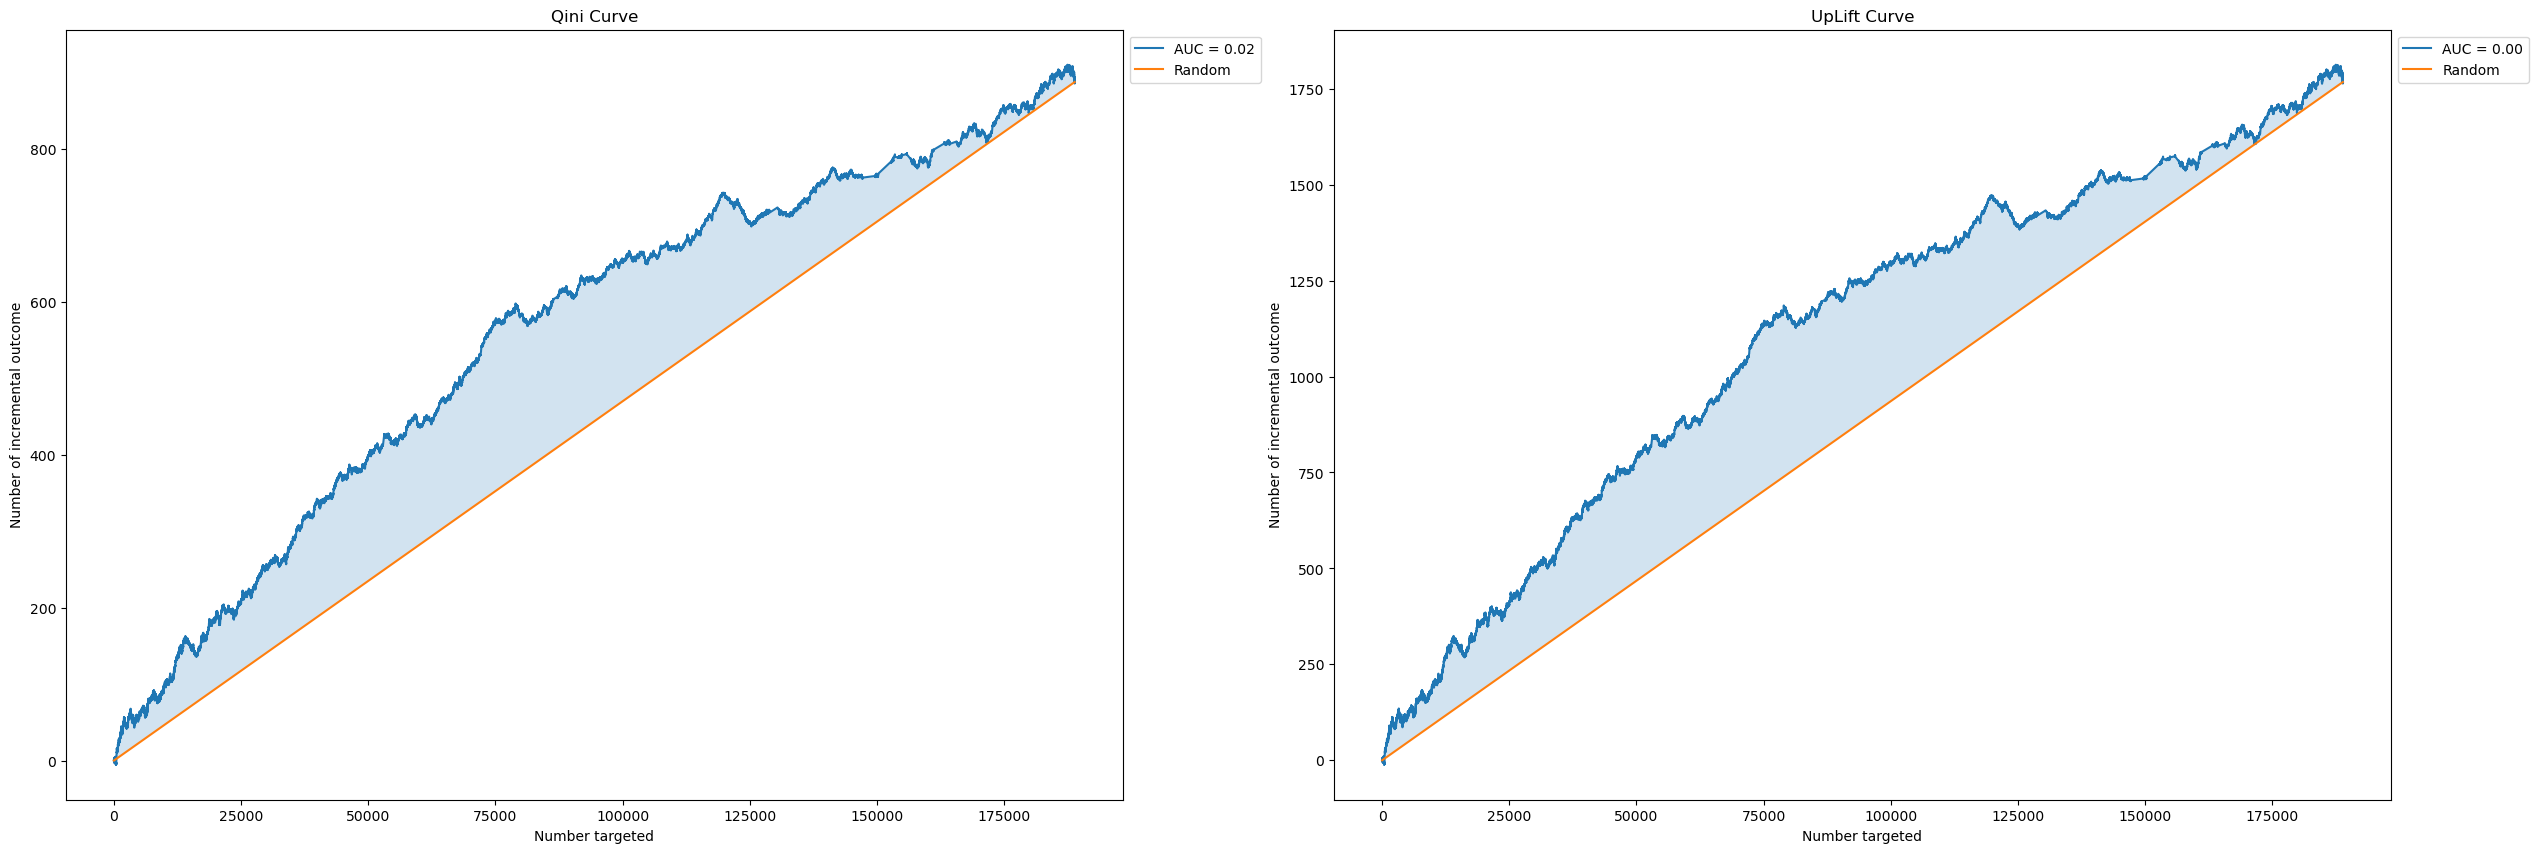

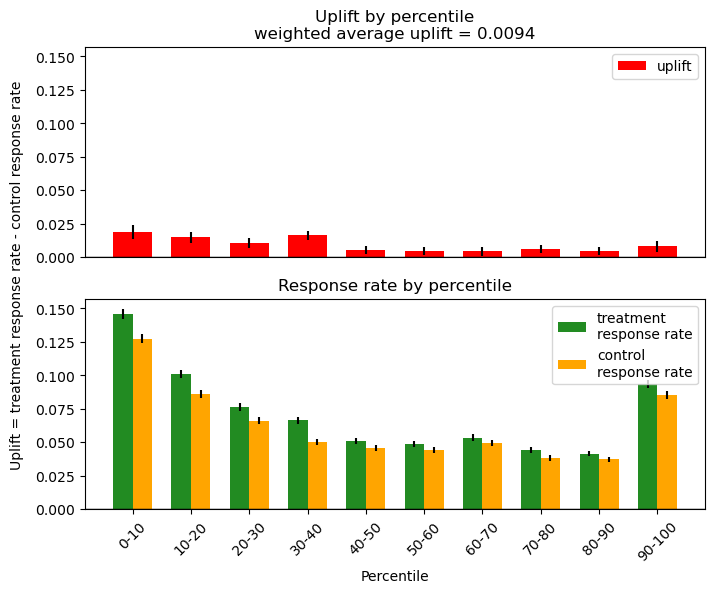

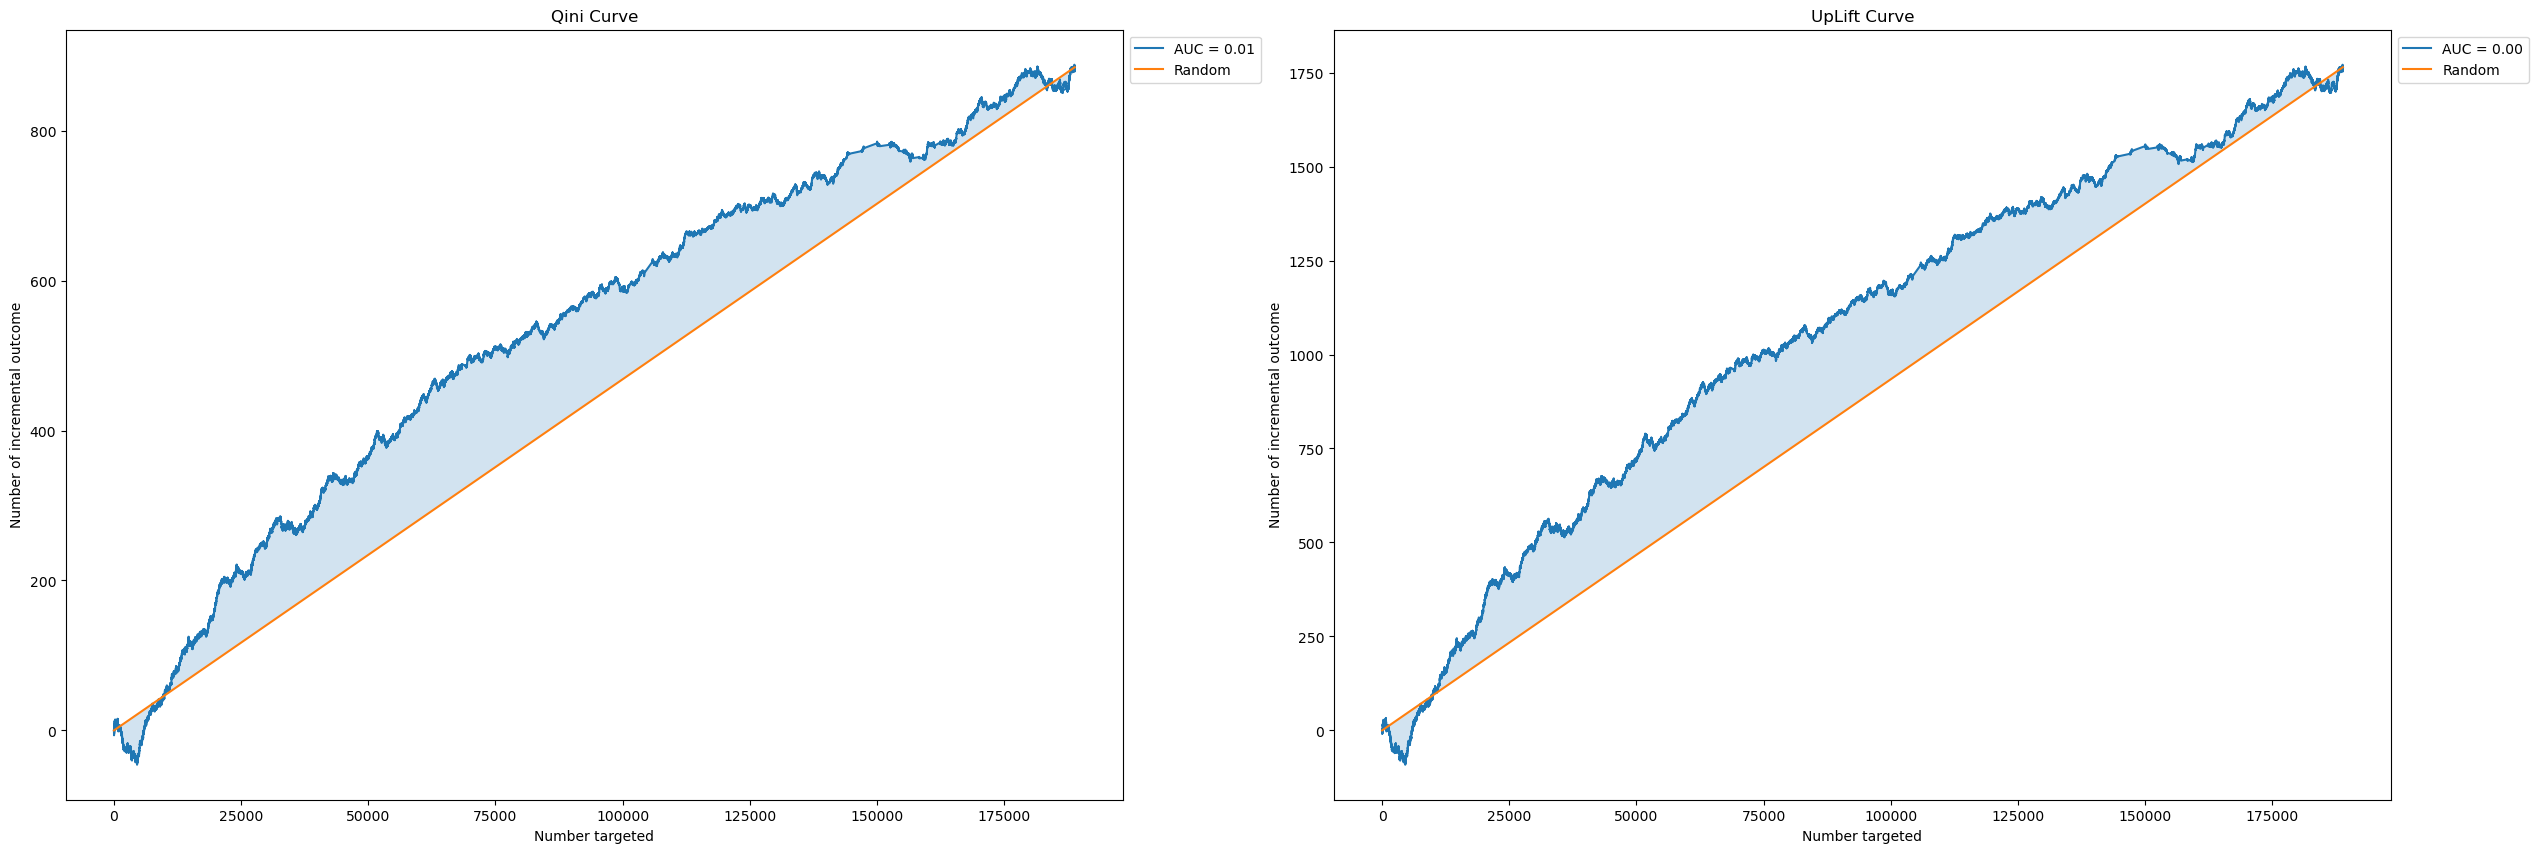

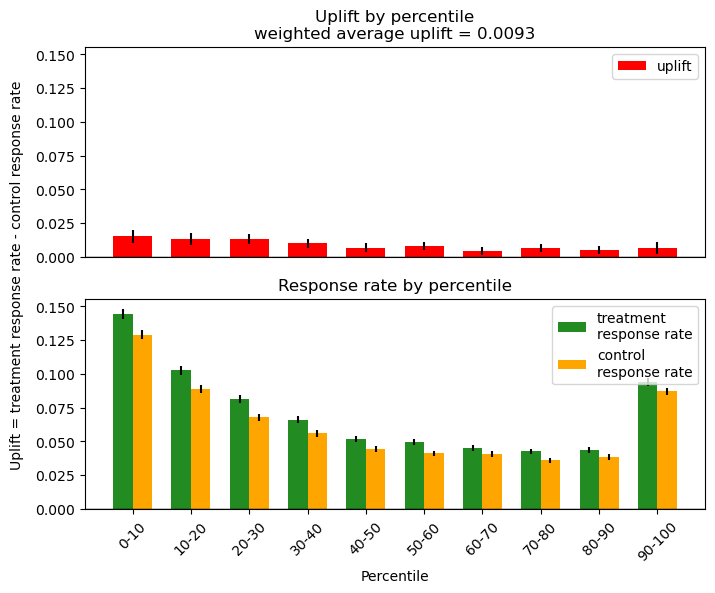

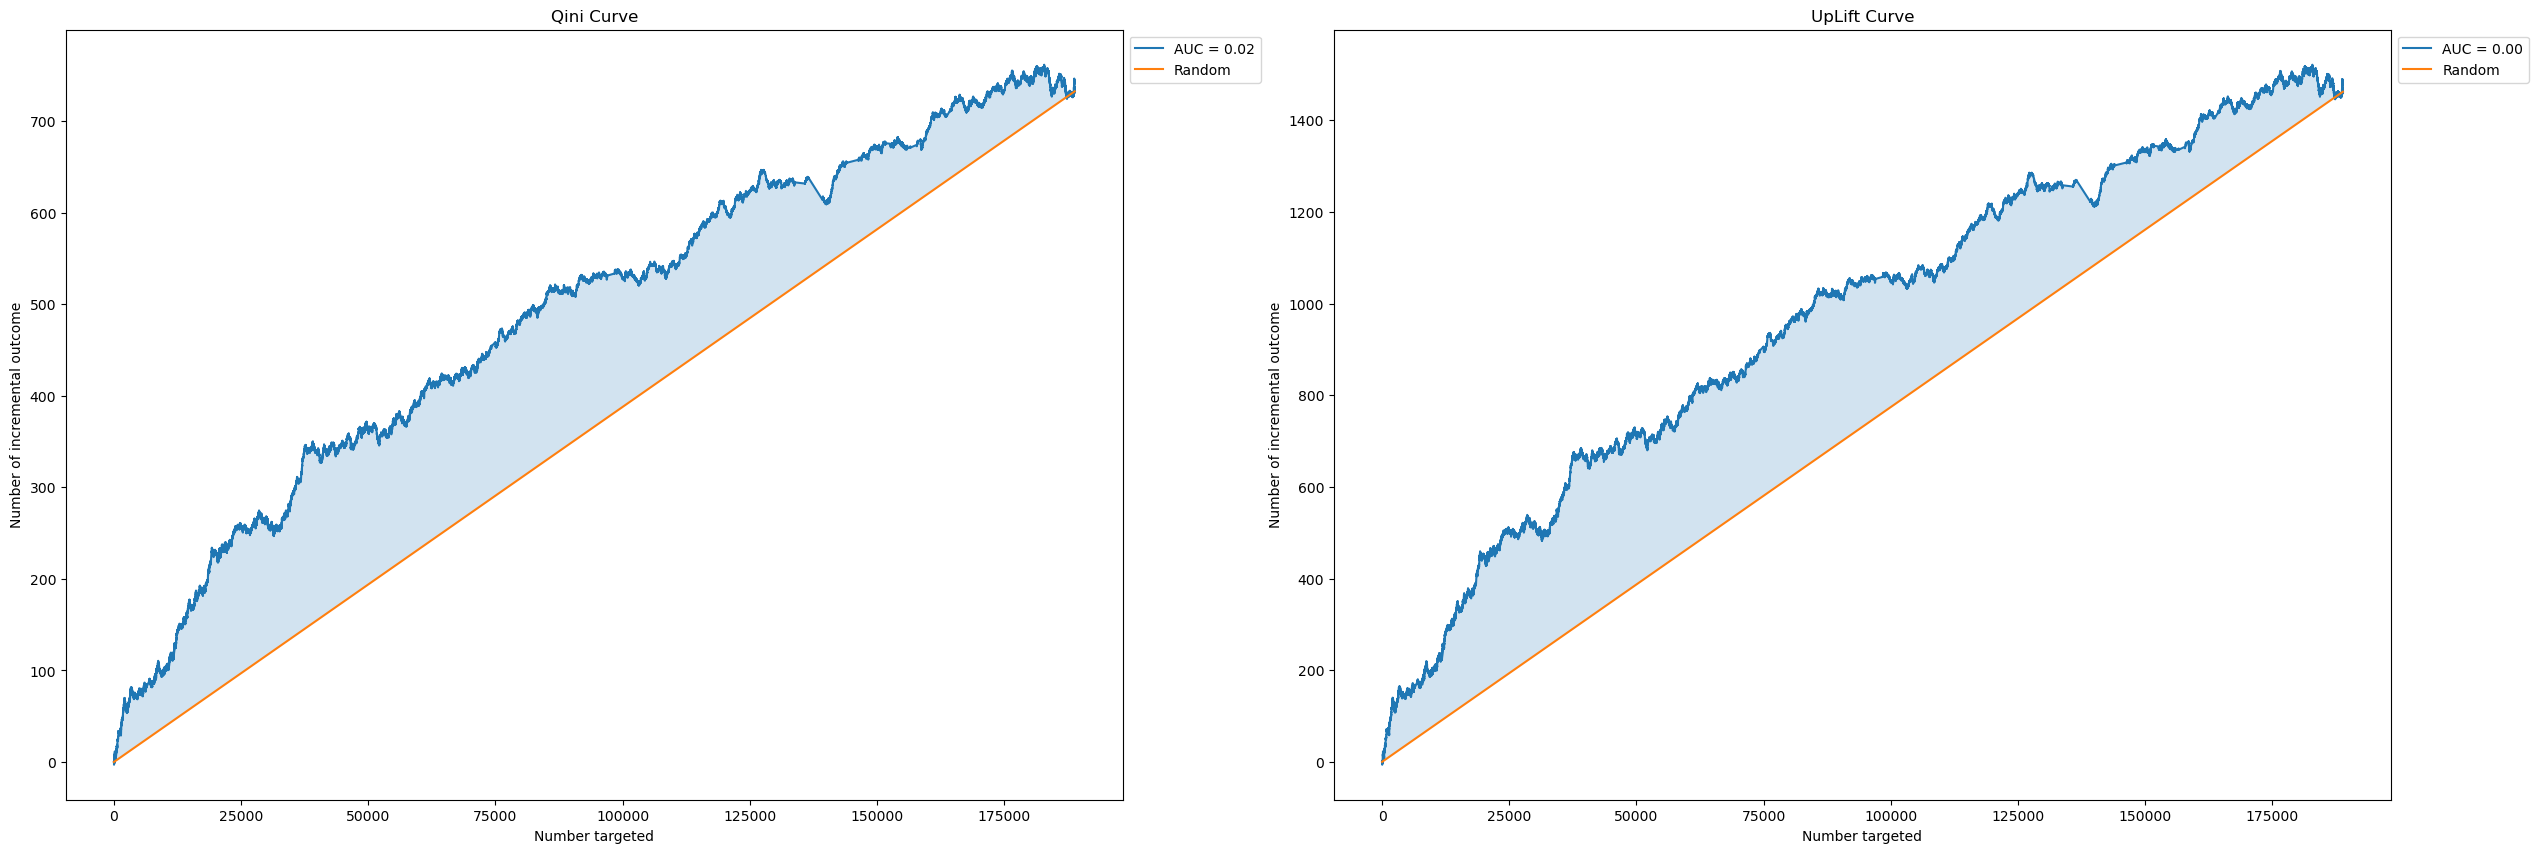

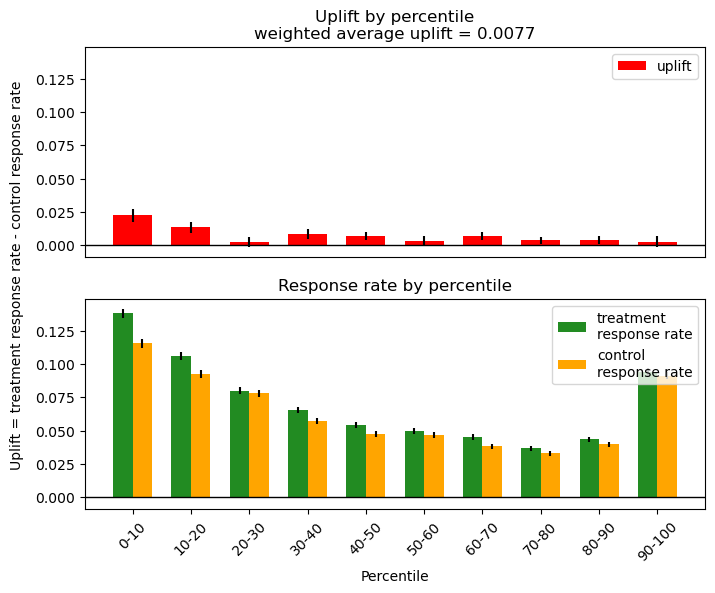

In [24]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k_group':[],  'uplift_k_overall':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_reg = CatBoostRegressor(verbose = 0)
      clf = ClassTransformationReg(estimator=catboost_reg, propensity_val=p)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_group = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='overall', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift at 30% {uplift_overall}; {uplift_group}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Trasnform Regression model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Trasnform Regression model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% =  {uplift_overall}; {uplift_group}')

In [25]:
wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% =  {uplift_overall}; {uplift_group}')

Mean WAU = 0.0085; Mean UpLift 30% =  0.0138; 0.0144


In [26]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

71195

# AutoML Class

## Search PipeLine

In [27]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
proc_data = PrepocessingDataSetLetu()
X_data, Y_data = proc_data.preprocessing_data_solomodel(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X.shape)
print(y.shape)






var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  var_51  var_52  
7727314307  0.133248  0.000612  0.132788     1.0     0.0  
7721696179  0.000000  0.000000  0.000000     1.0     0.0  
7727261180  0.999200  0.000000  0.999200     1.0     0.0  
7725642339  0.000000  0.000000  0.000000     0.0     1.0  
7720389215  0.000000  0.000000  0.000000     0.0     1.0

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

(944419, 53)
(944419,)


In [28]:
import evalml
from evalml import AutoMLSearch

In [29]:
from evalml.objectives import get_optimization_objectives
from evalml.problem_types import ProblemTypes

for objective in get_optimization_objectives(ProblemTypes.BINARY):
    print(objective.name)

MCC Binary
Log Loss Binary
Gini
AUC
Precision
F1
Balanced Accuracy Binary
Accuracy Binary


In [30]:
X_train,X_test,y_train,y_test = evalml.preprocessing.utils.split_data(X, y, problem_type="binary")

In [31]:
automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='binary'
                    , patience= 20
                    , verbose = True
                    , tolerance= 1e-12
                    , allow_long_running_models = True
                    , max_batches = 50
                    , objective = 'Gini'
                    , optimize_thresholds=True
                    , train_best_pipeline= True
                    , ensembling=True
                    , max_iterations = 50
                    , holdout_set_size= 0
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()

AutoMLSearch will use mean CV score to rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for Gini. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 50 batches for a total of 50 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mode Baseline Binary Classification Pipeline
Mode Baseline Binary Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean Gini: 0.000

*****************************
* Evaluating Batch Number 1 *
*****************************

Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Gini: 0.391
Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler:
	Starting cross validation
	Finished cross validation - mean Gini: 0.415

*****************************
* Evaluating Batch Number 2 *
*****************************

Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler + RF Classifier Select From Model:
	Starting cross validation
	Finished cross validation - mean Gini: 0.322
Random

{1: {'Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler': '00:16',
  'Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler': '00:11',
  'Total time of batch': '00:28'},
 2: {'Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler + RF Classifier Select From Model': '00:14',
  'Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + RF Classifier Select From Model': '00:11',
  'Total time of batch': '00:26'},
 3: {'Decision Tree Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Select Columns Transformer': '00:08',
  'LightGBM Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Select Columns Transformer': '00:09',
  'Extra Trees Classifier w/ Label Encoder +

In [32]:
automl.save('automl_big_searching_class.cloudpickle')

## Train Best Pipeline

In [33]:
import evalml
from evalml import AutoMLSearch
automl = AutoMLSearch.load('automl_big_searching_class.cloudpickle')


In [34]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [35]:
ranks.to_csv('evalml_class_res.csv', index = False)

In [36]:
ranks.head()

pipeline_name  validation_score  \
0            Stacked Ensemble Classification Pipeline          0.414692   
16  Random Forest Classifier w/ Label Encoder + Re...          0.414609   
17  LightGBM Classifier w/ Label Encoder + Replace...          0.406470   
18  XGBoost Classifier w/ Label Encoder + Replace ...          0.401770   
19  Random Forest Classifier w/ Label Encoder + Re...          0.394976   

    percent_better_than_baseline  \
0                            inf   
16                           inf   
17                           inf   
18                           inf   
19                           inf   

                                           parameters  
0   {'Label Encoder': {'positive_label': None}, 'L...  
16  {'Label Encoder': {'positive_label': None}, 'I...  
17  {'Label Encoder': {'positive_label': None}, 'I...  
18  {'Label Encoder': {'positive_label': None}, 'I...  
19  {'Label Encoder': {'positive_label': None}, 'I...

In [37]:
ranks.shape

(13, 4)

In [38]:

ranks.head(10).to_excel('class_res.xlsx')

In [39]:
ranks.iloc[0, :].parameters

{'Label Encoder': {'positive_label': None},
 'Linear Pipeline - Label Encoder': {'positive_label': None},
 'Linear Pipeline - Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Linear Pipeline - Undersampler': {'sampling_ratio': 0.25,
  'min_samples': 100,
  'min_percentage': 0.1,
  'sampling_ratio_dict': None},
 'Linear Pipeline - Logistic Regression Classifier': {'penalty': 'l2',
  'C': 1.0,
  'n_jobs': -1,
  'multi_class': 'auto',
  'solver': 'lbfgs'},
 'Random Forest Pipeline - Label Encoder': {'positive_label': None},
 'Random Forest Pipeline - Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Random Forest Pip

In [40]:
best_clf = automl.best_pipeline
type(best_clf)

evalml.pipelines.binary_classification_pipeline.BinaryClassificationPipeline

In [41]:
#ctbst.fit(X_train, y_train)

In [42]:
# best_features = best_clf.graph_feature_importance()
# best_features = best_features[best_features.importance.abs() > 1]
# best_features

In [43]:
# features

In [44]:
# best_features['Name'] = best_features.feature.apply(lambda x: features[x])
# best_features

In [45]:
# print(best_features.Name.tolist())

In [46]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
proc_data = PrepocessingDataSetLetu()
X_data, Y_data = proc_data.preprocessing_data_solomodel(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X.shape)
print(y.shape)






var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  var_51  var_52  
7727314307  0.133248  0.000612  0.132788     1.0     0.0  
7721696179  0.000000  0.000000  0.000000     1.0     0.0  
7727261180  0.999200  0.000000  0.999200     1.0     0.0  
7725642339  0.000000  0.000000  0.000000     0.0     1.0  
7720389215  0.000000  0.000000  0.000000     0.0     1.0

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

(944419, 53)
(944419,)


In [47]:
best_clf.predict_proba(X)[1].values

array([0.1937664 , 0.0766766 , 0.73344347, ..., 0.36928437, 0.1875987 ,
       0.30329138])

Split 1; WAU = 0.007174301767597037; UpLift at 30% 0.023816321248122926; 0.0241213909914567


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 2; WAU = 0.009353130285477965; UpLift at 30% 0.02344734226274152; 0.023930984390917107


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 3; WAU = 0.008931010781575972; UpLift at 30% 0.022487088200676617; 0.023530969650584627


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 4; WAU = 0.009117144004869978; UpLift at 30% 0.023688306088037098; 0.02386689311910195


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 5; WAU = 0.007411269336863195; UpLift at 30% 0.02283530029779822; 0.023635223258347632


C:\Users\Kirill\AppData\Local\Temp\ipykernel_11780\1923001410.py:33: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must speci

Mean WAU = 0.0084; Mean UpLift 30% =  0.0233; 0.0238


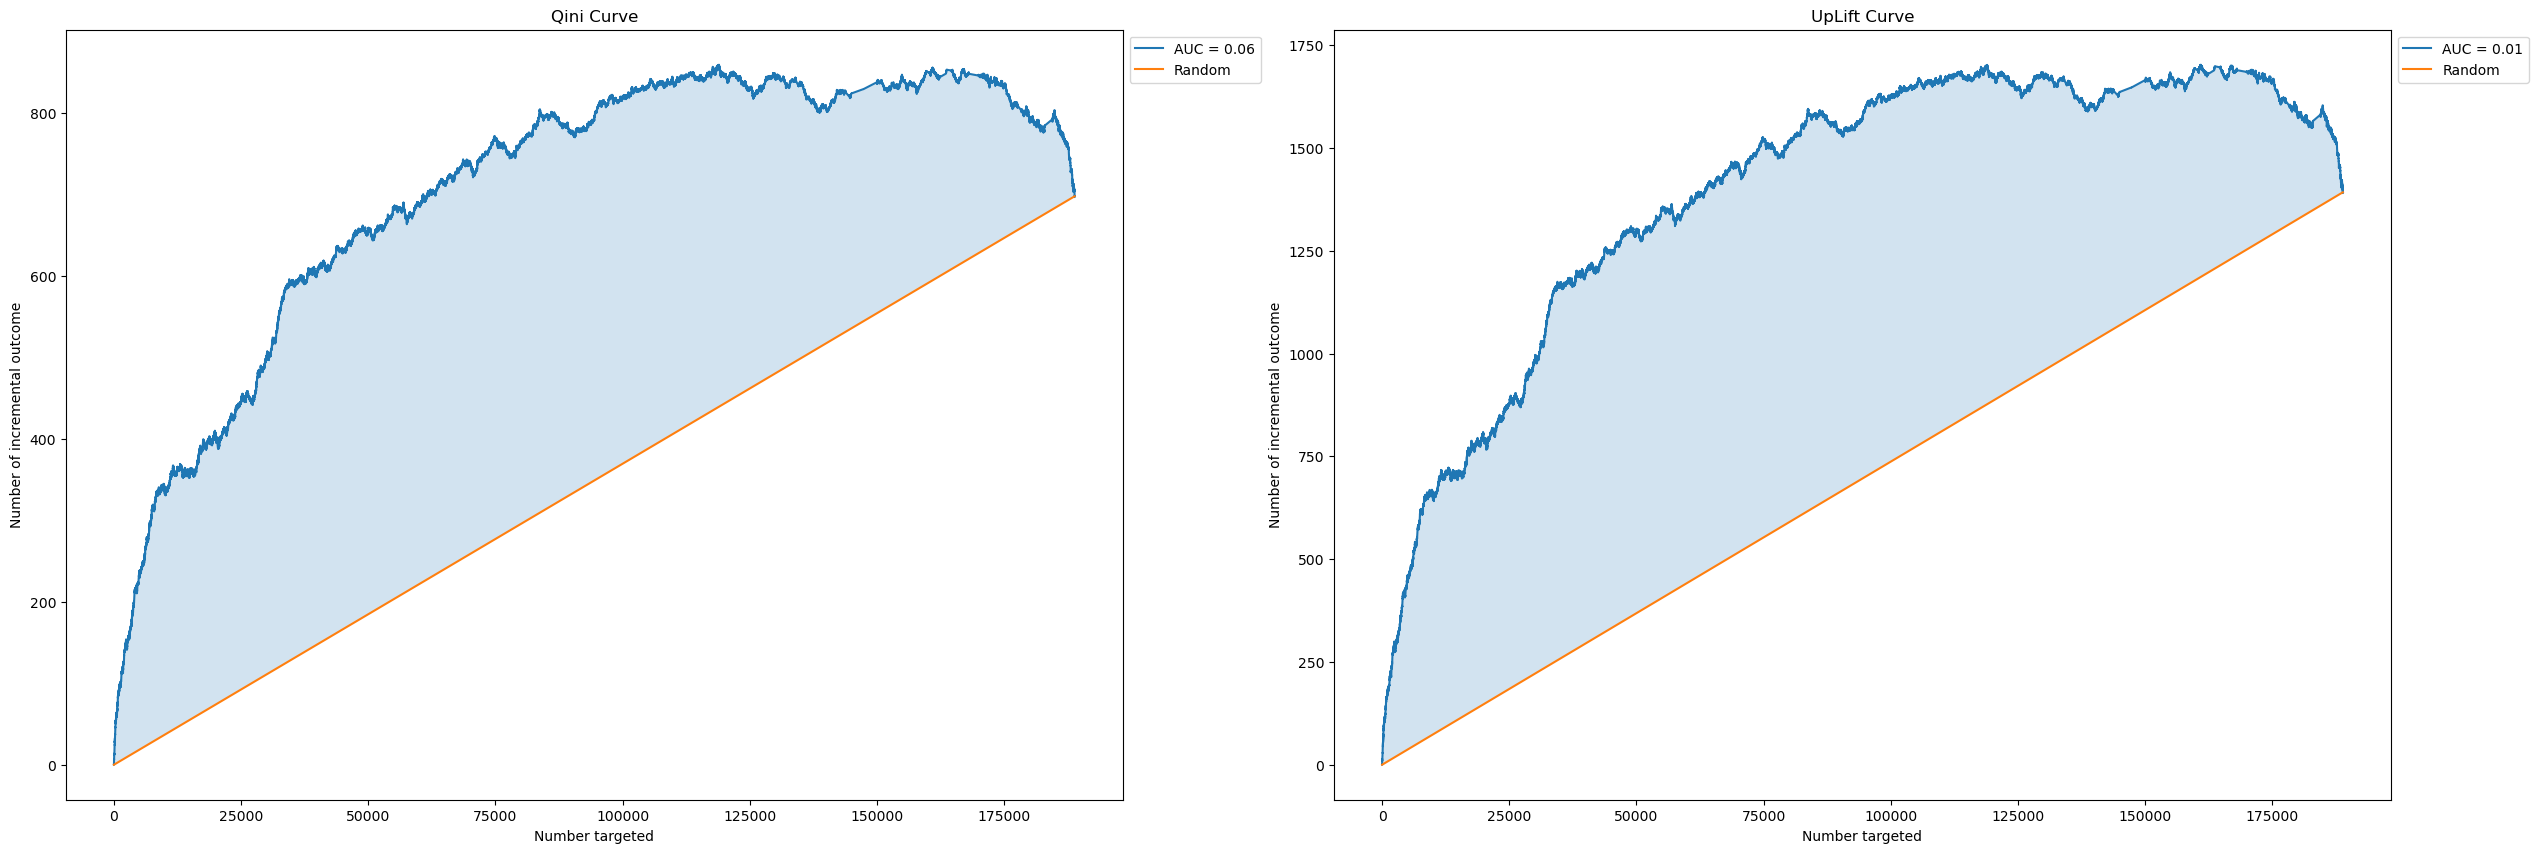

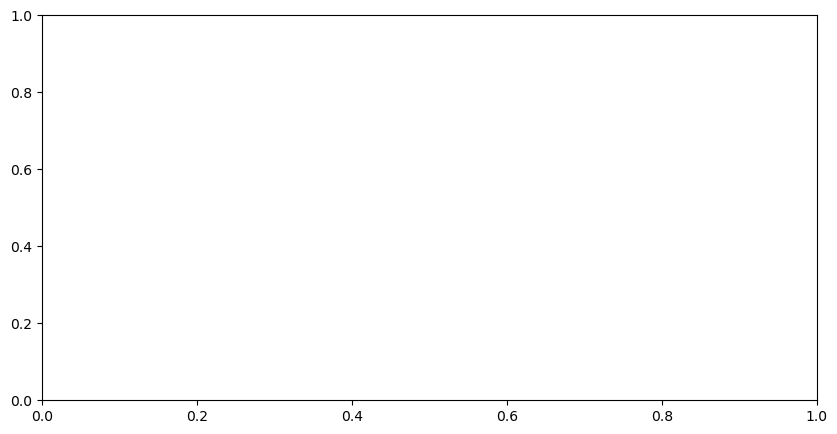

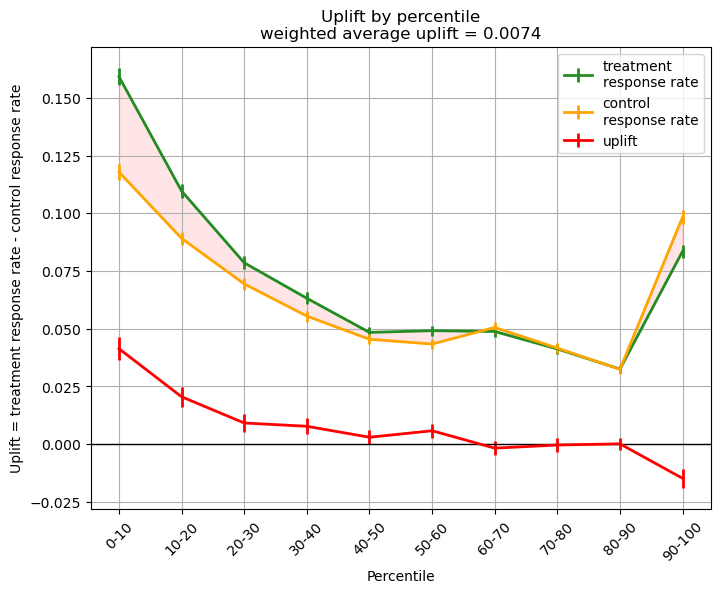

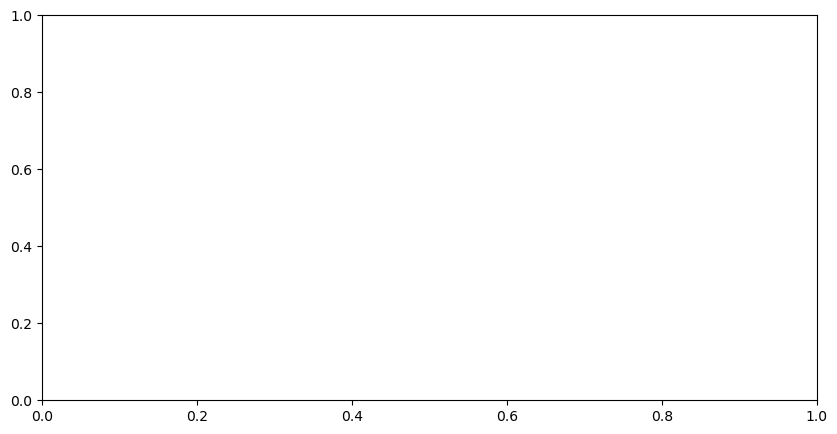

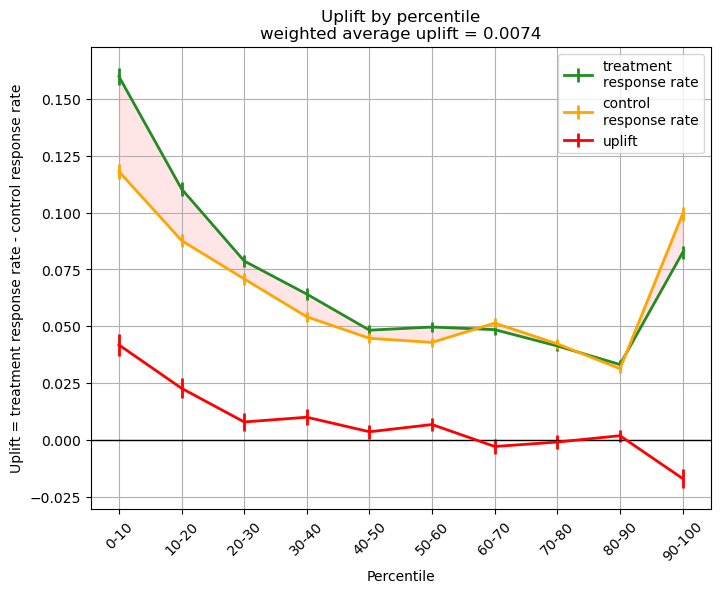

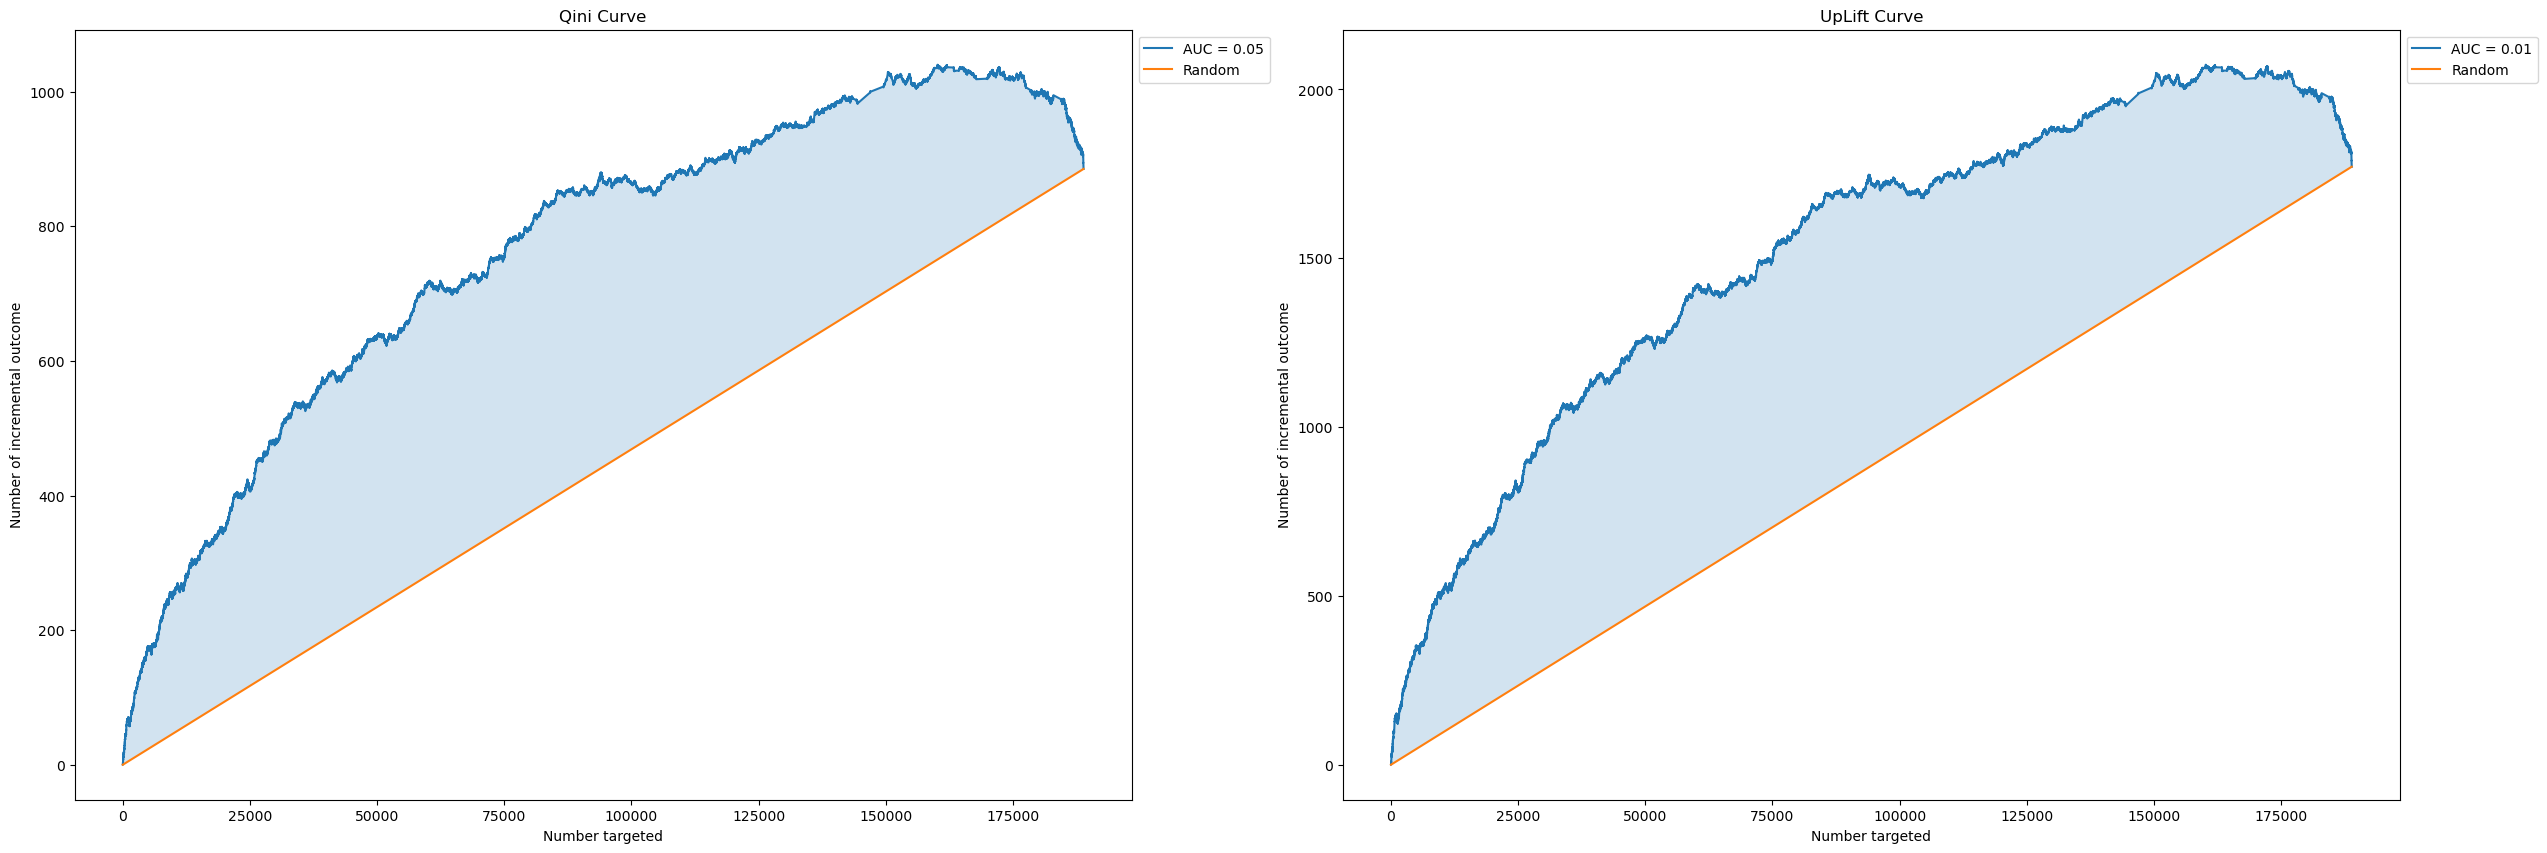

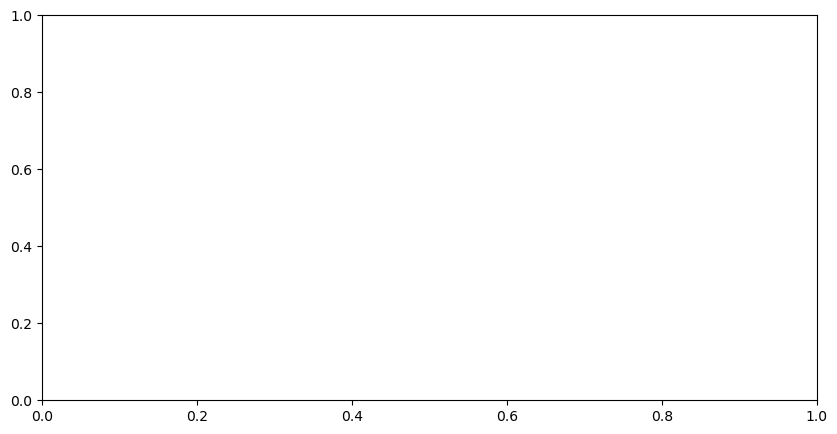

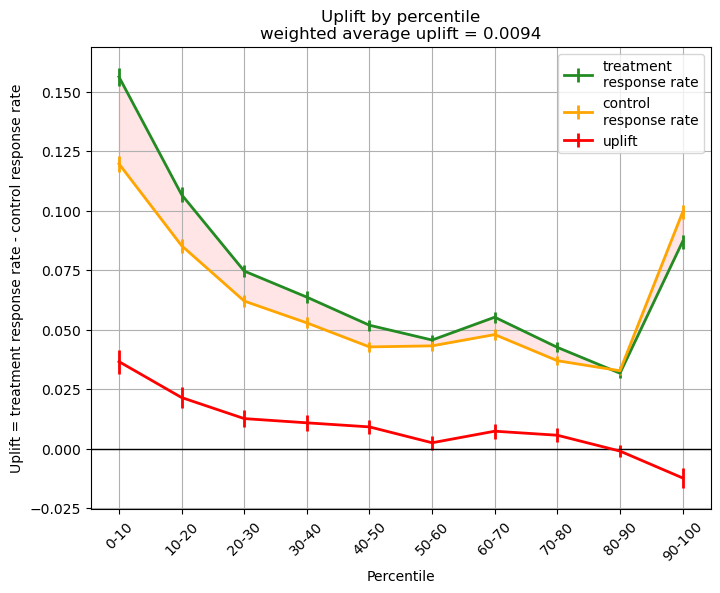

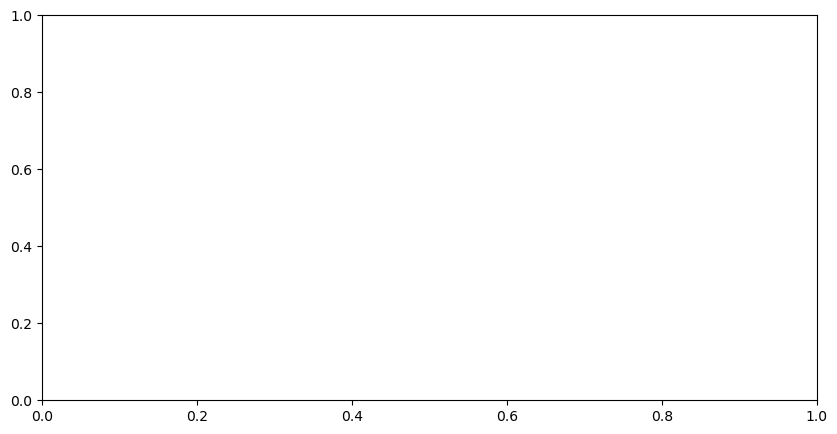

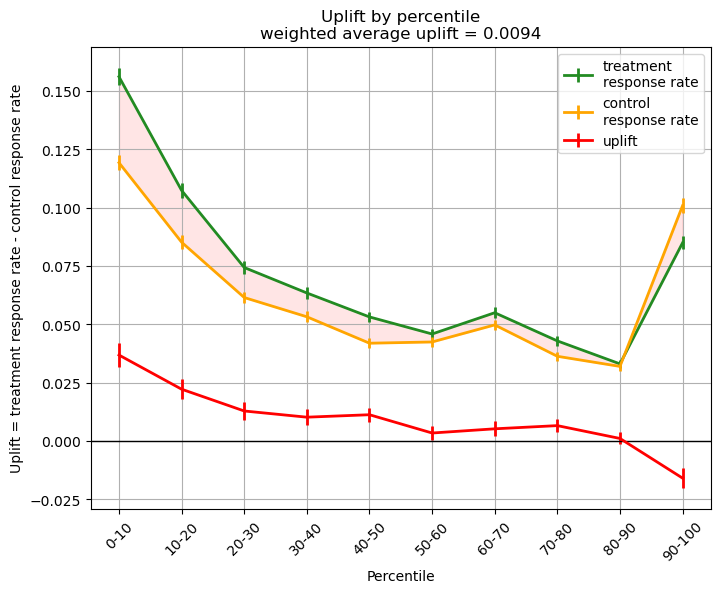

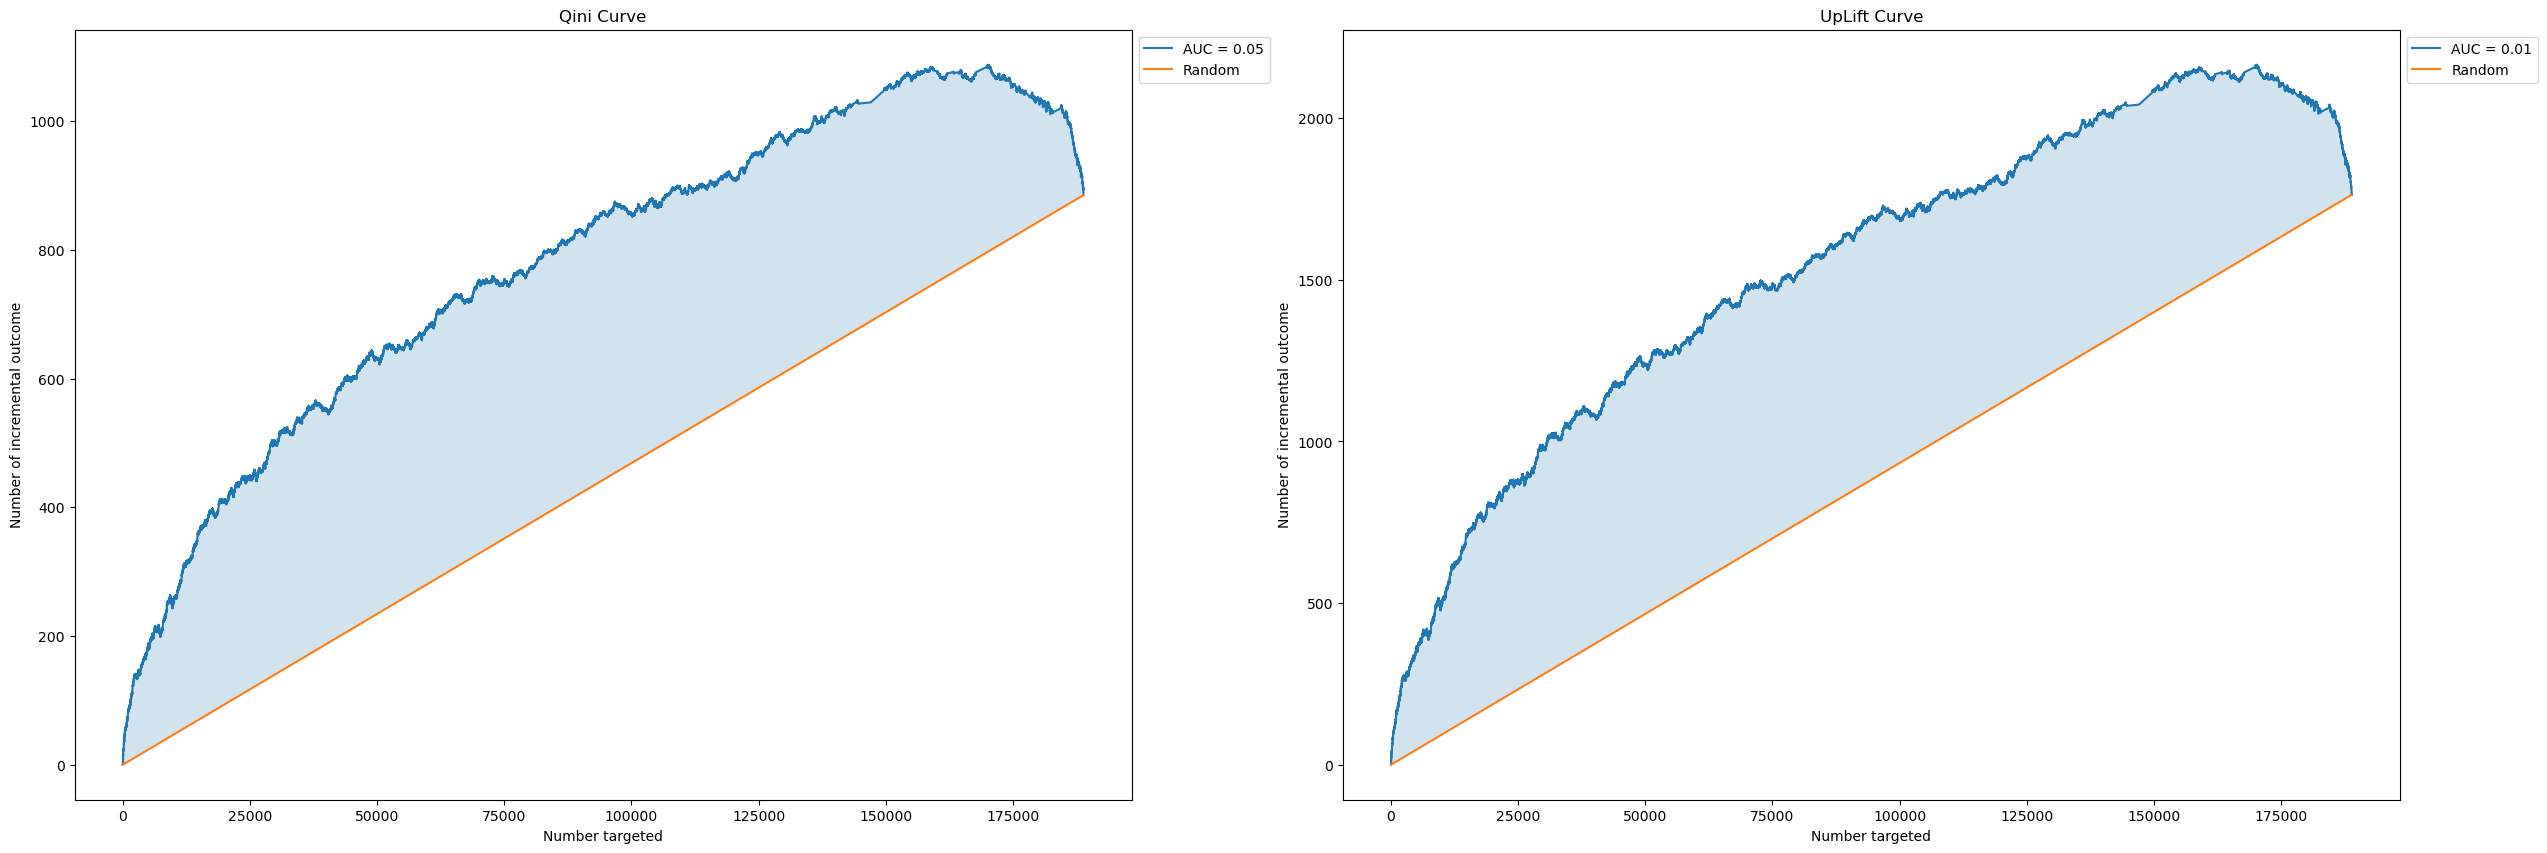

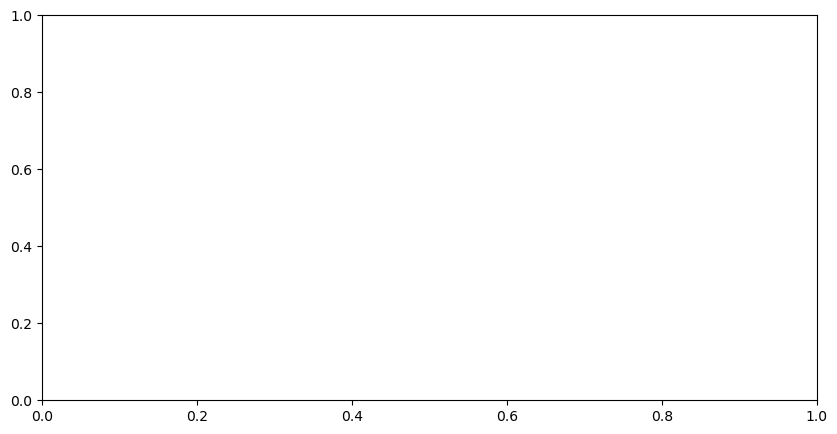

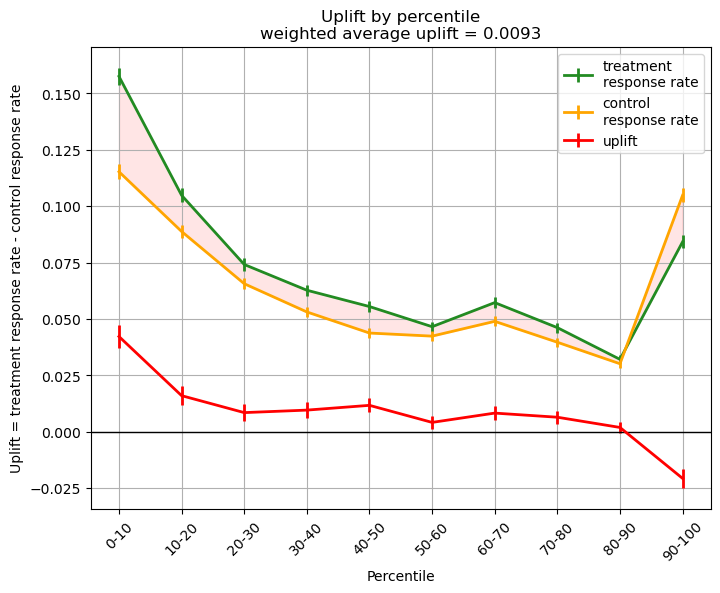

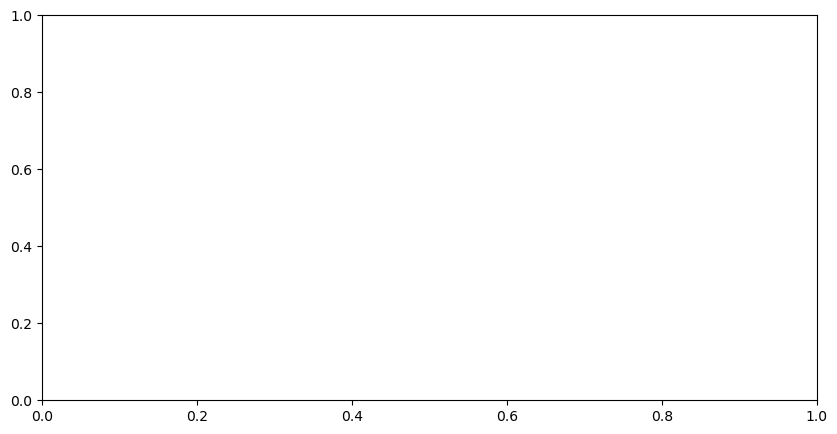

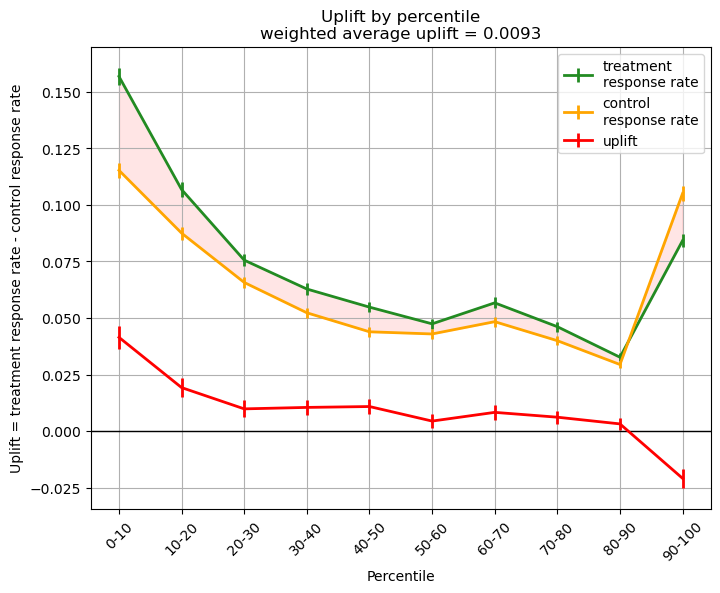

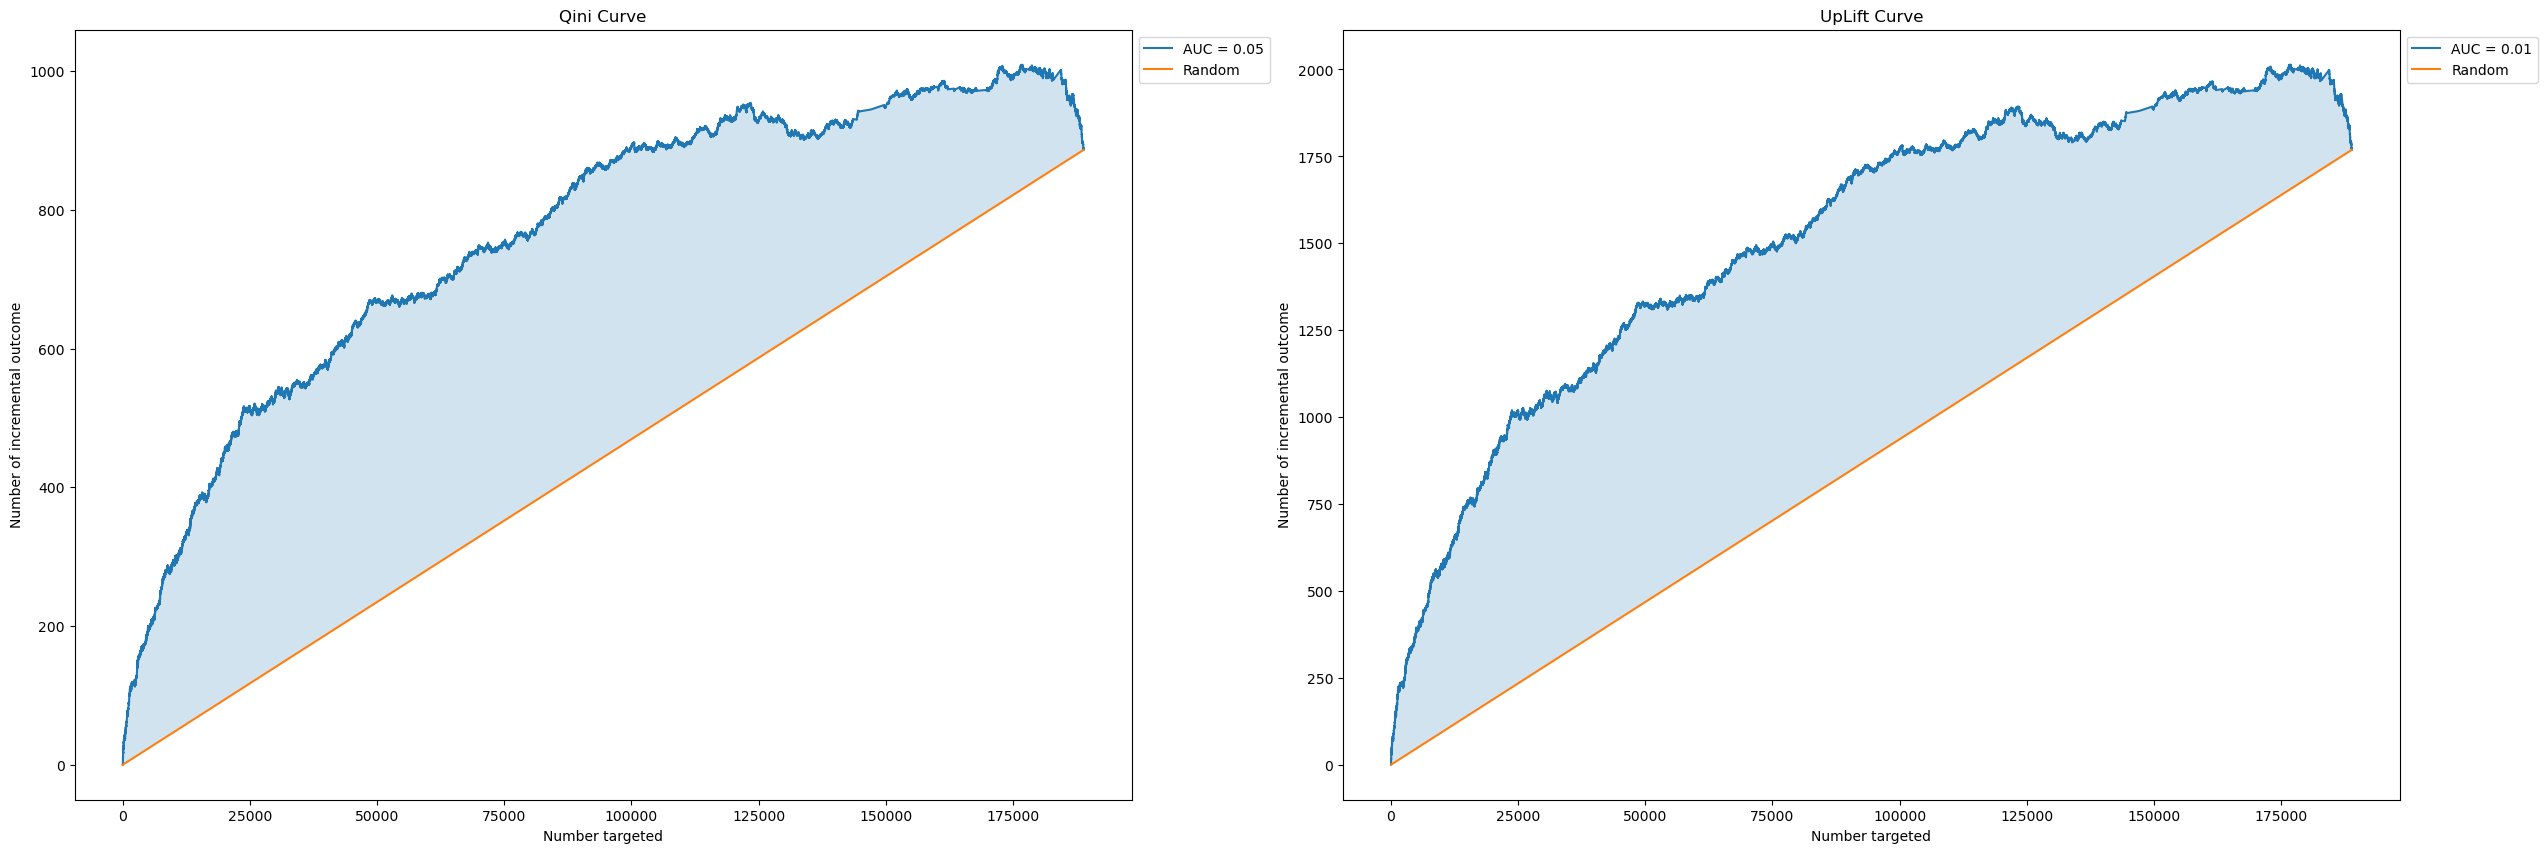

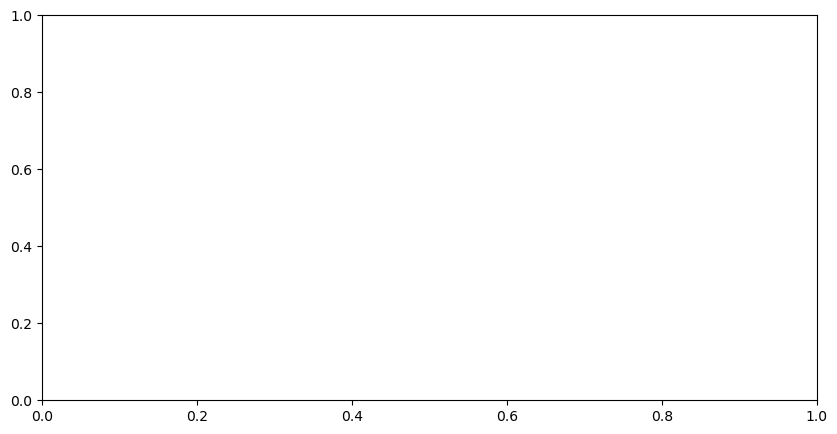

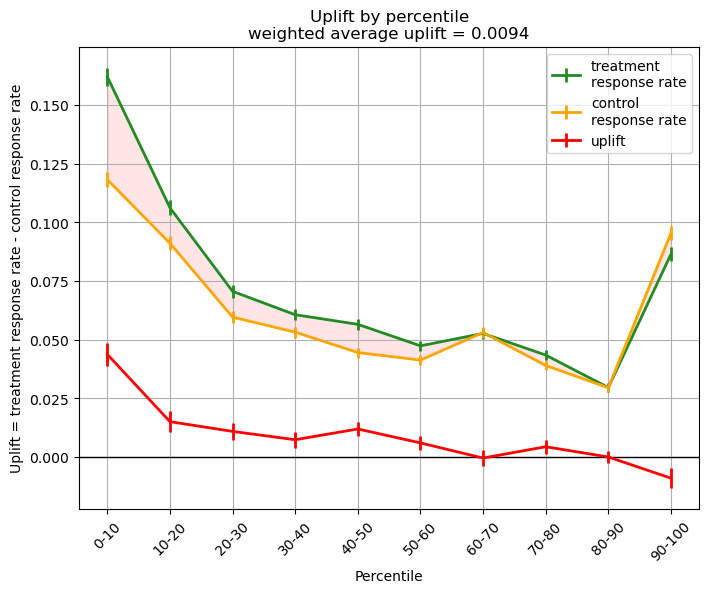

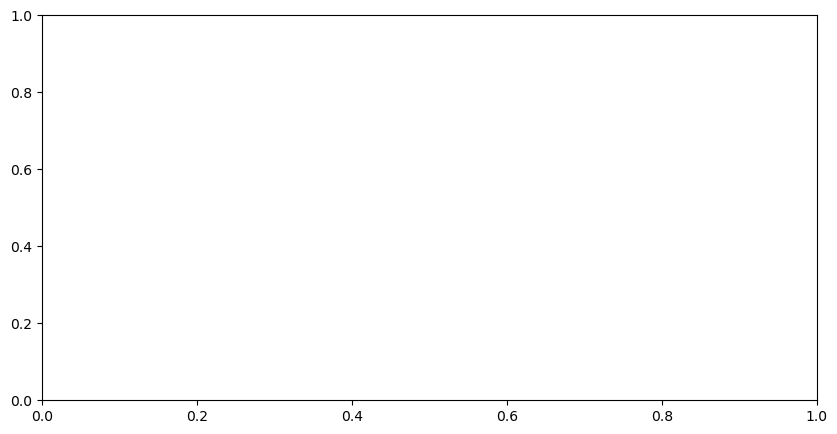

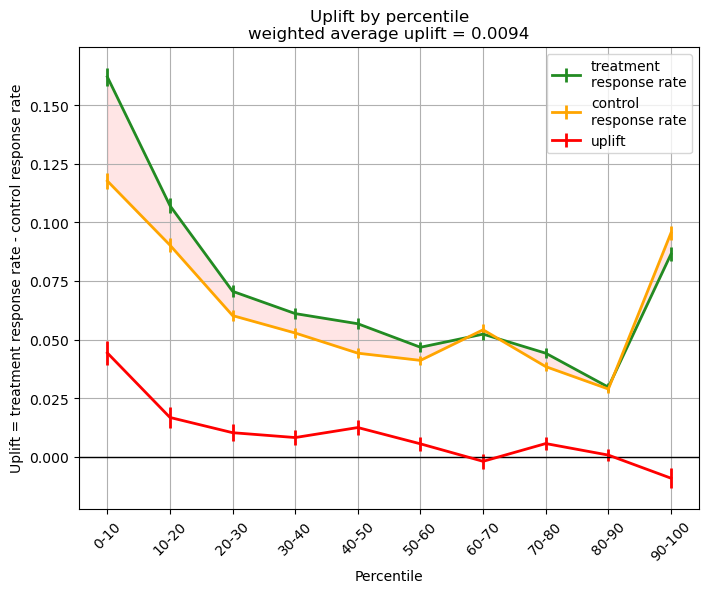

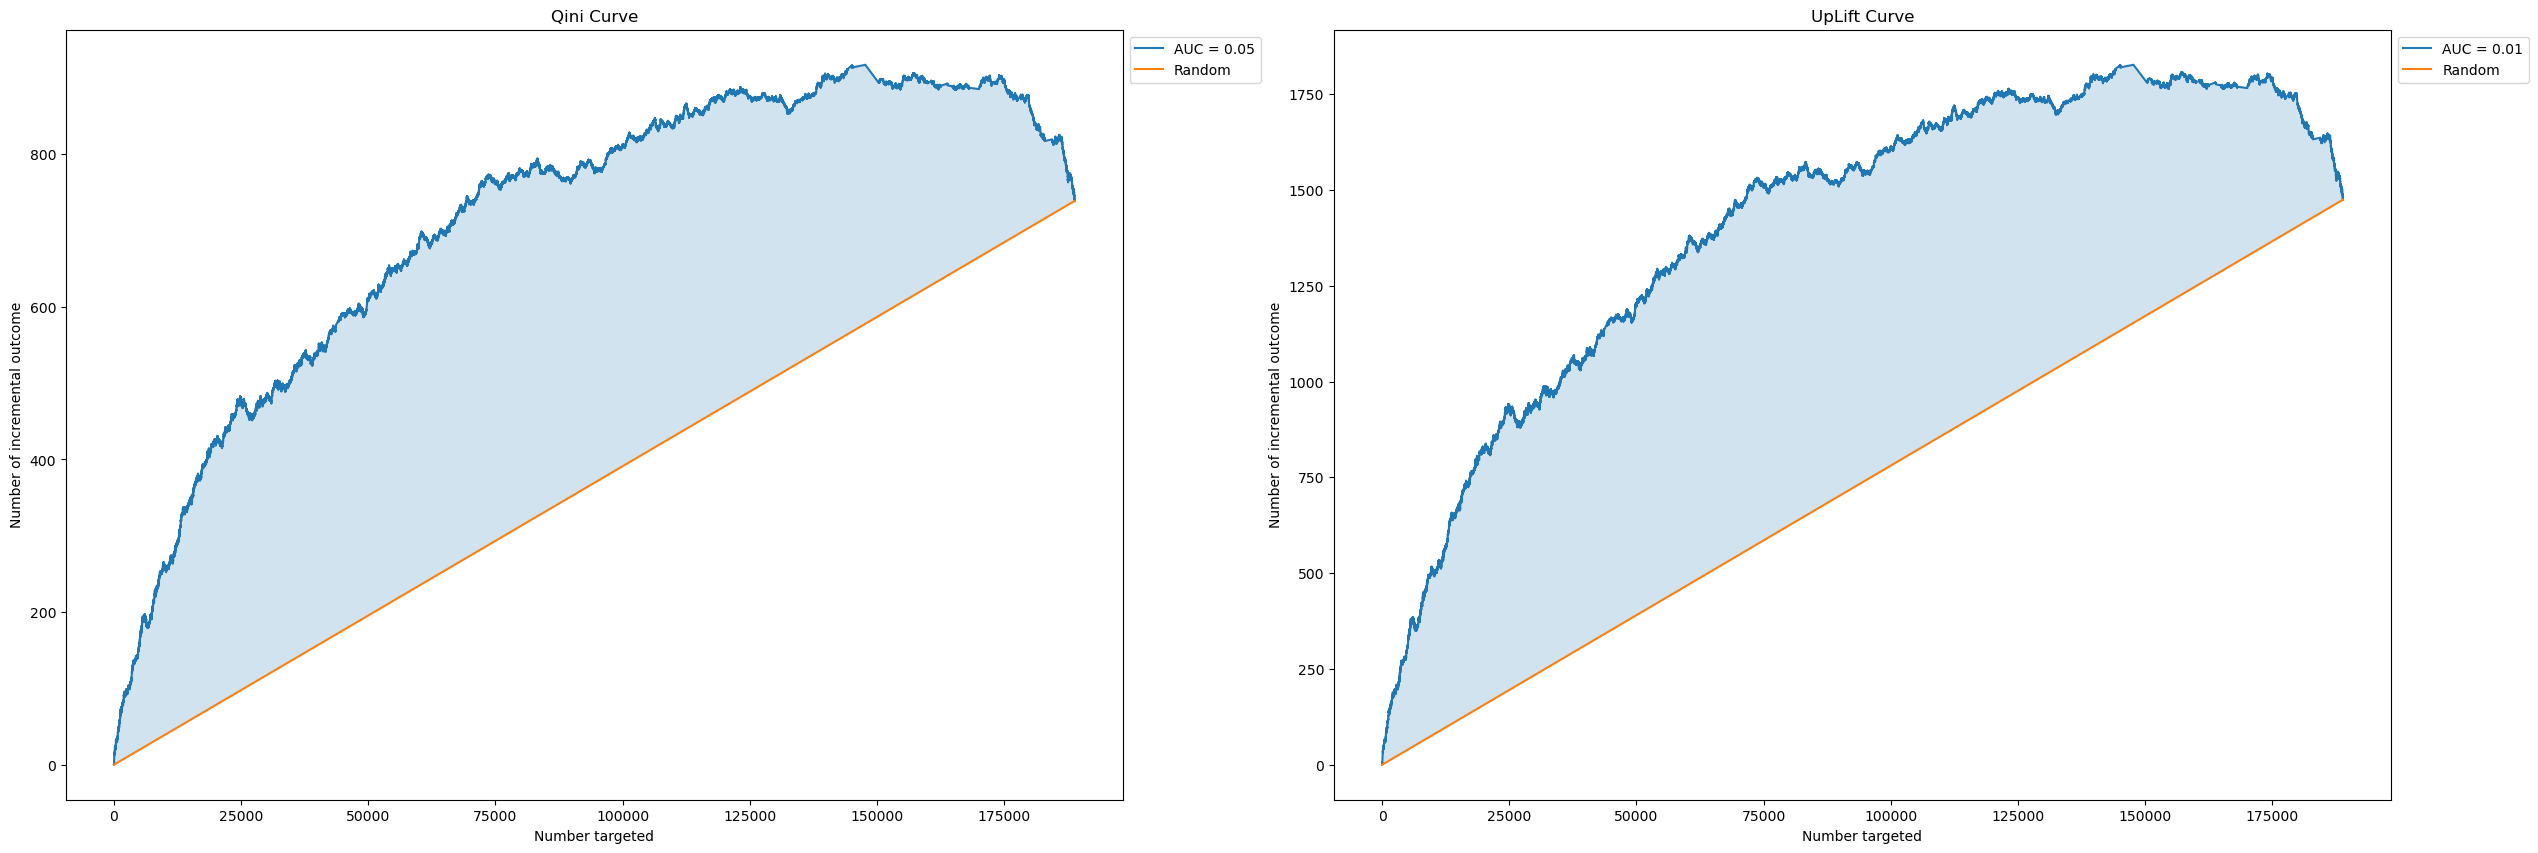

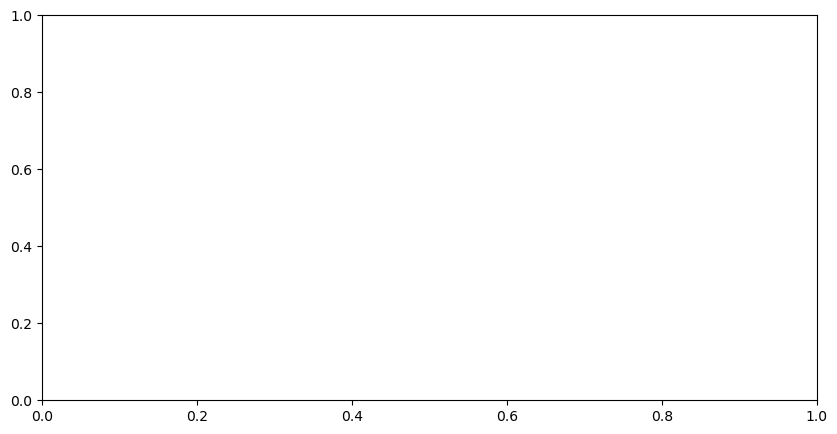

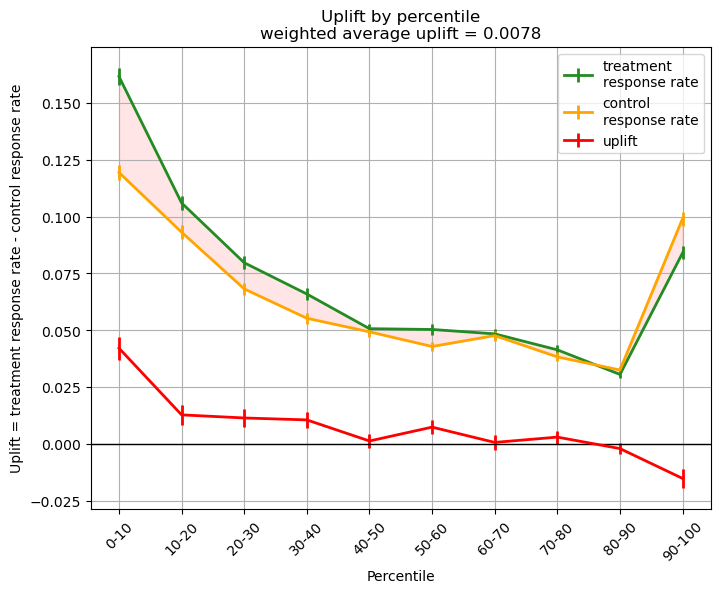

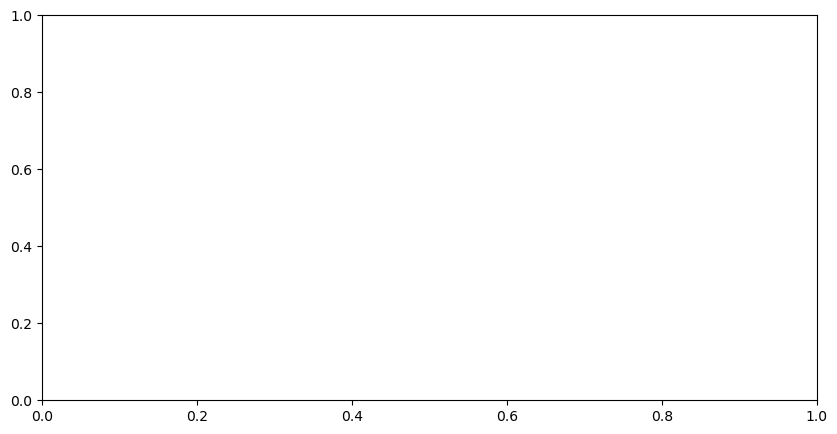

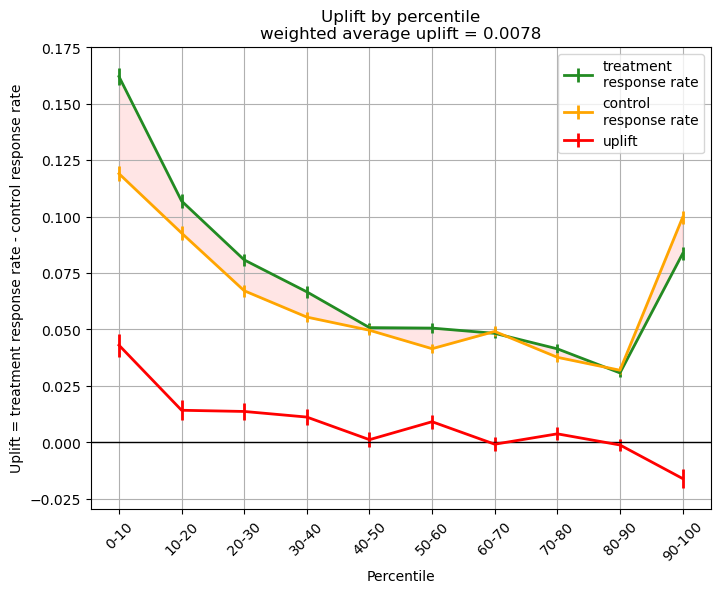

In [56]:
import copy
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k_group':[],  'uplift_k_overall':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      best_clf  = copy.deepcopy(automl.best_pipeline)
      best_clf.fit(X_train_, y_train_)
      X_test_[:, -2:] = proc_data.ohe_solomodel.transform(np.zeros(shape = treat[test_index].shape).reshape(-1, 1)).toarray()
      y_pred0 = best_clf.predict_proba(X_test_)[[1]]
      X_test_[:, -2:] = proc_data.ohe_solomodel.transform(np.ones(shape = treat[test_index].shape).reshape(-1, 1)).toarray()
      y_pred1 = best_clf.predict_proba(X_test_)[[1]]
      y_pred = np.squeeze(y_pred1 - y_pred0).tolist()
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_group = uplift_at_k(y_true=y_test_, uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      uplift_overall = uplift_at_k(y_true=y_test_, uplift=y_pred,
                              treatment=treat[test_index], strategy='overall', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift at 30% {uplift_overall}; {uplift_group}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Classification EvalML model Split {i}.png")
      fig, ax = plt.subplots(figsize = (10, 5))
      plot_uplift_by_percentile(y_true=y_test_, uplift=y_pred,
                              treatment=treat[test_index], kind='line', strategy='overall')
      plt.grid('both')
      plt.savefig(f"Plots/CLassification EvalML model Procentile Split Overall {i}.png")

      fig, ax = plt.subplots(figsize = (10, 5))
      plot_uplift_by_percentile(y_true=y_test_, uplift=y_pred,
                              treatment=treat[test_index], kind='line', strategy='by_group')
      plt.grid('both')
      plt.savefig(f"Plots/CLassification EvalML model Procentile Split grouped {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% =  {uplift_overall}; {uplift_group}')

In [49]:
wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% =  {uplift_overall}; {uplift_group}')

Mean WAU = 0.0084; Mean UpLift 30% =  0.0233; 0.0238


In [80]:
print(y_pred1)

0    0.925215
1    0.074785
Name: 1, dtype: float64


In [53]:
Y_data.groupby(['treat']).agg({'target': lambda x: pd.Series.sum(x) / pd.Series.count(x)})

target
treat          
0      0.063272
1      0.071924

# AutoML Reg

## Search PipeLine

In [25]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values.astype(float)
features = X_data.columns.tolist()
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    36.0  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    51.0 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    32.0 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    36.0  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    36.0  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

[[1.00000e+00 0.00000e+00 0.00000e+00 ... 1.33248e-01 6.12000e-04
  1.32788e-01]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 9.99200e-01 0.00000e+00
  9.99200e-01]
 ...
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
[-0. -0. -0. ...  0. -0.  0.]
0.5011176183452472


In [26]:
import evalml
from evalml import AutoMLSearch

In [27]:
# from evalml.objectives import get_optimization_objectives
# from evalml.problem_types import ProblemTypes

# for objective in get_optimization_objectives(ProblemTypes.REGRESSION):
#     print(objective.name)

In [28]:
X_train,X_test,y_train,y_test= evalml.preprocessing.utils.split_data(X, y, problem_type="regression")

In [29]:
automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='regression'
                    , patience= 20
                    , verbose = True
                    , allow_long_running_models = True
                    , max_batches = 20
                    , objective = 'MSE'
                    , optimize_thresholds=True
                    , train_best_pipeline= True
                    , ensembling=True
                    , max_iterations = 20
                    , holdout_set_size= 0
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()

AutoMLSearch will use mean CV score to rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for MSE. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 20 batches for a total of 20 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271

*****************************
* Evaluating Batch Number 1 *
*****************************



c:\Users\Kirill\.conda\envs\automl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.180e+03, tolerance: 5.104e+00



Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271

*****************************
* Evaluating Batch Number 2 *
*****************************

Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271

*****************************
* Evaluating Batch Number 3 *
*****************************

Decision Tree Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer:
	Starting cross validation
	Finished

{1: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler': '00:19',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer': '00:34',
  'Total time of batch': '00:55'},
 2: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model': '00:32',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model': '00:45',
  'Total time of batch': '01:18'},
 3: {'Decision Tree Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:06',
  'Extra Trees Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:17',
  'XGBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:12',
  'CatBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:05',
  'LightGBM Regressor w/ Replace

In [30]:
automl.save('automl_big_searching.cloudpickle')

## Train Best Pipeline

In [31]:
import evalml
from evalml import AutoMLSearch
automl = AutoMLSearch.load('automl_big_searching.cloudpickle')


In [32]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [33]:
ranks.to_csv('evalml_res.csv', index = False)

In [34]:
ranks.head()

pipeline_name  validation_score  \
0  CatBoost Regressor w/ Replace Nullable Types T...          0.270921   
1  Elastic Net Regressor w/ Replace Nullable Type...          0.270925   
2                  Mean Baseline Regression Pipeline          0.270931   
3  Elastic Net Regressor w/ Replace Nullable Type...          0.270931   
6  Random Forest Regressor w/ Replace Nullable Ty...          0.270952   

   percent_better_than_baseline  \
0                      0.003873   
1                      0.002225   
2                      0.000000   
3                      0.000000   
6                     -0.007587   

                                          parameters  
0  {'Imputer': {'categorical_impute_strategy': 'm...  
1  {'Imputer': {'categorical_impute_strategy': 'm...  
2       {'Baseline Regressor': {'strategy': 'mean'}}  
3  {'Imputer': {'categorical_impute_strategy': 'm...  
6  {'Imputer': {'categorical_impute_strategy': 'm...

In [35]:
ranks.shape

(13, 4)

In [36]:

ranks.head(10).to_excel('res.xlsx')

In [37]:
ranks.iloc[0, :].parameters

{'Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Select Columns Transformer': {'columns': [3,
   5,
   11,
   14,
   18,
   19,
   20,
   22,
   23,
   25,
   26,
   27,
   28,
   30,
   33,
   35,
   36,
   37,
   40,
   43,
   45,
   46,
   47,
   48,
   49,
   50]},
 'CatBoost Regressor': {'n_estimators': 10,
  'eta': 0.03,
  'max_depth': 6,
  'bootstrap_type': None,
  'silent': False,
  'allow_writing_files': False,
  'n_jobs': -1}}

In [38]:
ctbst  = automl.best_pipeline
type(ctbst)

evalml.pipelines.regression_pipeline.RegressionPipeline

In [39]:
#ctbst.fit(X_train, y_train)

In [40]:
best_features = ctbst.feature_importance.copy()
best_features = best_features[best_features.importance.abs() > 1]
best_features

feature  importance
0        11   12.598069
1        18   10.938700
2        49   10.155543
3        45    8.711823
4        37    6.824476
5        27    5.928198
6        26    5.468107
7         3    5.285454
8        30    5.033980
9        47    4.763652
10       25    3.661995
11       28    3.441240
12       36    3.153072
13       35    2.731776
14       22    2.450711
15       33    1.896294
16       50    1.877300
17       14    1.557559
18       19    1.245979

In [41]:
# features

In [42]:
# best_features['Name'] = best_features.feature.apply(lambda x: features[x])
# best_features

In [44]:
# print(best_features.Name.tolist())

In [48]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
features = X_data.columns.tolist()
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    36.0  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    51.0 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    32.0 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    36.0  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    36.0  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

[[1.00000e+00 0.00000e+00 0.00000e+00 ... 1.33248e-01 6.12000e-04
  1.32788e-01]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 9.99200e-01 0.00000e+00
  9.99200e-01]
 ...
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
[-0. -0. -0. ...  0. -0.  0.]
0.5011176183452472


Split 1; WAU = 0.006712911706141414; UpLift at 30% 0.01655729120017245; 0.017459756723942926


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 2; WAU = 0.008836553072787311; UpLift at 30% 0.017310025897842765; 0.018288617360130474


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 3; WAU = 0.008755002382110197; UpLift at 30% 0.021436724586364628; 0.022351650098994605


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 4; WAU = 0.008741687559728956; UpLift at 30% 0.01856169817509347; 0.018679662389873827


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 5; WAU = 0.007096650175102054; UpLift at 30% 0.01585597818094149; 0.017441750248262194


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Mean WAU = 0.008; Mean UpLift 30% =  0.0179; 0.0188


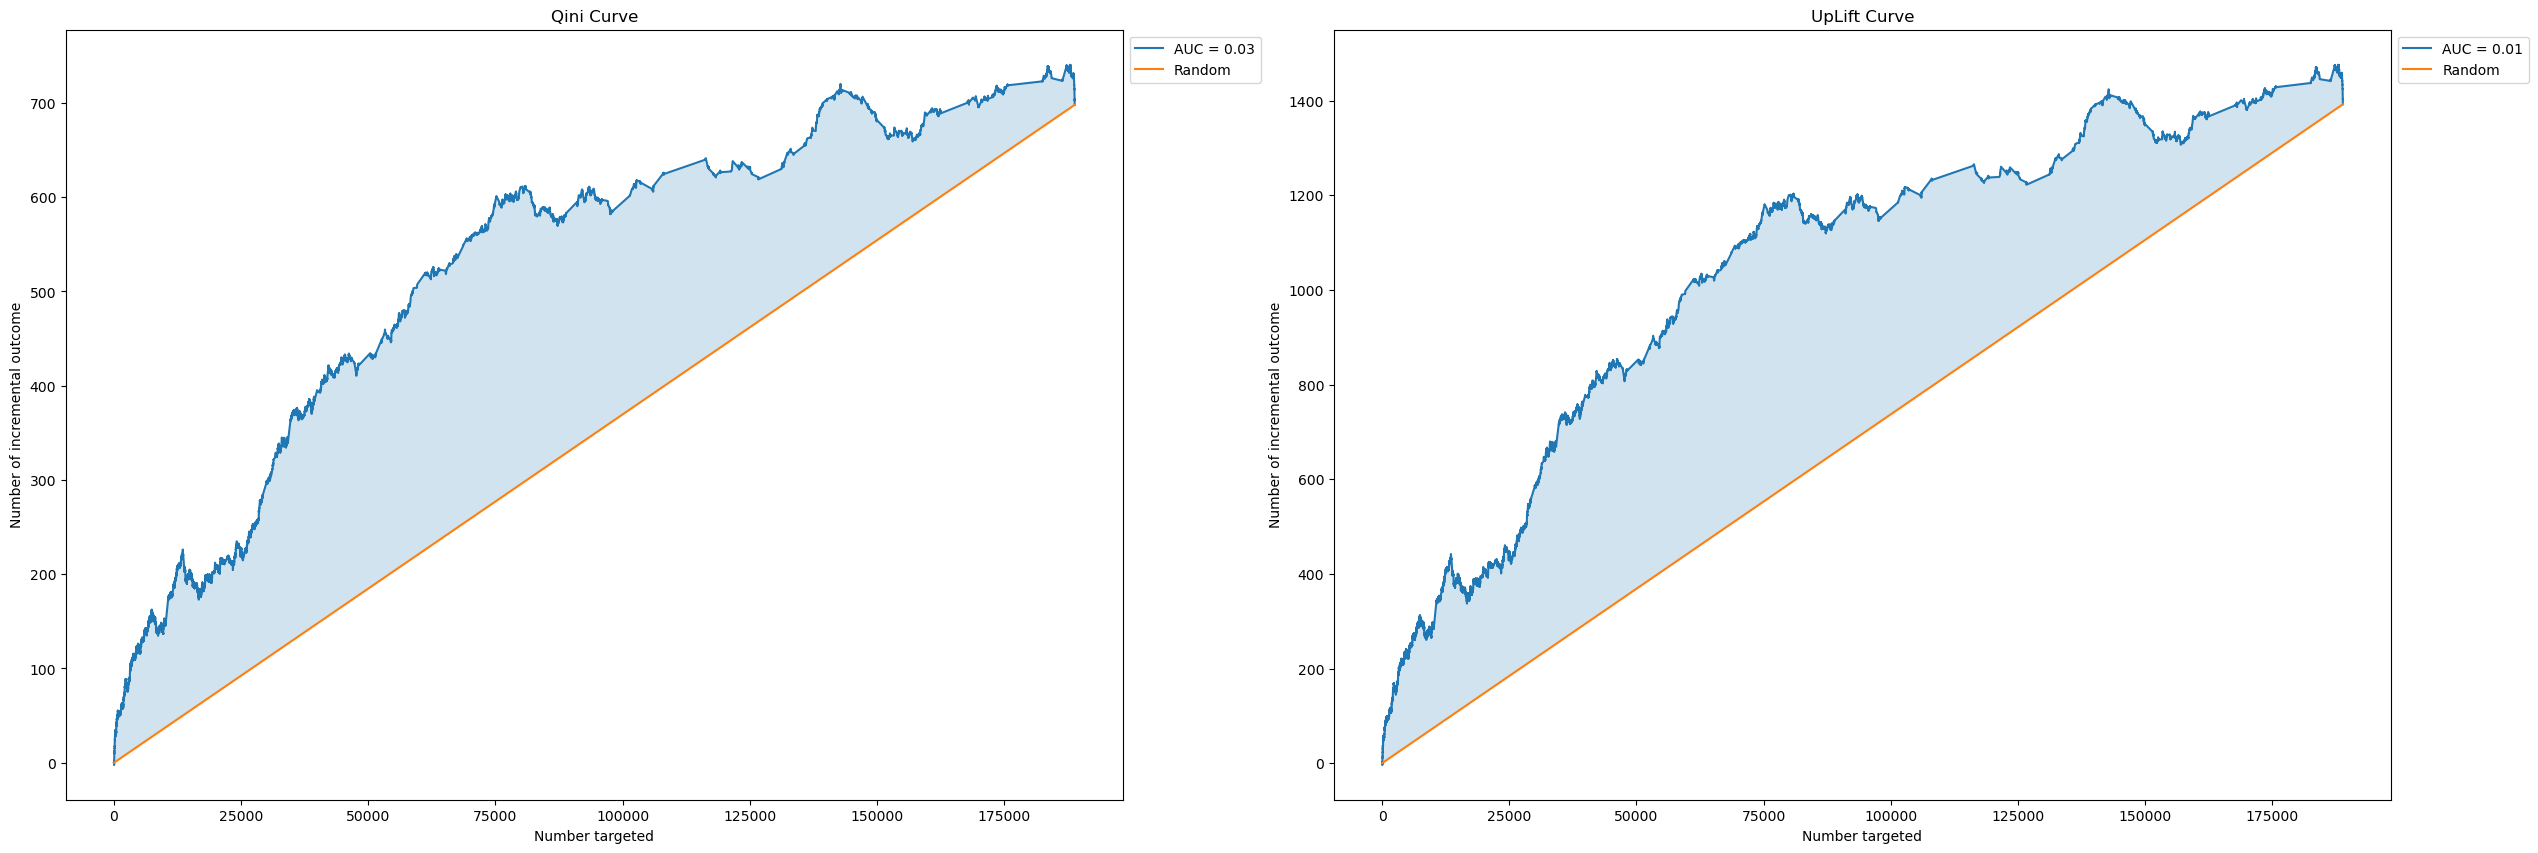

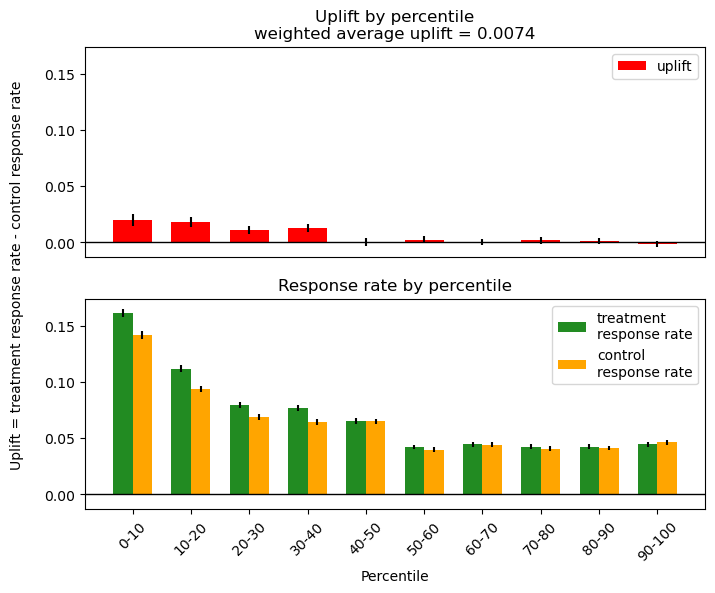

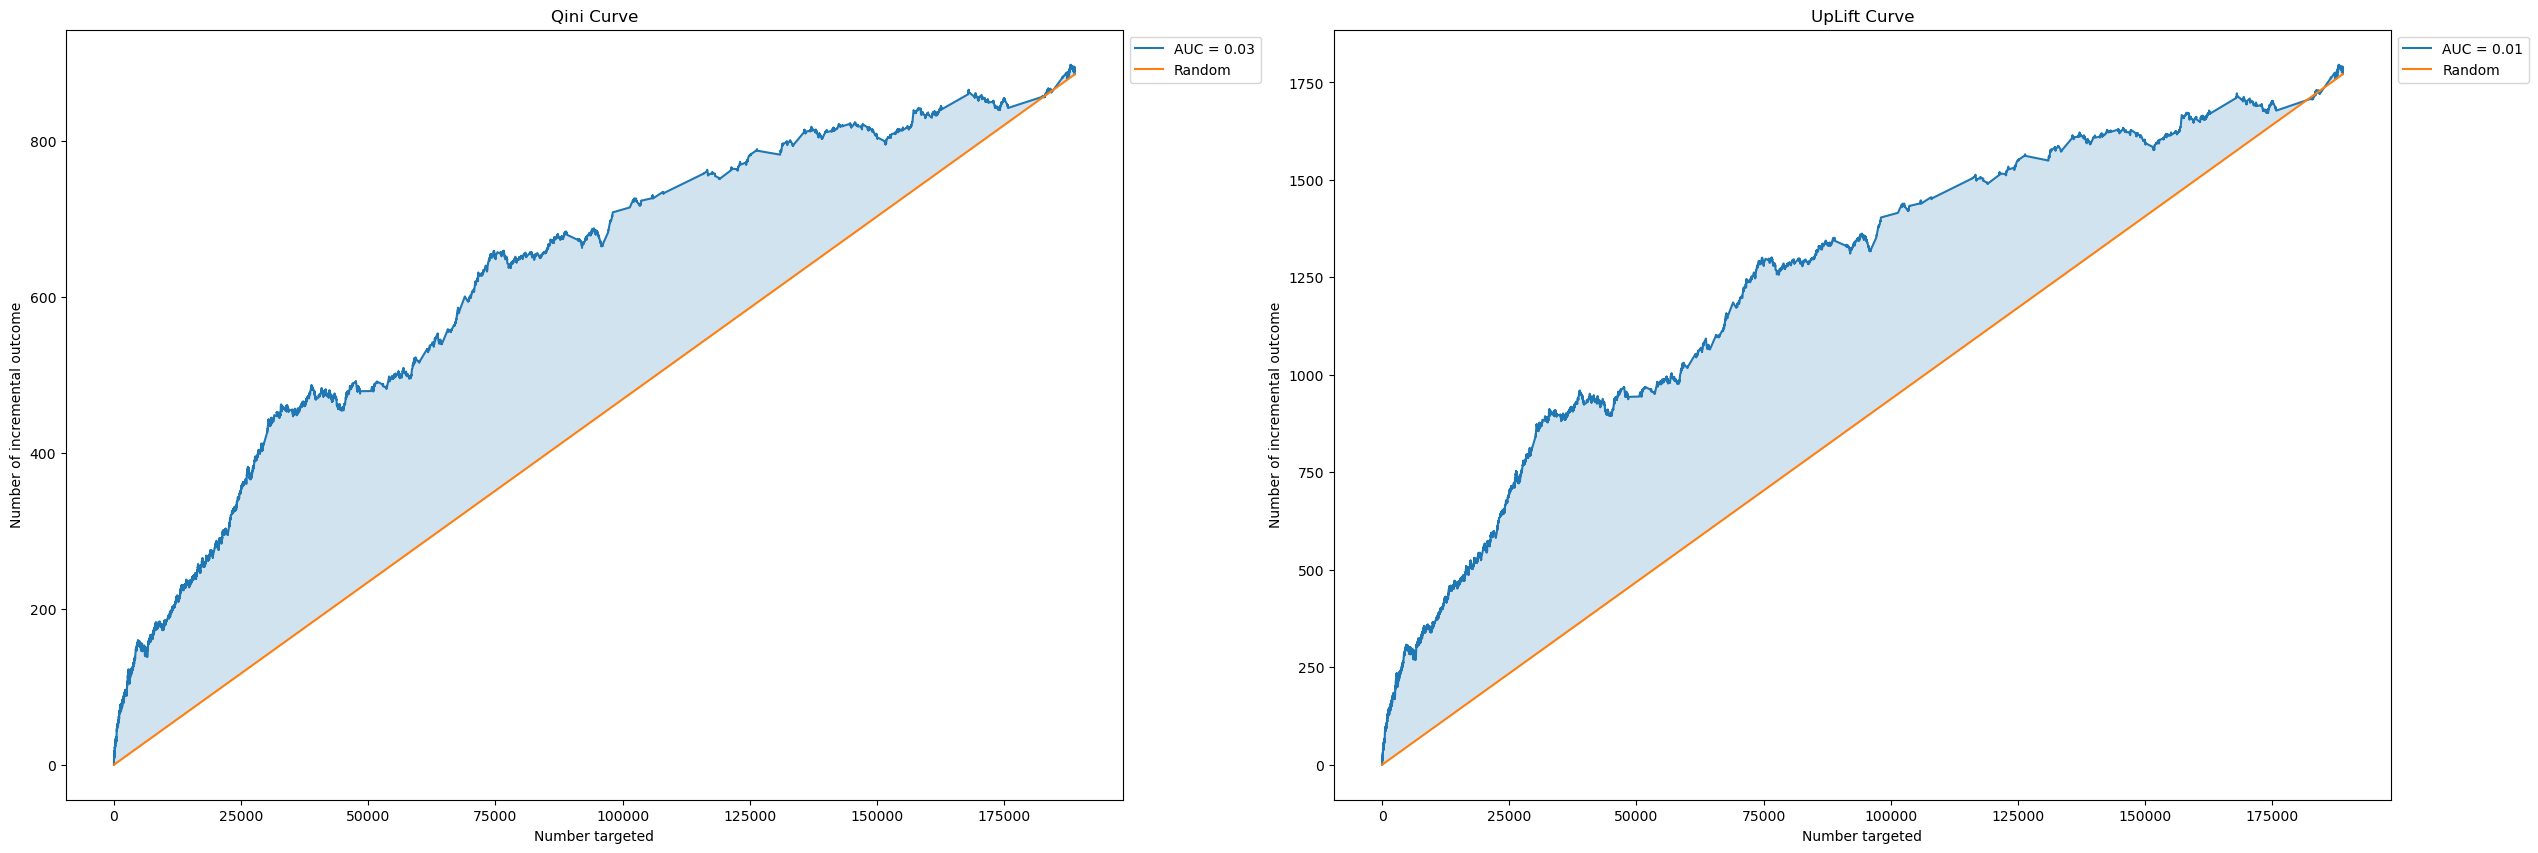

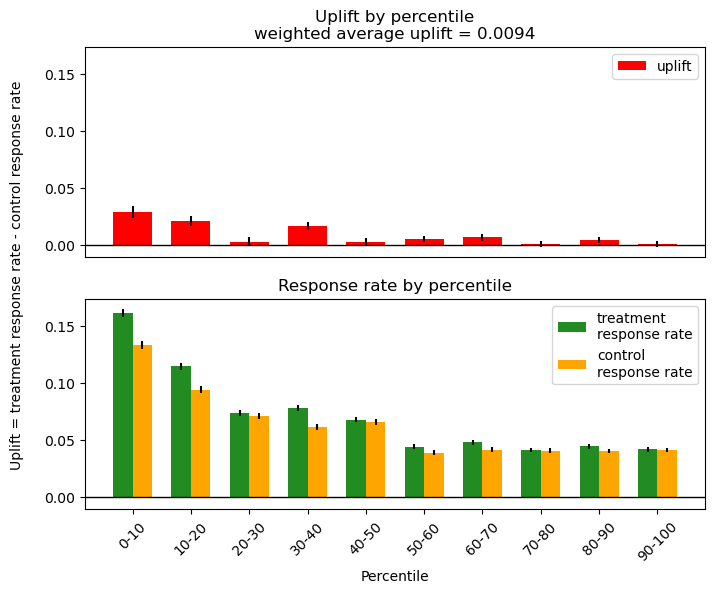

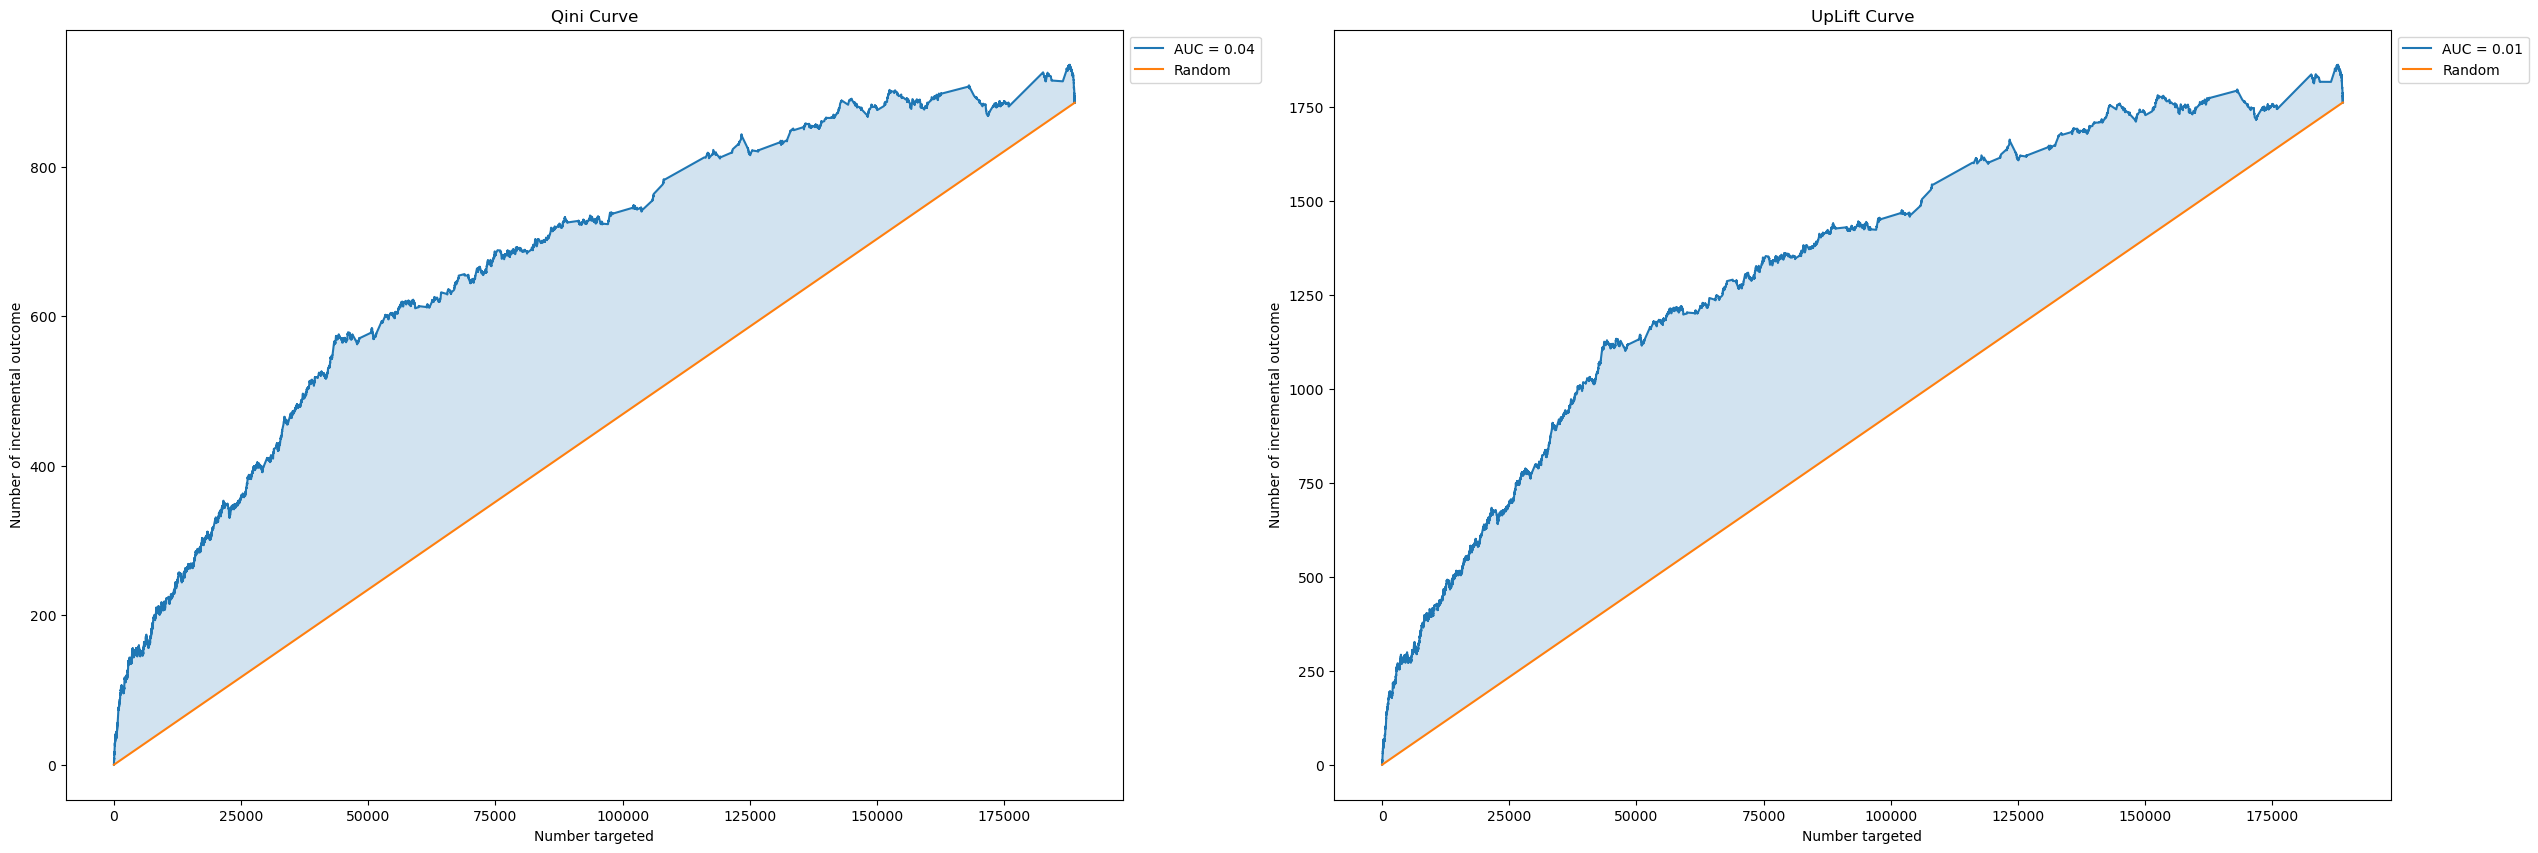

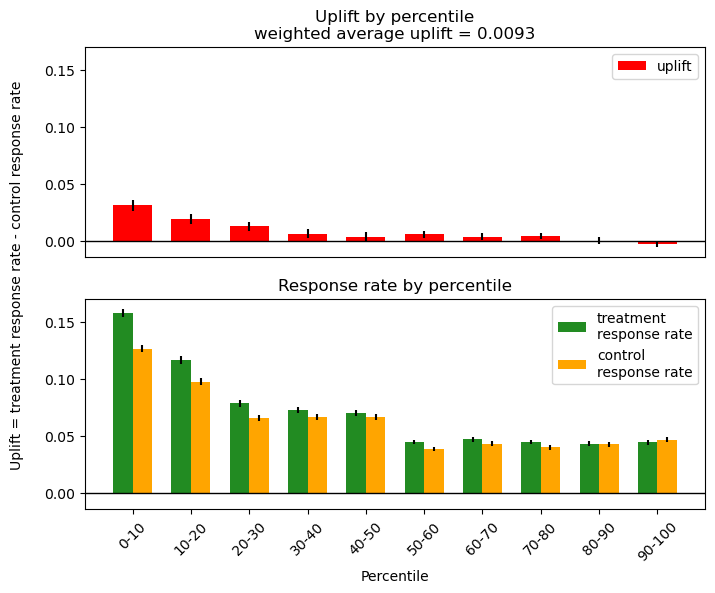

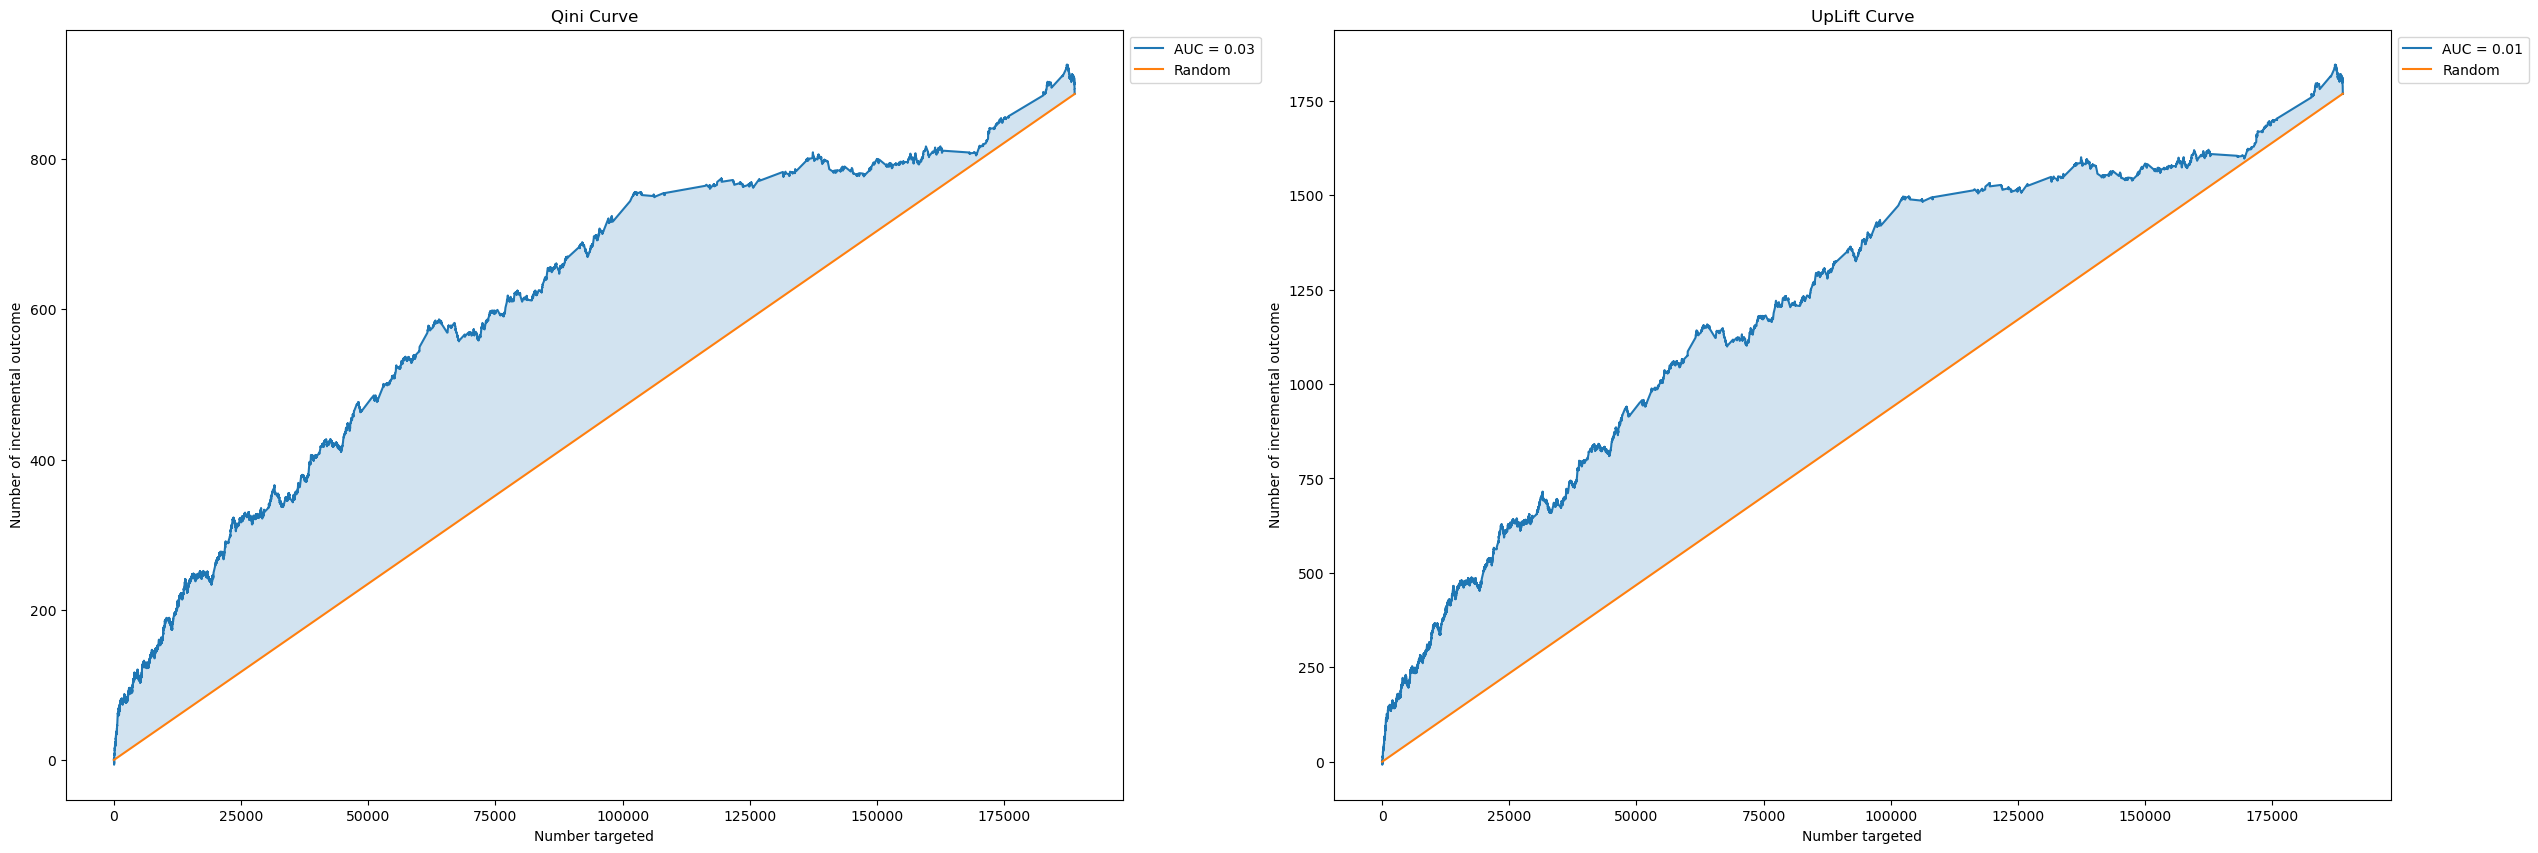

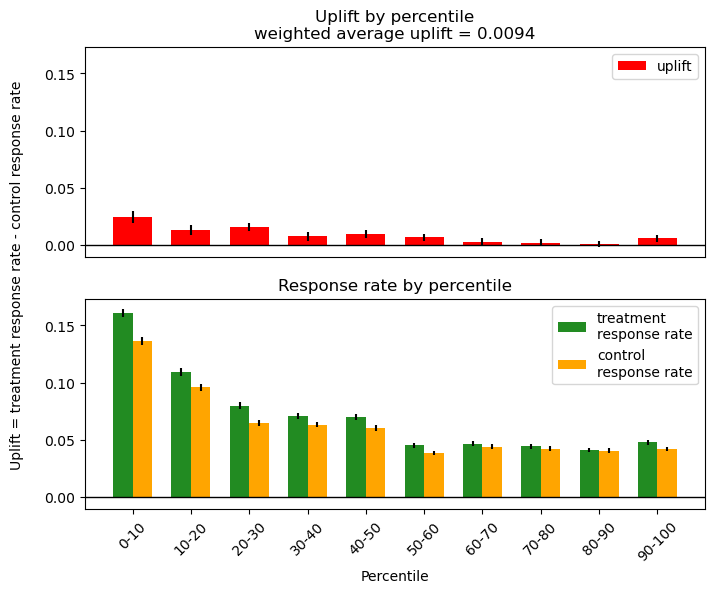

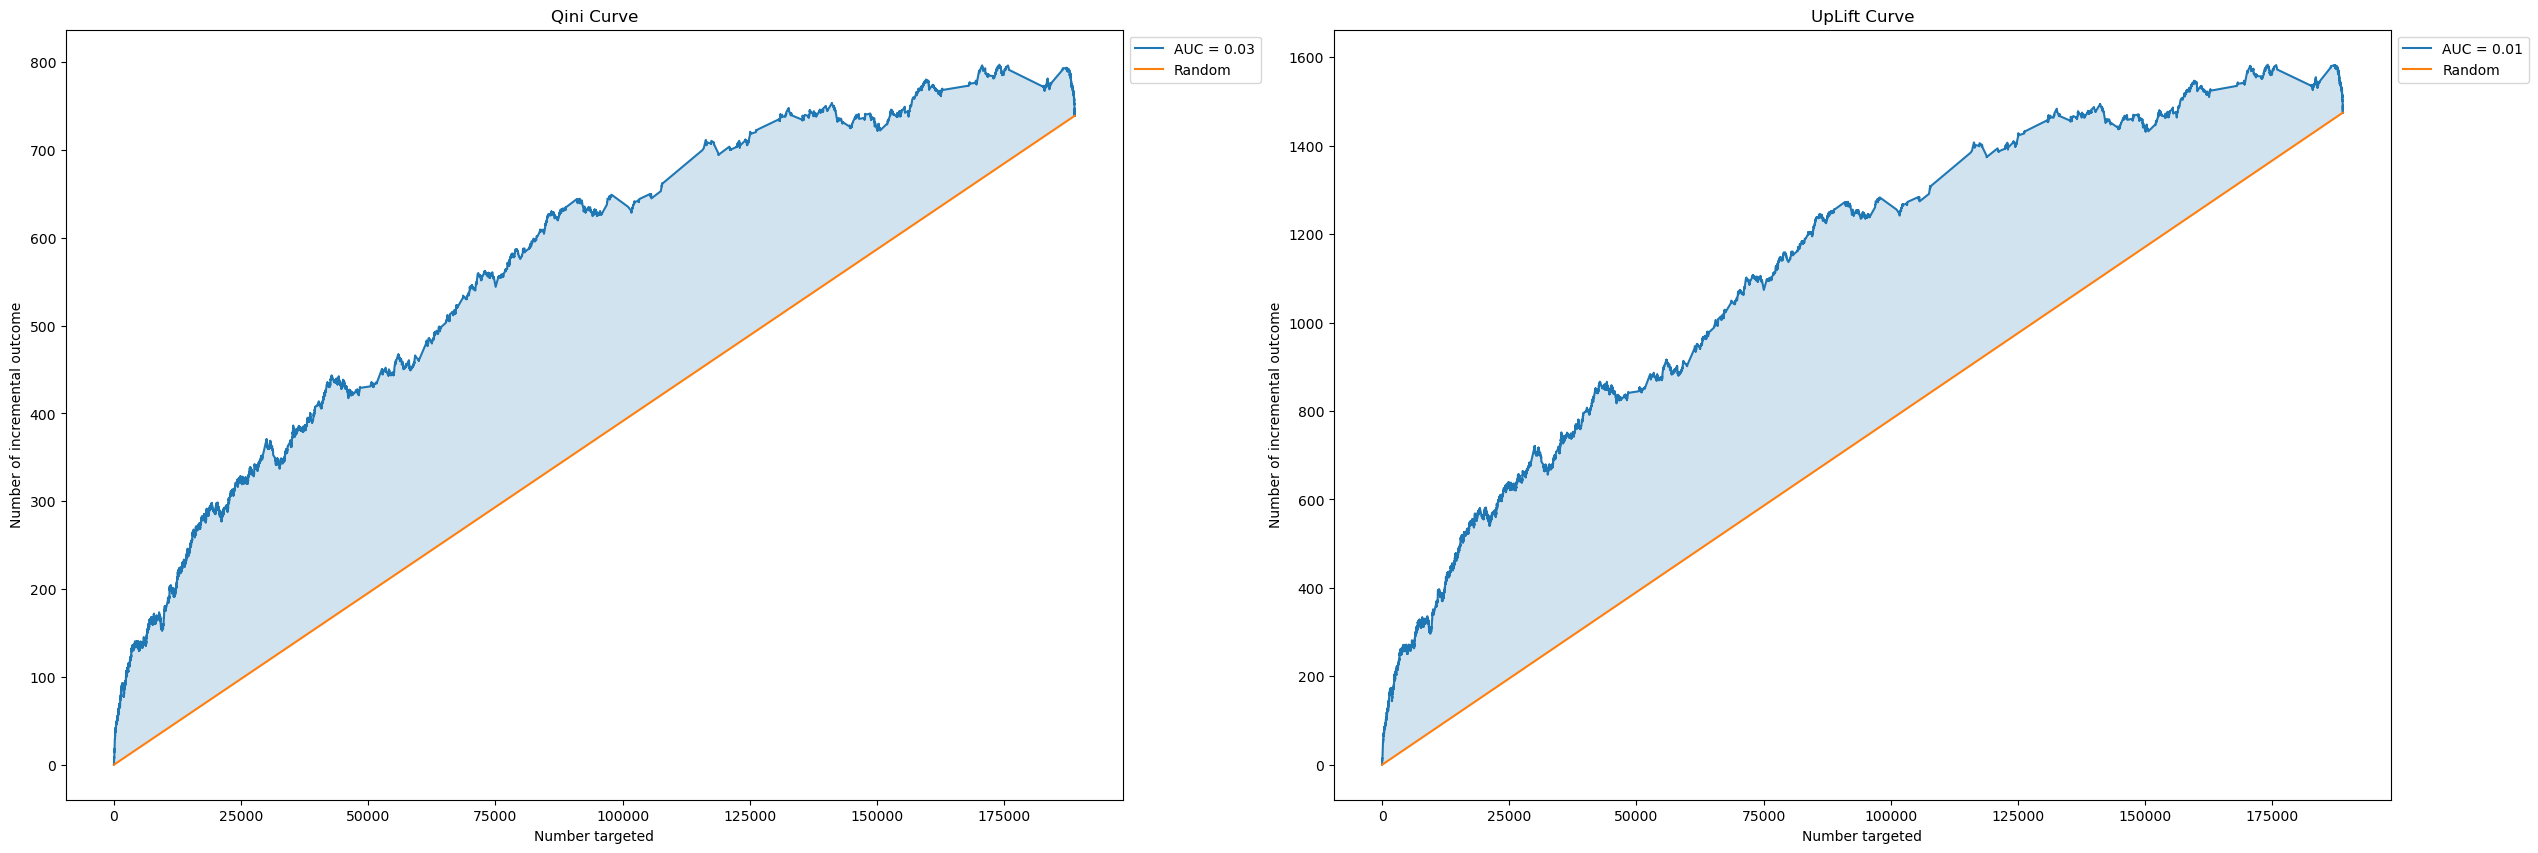

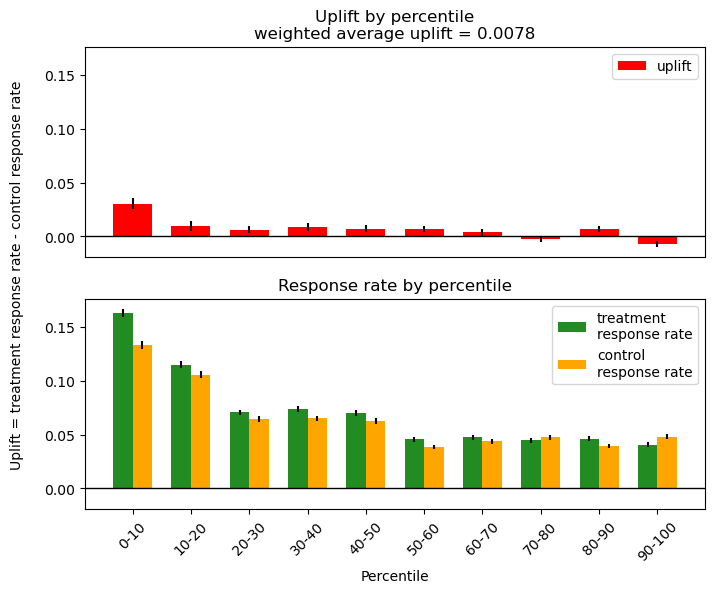

In [50]:
import copy
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k_group':[],  'uplift_k_overall':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      ctbst  = copy.deepcopy(automl.best_pipeline)
      ctbst.fit(X_train_, y_train_)
      y_pred = ctbst.predict(X_test_)
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_group = uplift_at_k(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      uplift_overall = uplift_at_k(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], strategy='overall', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift at 30% {uplift_overall}; {uplift_group}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Trasnform Regression EvalML model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Trasnform Regression EvalML model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% =  {uplift_overall}; {uplift_group}')

# Применение библиотеки Scikit-Uplift в комбинации с CatBoost

In [26]:
from sklift.models import ClassTransformationReg
from sklearn.base import BaseEstimator

from sklearn.utils.multiclass import type_of_target
from sklearn.utils.validation import check_consistent_length

from sklift.utils import check_is_binary

In [27]:
import sklift
sklift.__version__

'0.5.1'

In [30]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
features = X_data.columns.tolist()
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


NewComer  lftm_type_NewComer  lftm_type_Regular  SEGMENT_N_1  \
7701018976         0                   1                  0            0   
7701018997         0                   1                  0            1   
7701019567         0                   1                  0            0   
7701019870         0                   1                  0            0   
7701020445         0                   1                  0            0   

            SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  SEGMENT_N_5  SEGMENT_N_6  \
7701018976            0            0            1            0            0   
7701018997            0            0            0            0            0   
7701019567            0            1            0            0            0   
7701019870            0            1            0            0            0   
7701020445            0            0            1            0            0   

            SEGMENT_N_8  SUB_EMAIL_Да  SUB_EMAIL_Нет  \
7701018976            0             0              1   
7701018997            0             0              1   
7701019567            0             1              0   
7701019870            0             0              1   
7701020445            0             1              0   

            Тип карты_Без возможности оплаты  \
7701018976                                 1   
7701018997                                 1   
7701019567                                 0   
7701019870                                 1   
7701020445                                 0   

            Тип карты_Как карточное платежное средство  \
7701018976                                           0   
7701018997                                           0   
7701019567                                           1   
7701019870                                           0   
7701020445                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  \
7701018976                        0                          1  36.0   
7701018997                        0                          1  55.0   
7701019567                        1                          0  28.0   
7701019870                        0                          1  36.0   
7701020445                        1                          0  22.0   

            last_order_days    AMOUNT    ORDERS       AOV    LTV_1M  \
7701018976         2.042661 -0.394610 -0.326186 -0.308688 -0.394610   
7701018997        -0.381745 -0.507723 -0.326186 -0.516129 -0.507723   
7701019567         0.601122 -0.193753  0.359438 -0.378950 -0.193753   
7701019870         0.863220 -0.426720 -0.326186 -0.367575 -0.426720   
7701020445        -0.348983 -0.640295 -0.326186 -0.759258 -0.640295   

            AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7701018976     -0.326186  -0.382164   0.000000         0.000000   
7701018997     -0.326186  -0.974353   0.000000         0.000000   
7701019567      0.359438   1.954967   1.881439        -0.028650   
7701019870     -0.326186  -0.382164   0.000000         0.000000   
7701020445     -0.326186   0.440000  -0.945282         1.055797   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7701018976       -0.300324        0.000000          -0.327790   
7701018997       -0.352820        0.000000          -0.945474   
7701019567       -0.186582       -0.357901           2.142946   
7701019870       -0.300324        0.000000          -0.327790   
7701020445       -0.422816        0.000000           0.598736   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7701018976           0.000000             0.0      -0.411228   
7701018997           0.000000             0.0      -0.514400   
7701019567           2.173032             0.0      -0.187688   
7701019870           0.000000             0.0      -0.411228   
7701020445          -1.077897             0.0      -0.651963   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS

target  treat
7701018976       0      1
7701018997       0      0
7701019567       0      1
7701019870       0      1
7701020445       0      0

[[0.       1.       0.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.269954 0.017543 0.266453]
 ...
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]]
[ 0. -0.  0. ...  0. -0. -0.]
0.5010158242714119


Split 1; WAU = 0.007832964790919678; UpLift 30% = 0.01705224195456198


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 2; WAU = 0.009405154111598318; UpLift 30% = 0.017088927883819244


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 3; WAU = 0.009143054846603257; UpLift 30% = 0.02200289575721534


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 4; WAU = 0.0068205753192238615; UpLift 30% = 0.015493891652616804


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 5; WAU = 0.01103813217950361; UpLift 30% = 0.022150146298680284


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Mean WAU = 0.0088; Mean UpLift 30% = 0.0188


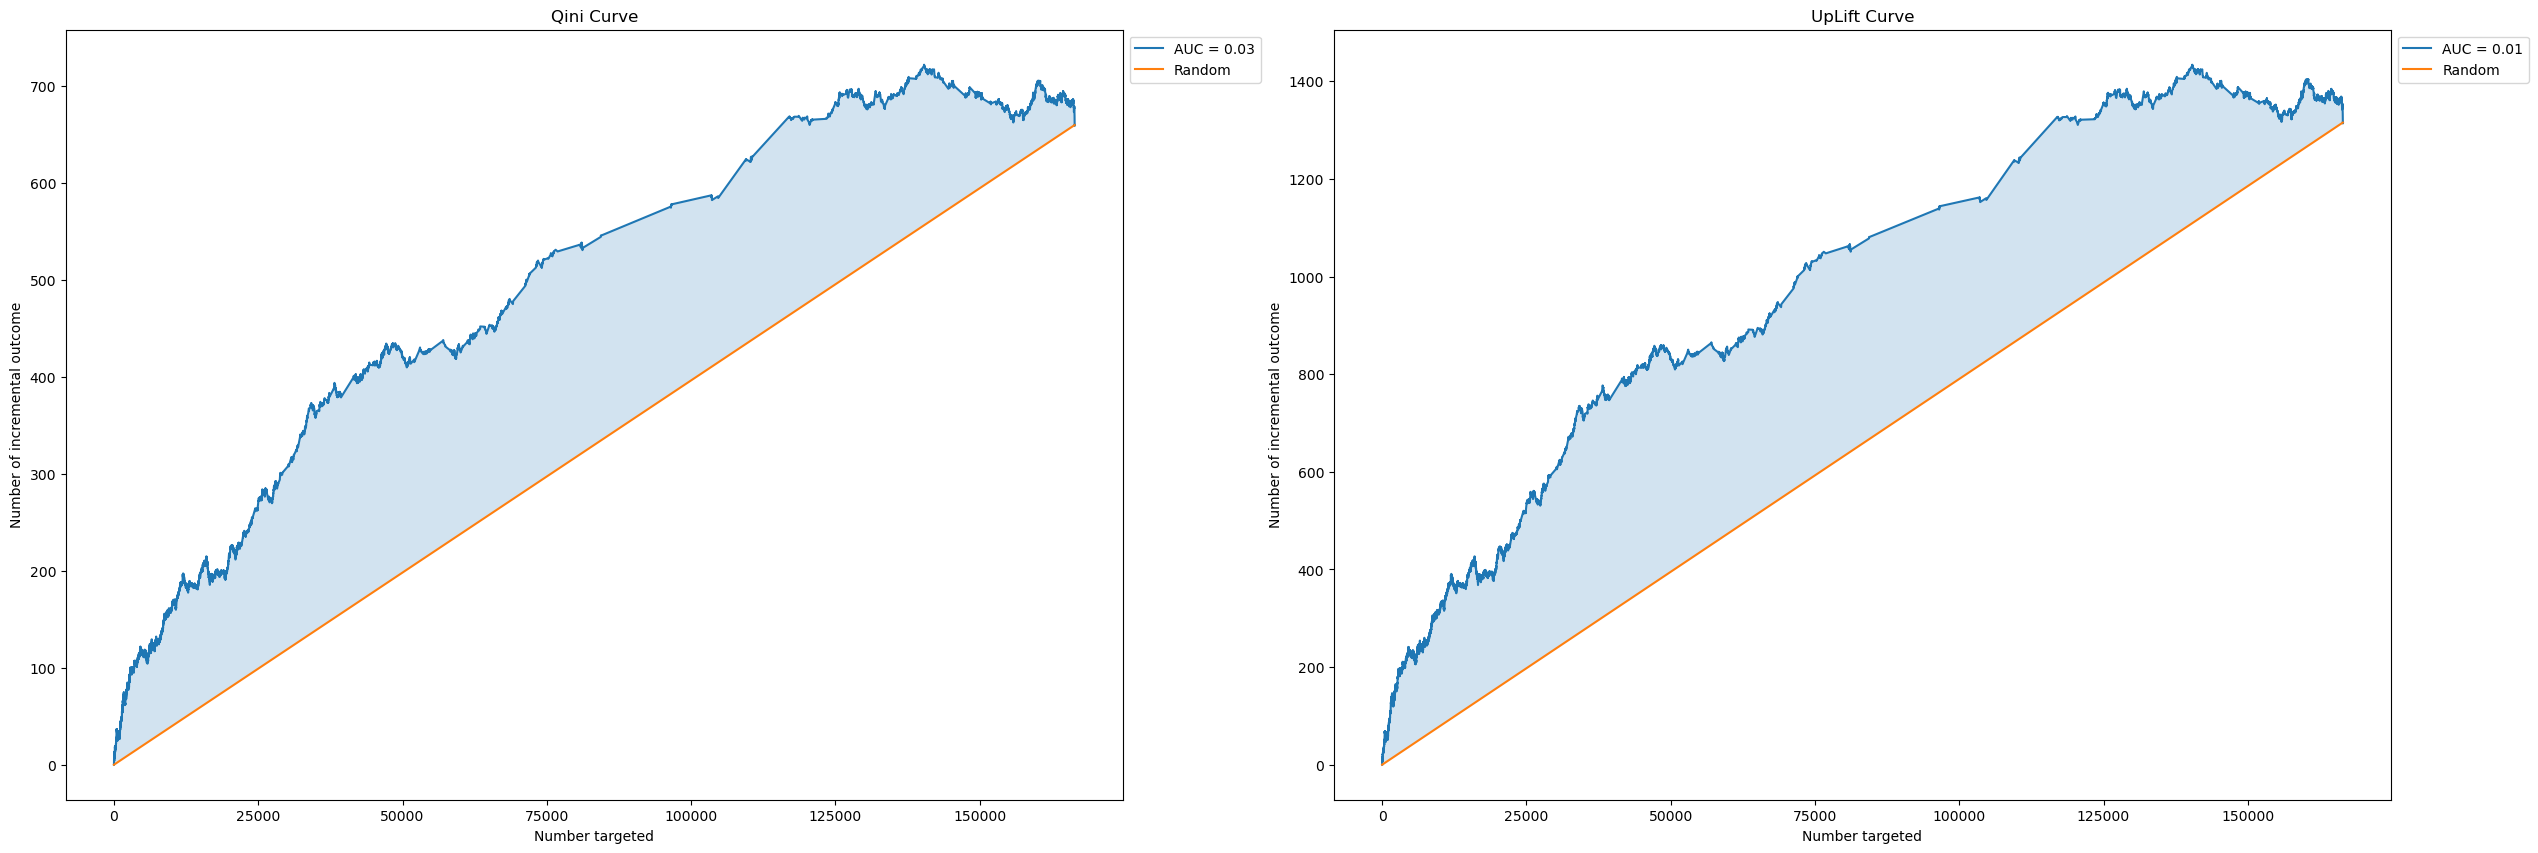

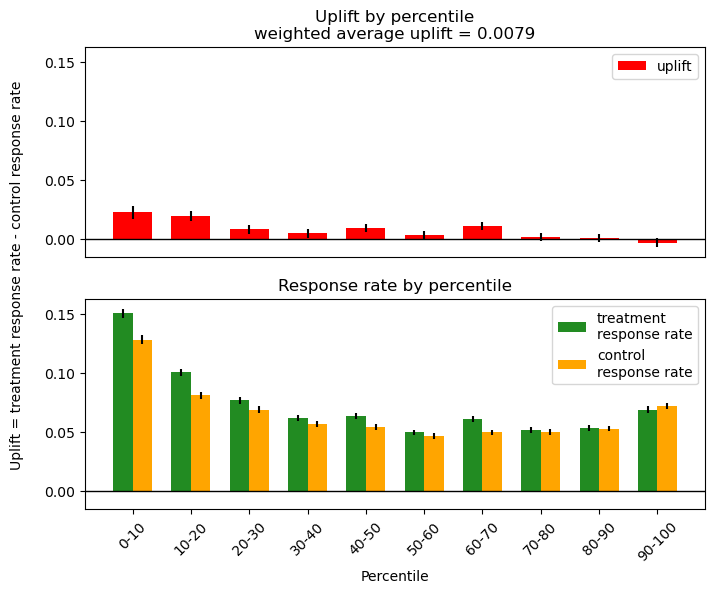

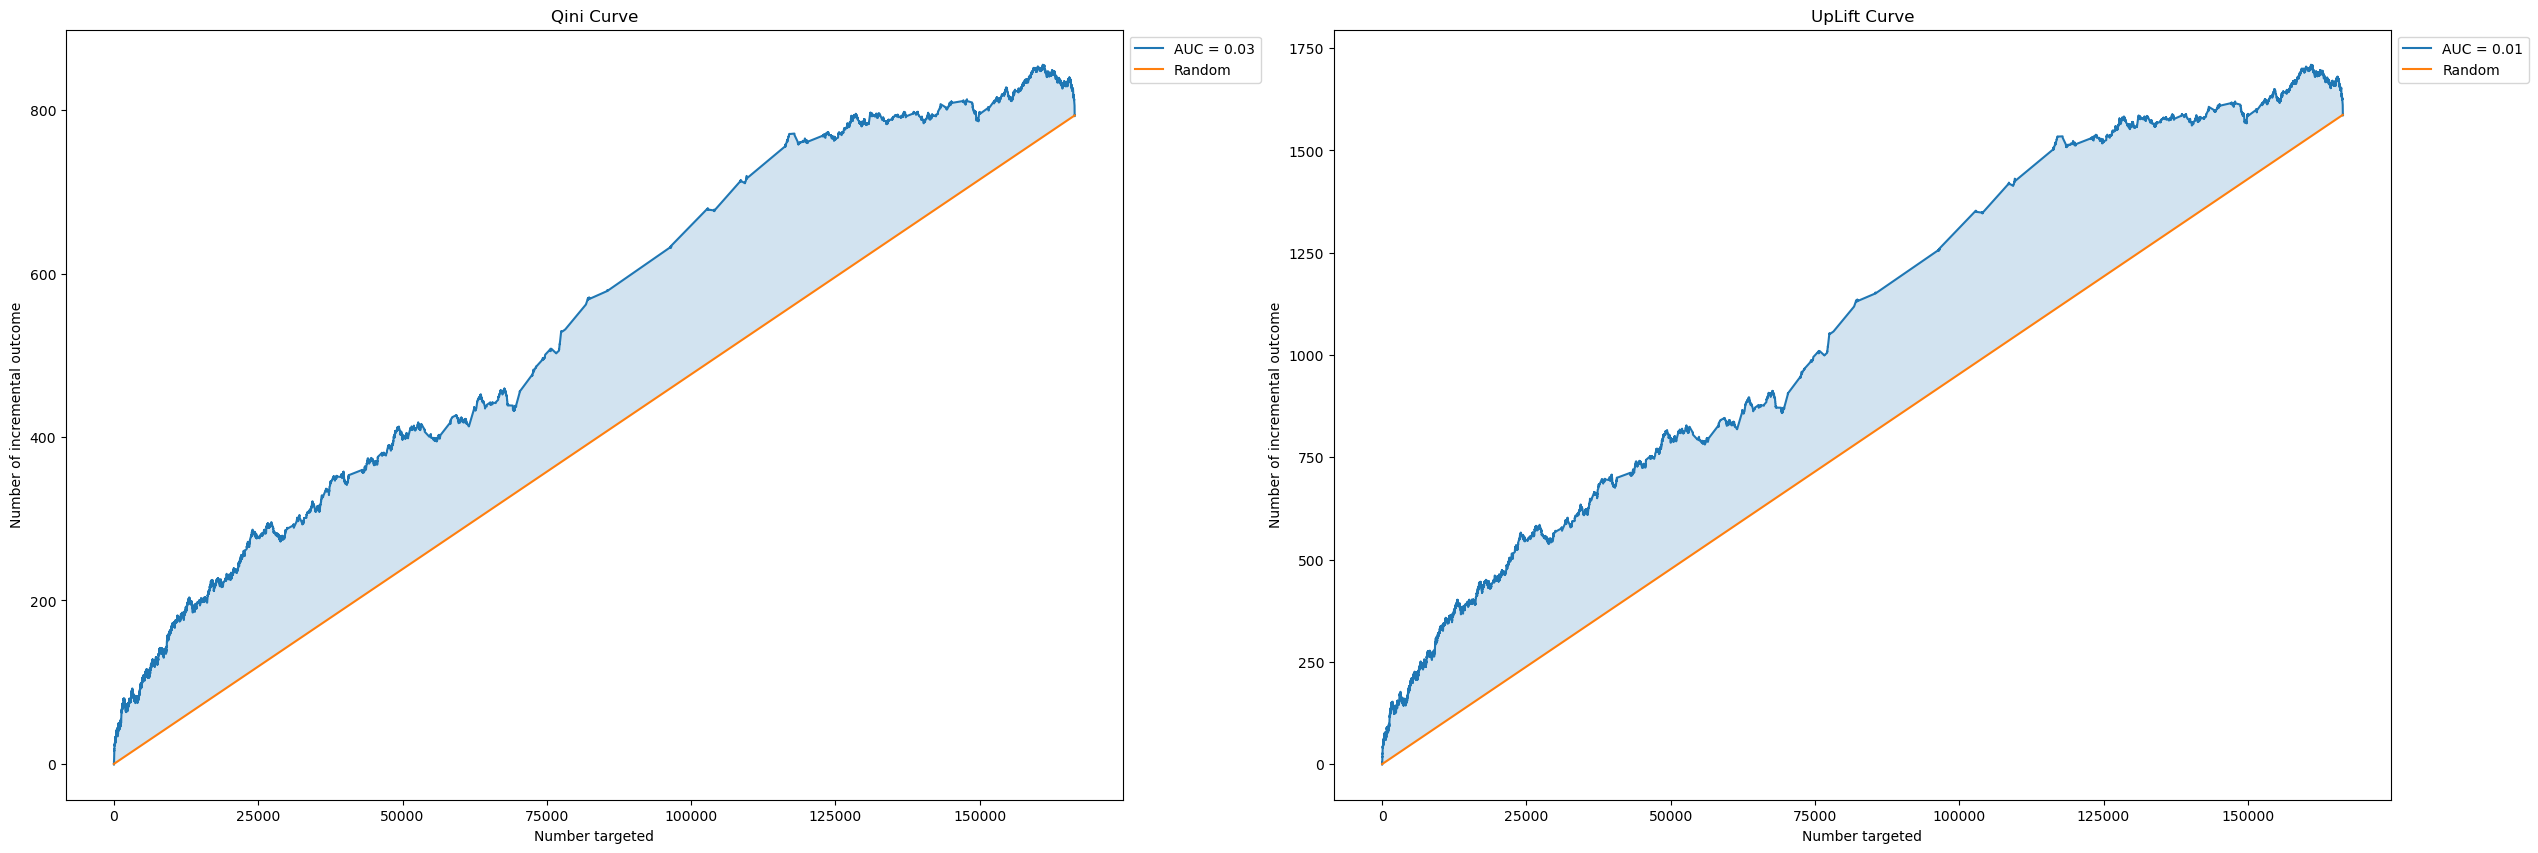

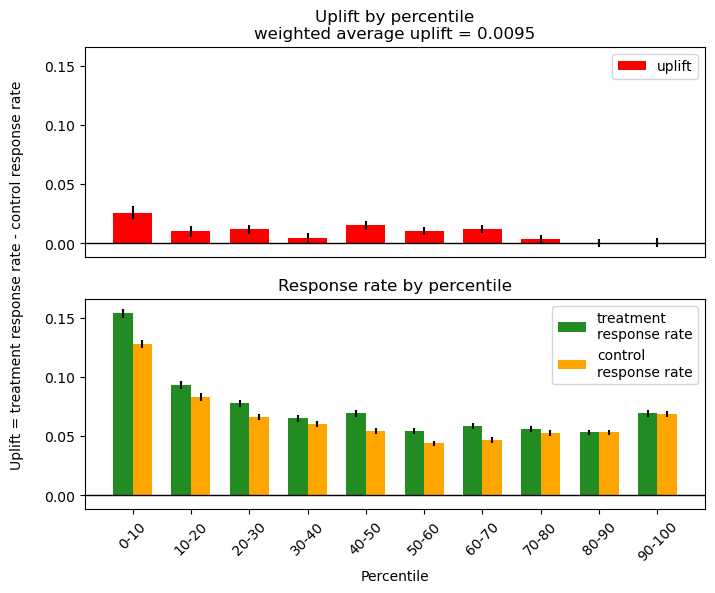

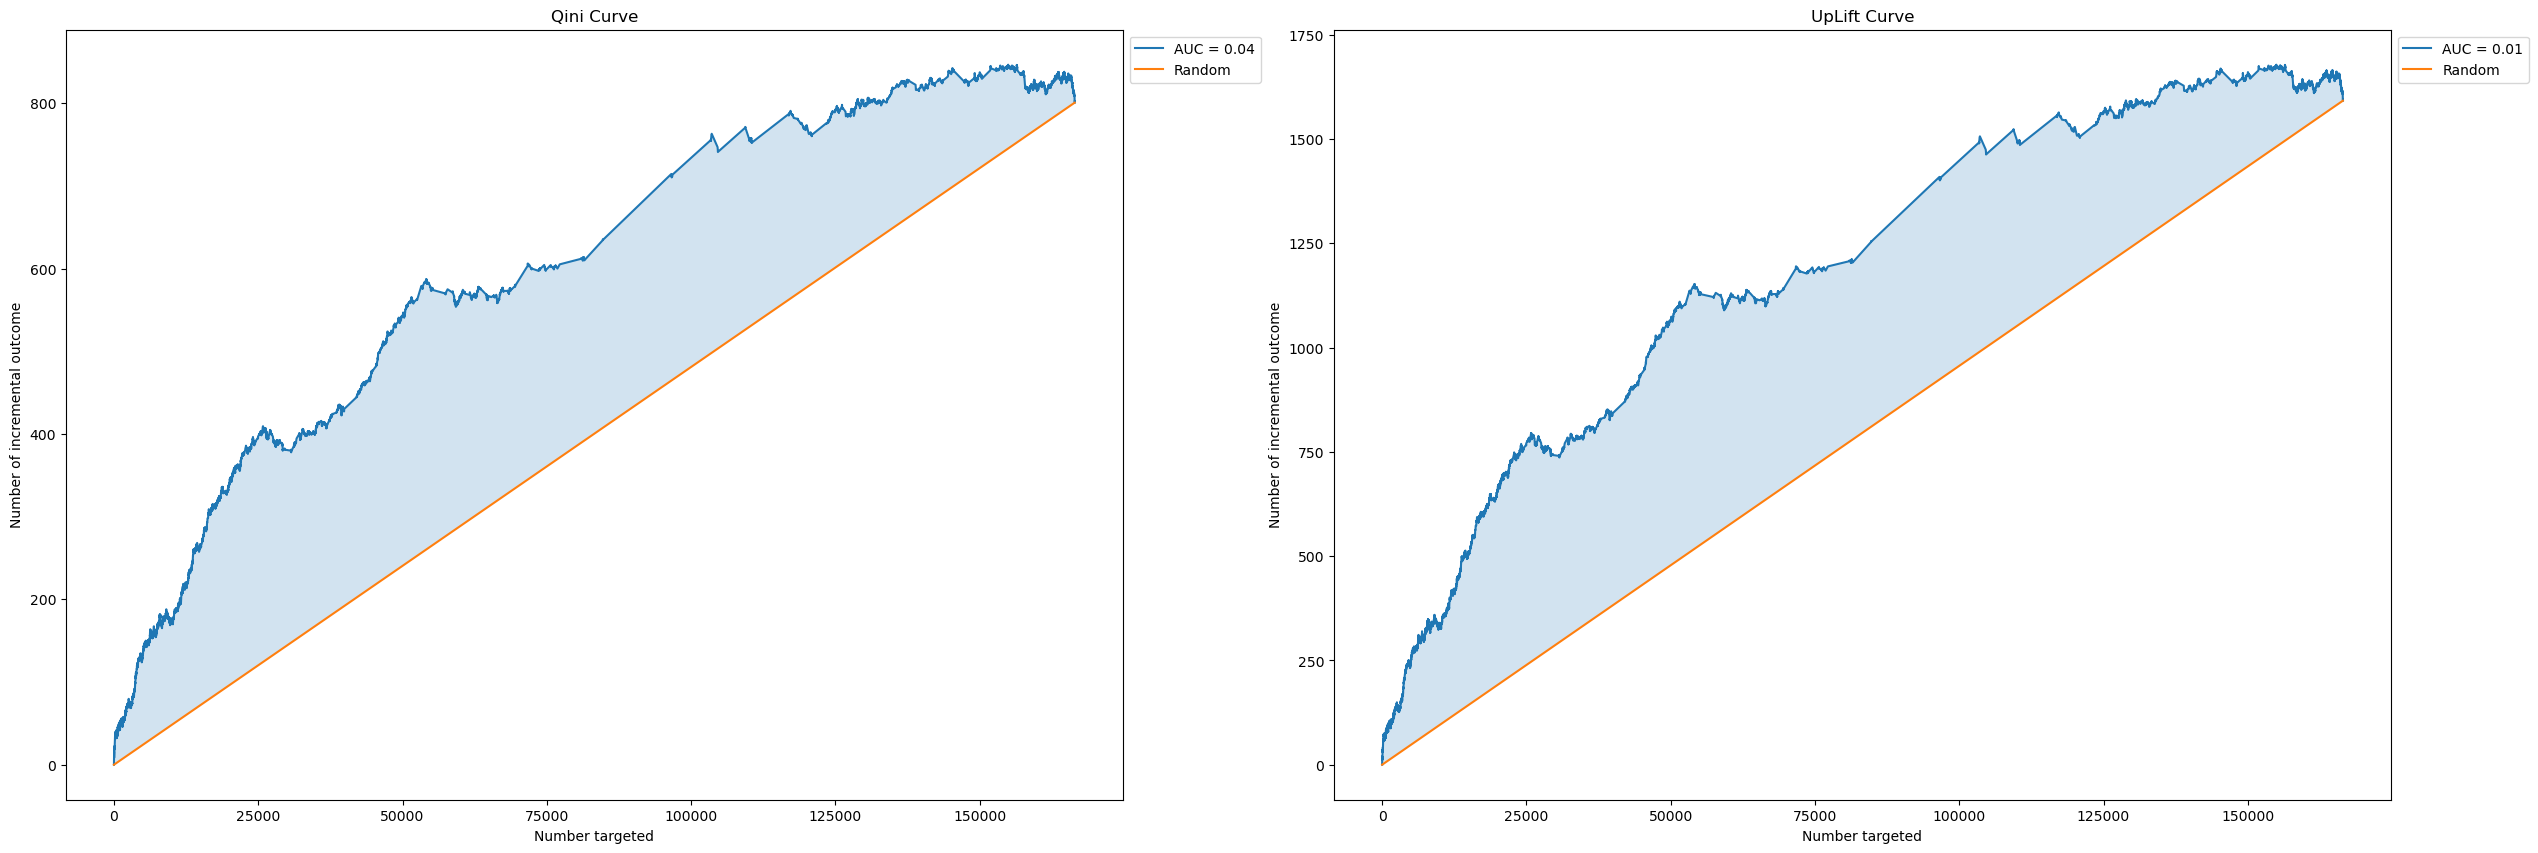

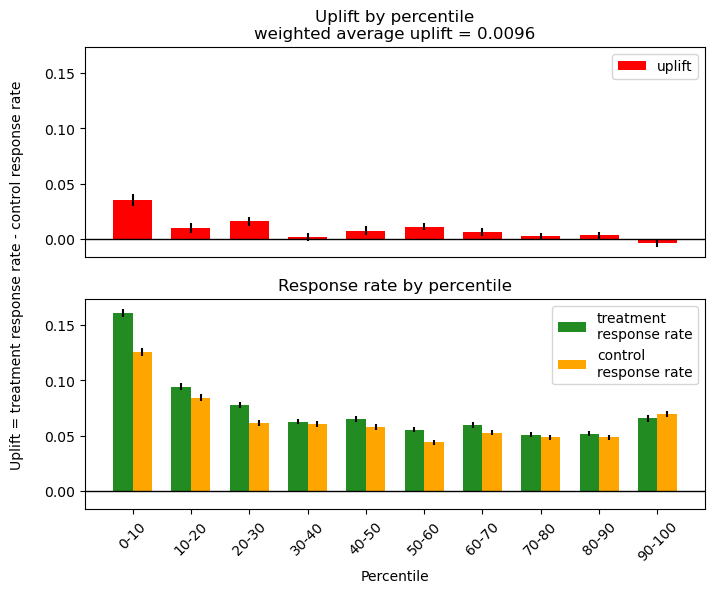

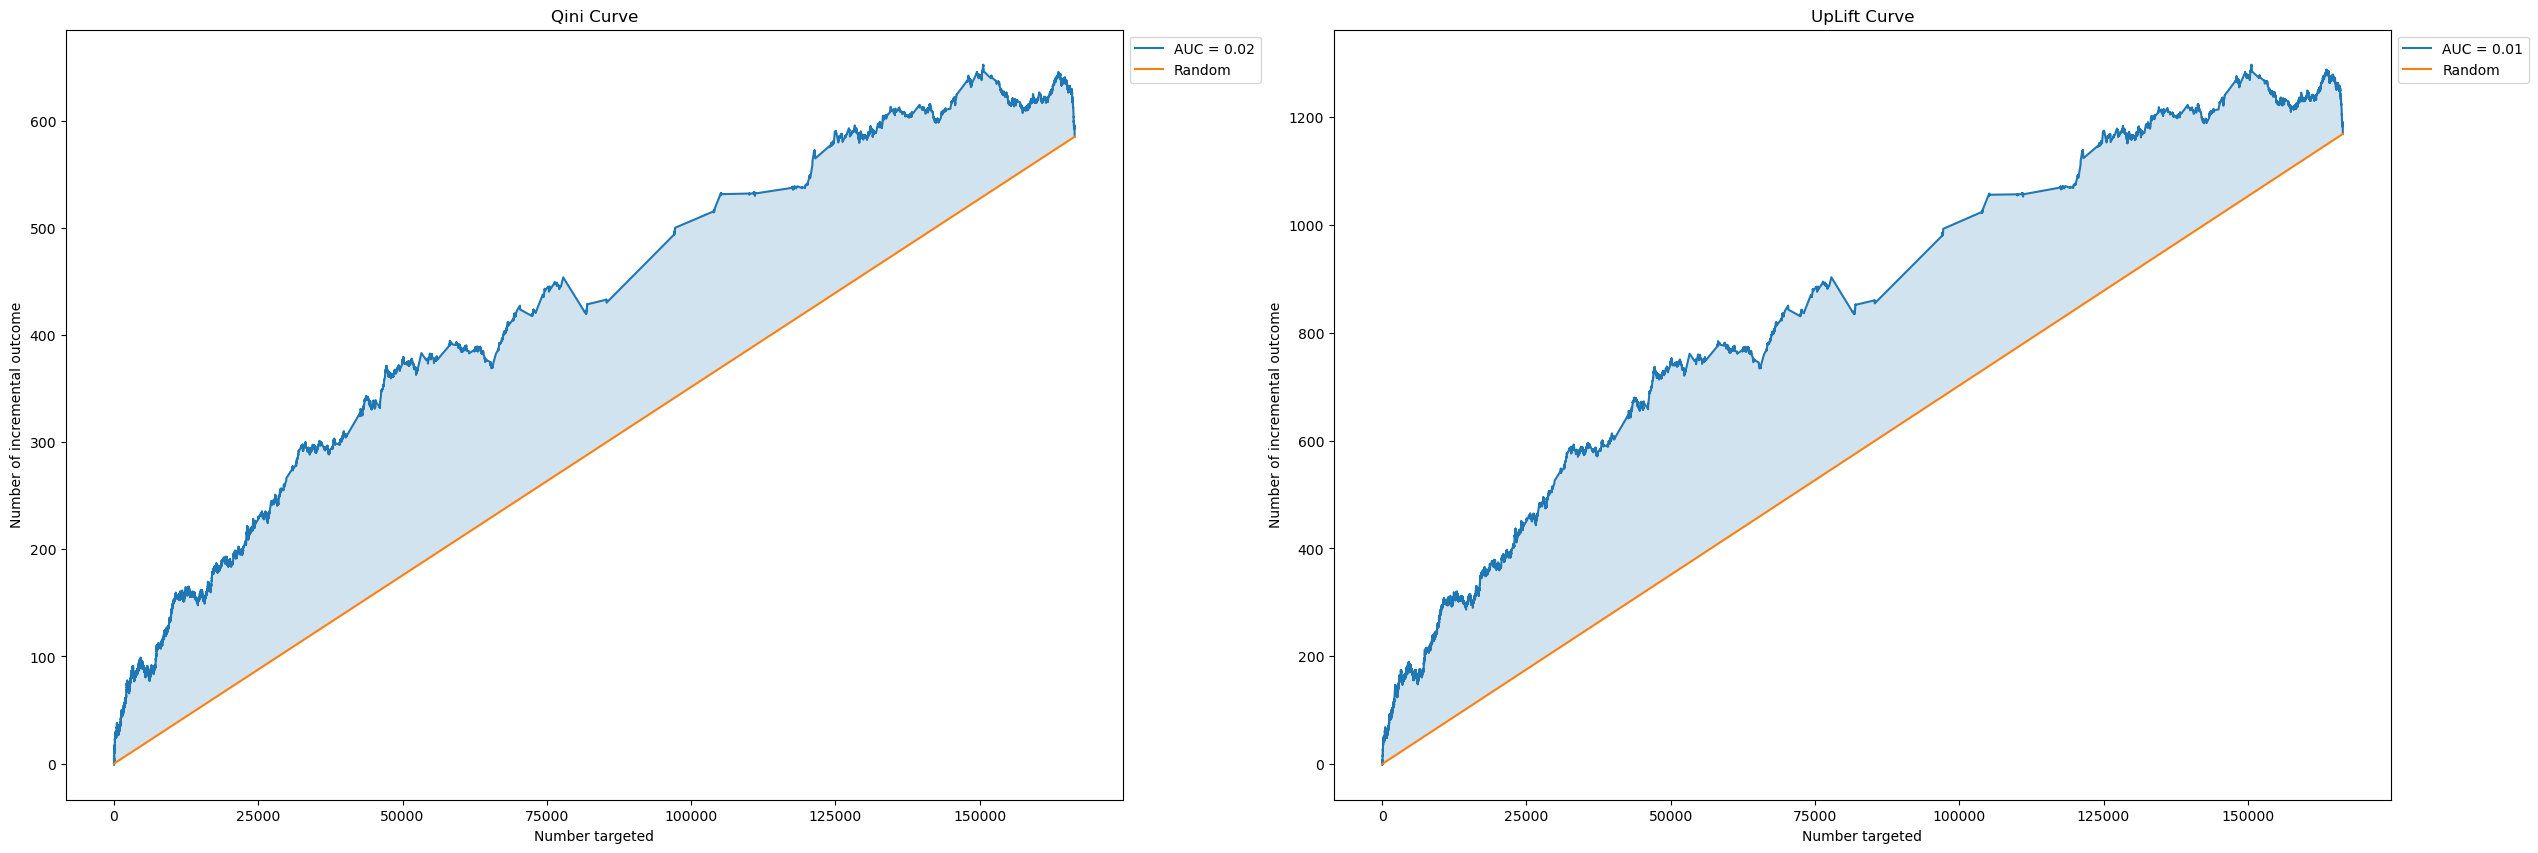

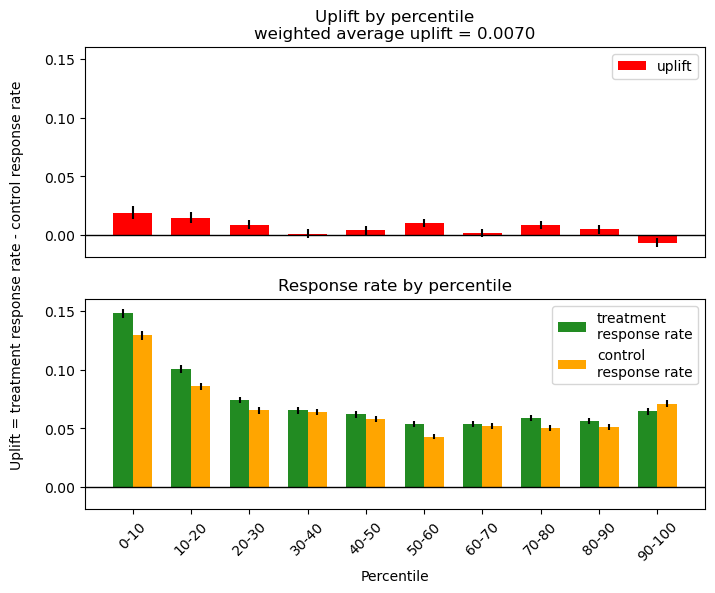

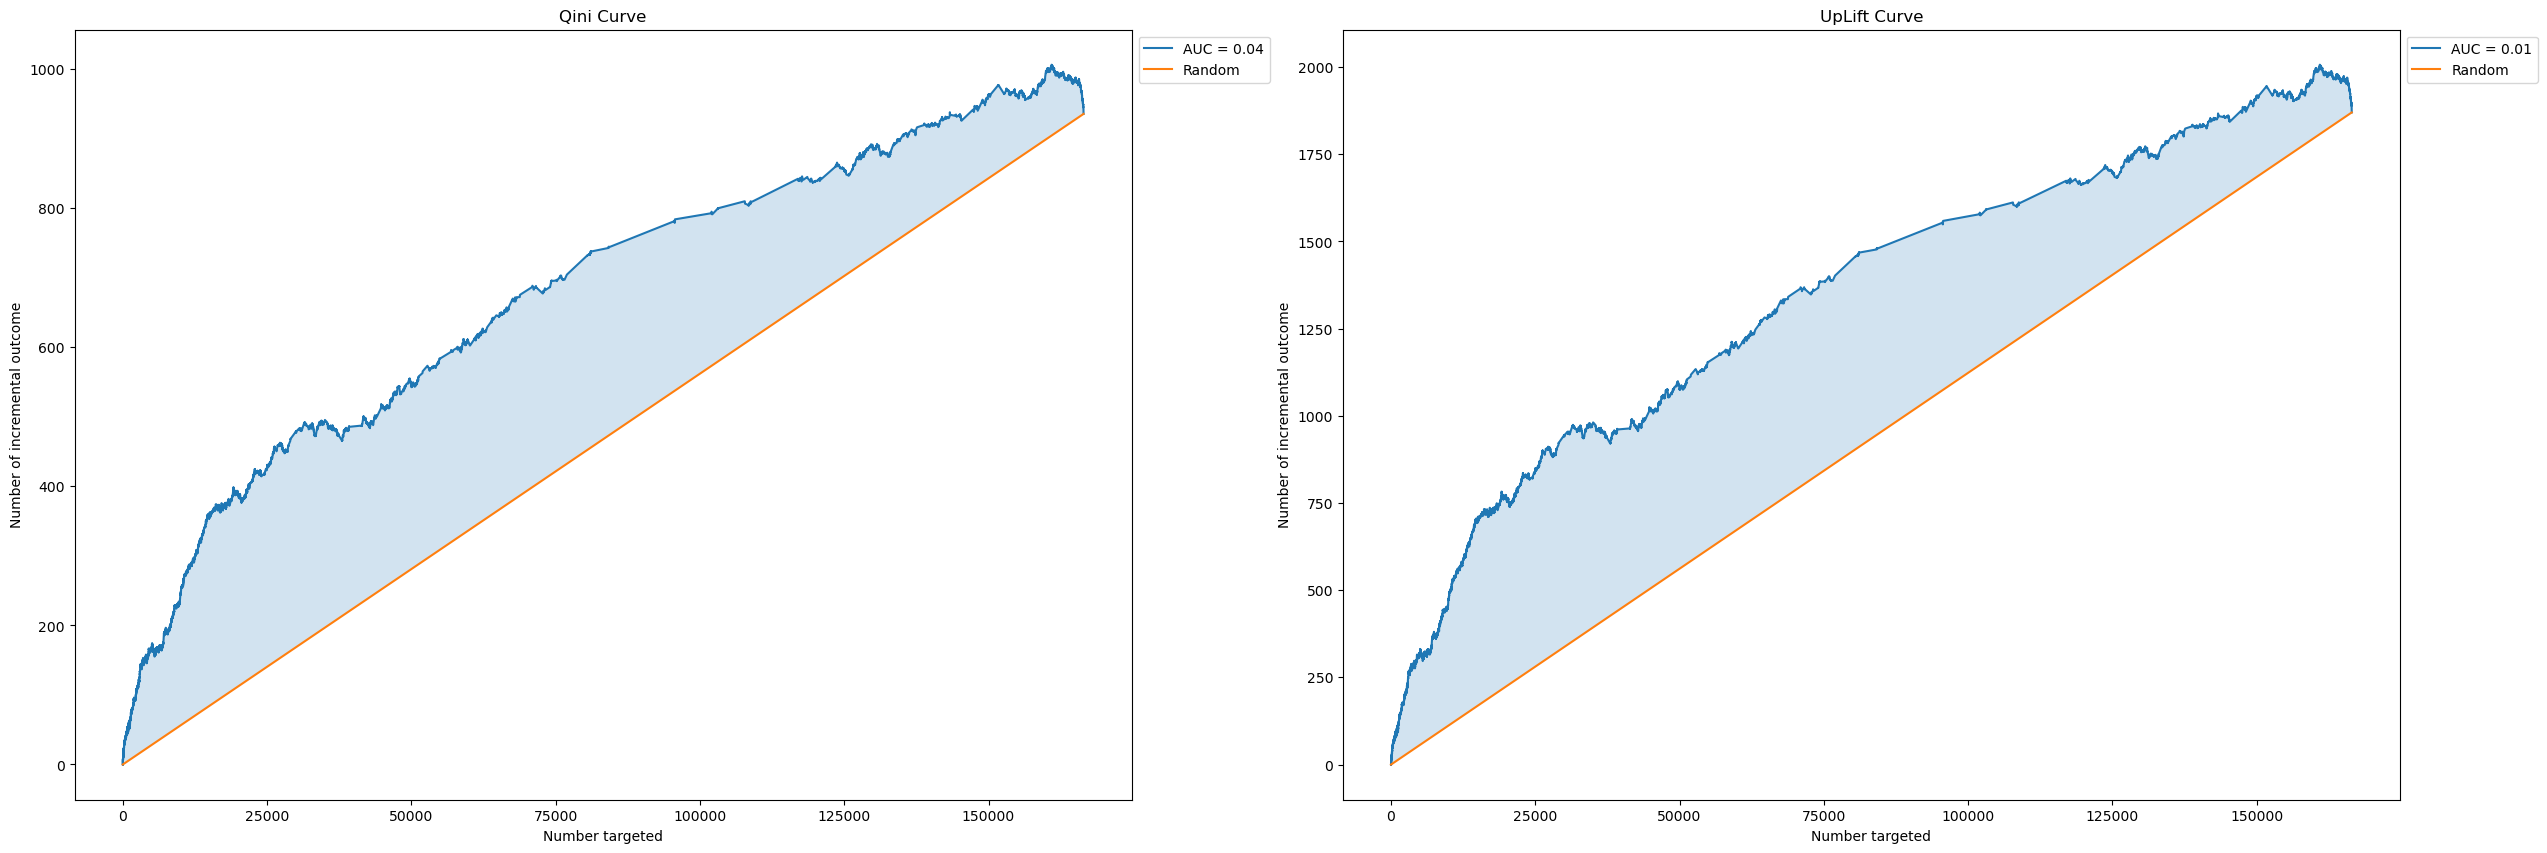

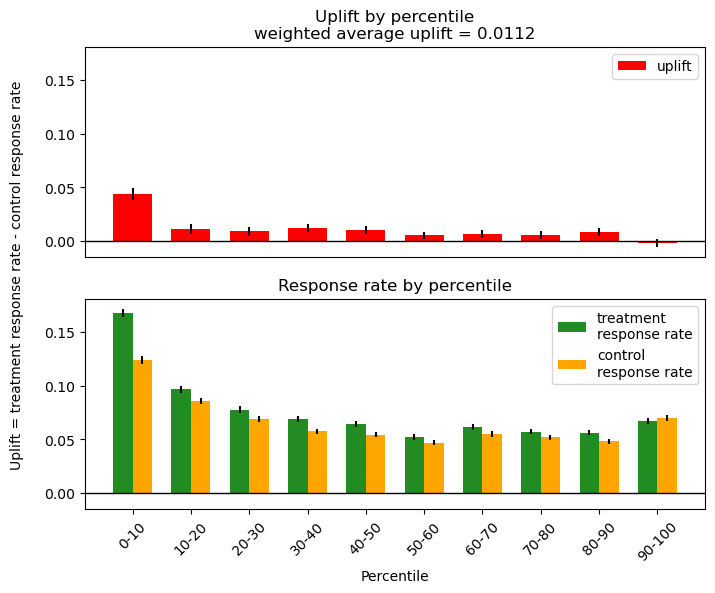

In [31]:
%matplotlib inline
import copy
# Метод двух моделей
#Default data
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0


# grid = { 'max_depth':2,
#     'learning_rate': 0.2, 
#     'n_estimators': 100,}

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      ctbst  = copy.deepcopy(automl.best_pipeline)
      ctbst = ClassTransformationReg(estimator=ctbst, propensity_val=p)
      ctbst.fit(X = X_train_, y = targ[train_index], treatment= treat[train_index])
      y_pred = ctbst.predict(X_test_)
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% = {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Regression model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Regression model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')
